# 0.0 Import Libraries

In [ ]:
pip install spectral mat73  einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import math
import pandas as pd

from einops import rearrange
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io
import torch.utils.data
import scipy.io as sio
import mat73
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1.0 Upload Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls '/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

 2013_DFTC						 best_model_p13_weights.pth
 2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat	 best_model_p15_weights.pth
 2013_IEEE_GRSS_DF_Contest_LiDAR.mat			 best_model_p3_weights.pth
 ablationp5_spatialonly_UH2013_model_state_dict.pth	 best_model_p7_weights.pth
 ablationp7_removeZpath_Uh2013_model_state_dict.pth	 best_model_p9_weights.pth
 ablationp7_removeZpath_UH2013_model_state_dict.pth	 best_model.pth
 ablationp7_spatialonly_Uh2013_model_state_dict.pth	 best_model_weights.pth
 ablationp7_spatialonly_UH2013_model_state_dict.pth	 best_model_wts.pth
 ablationp7_Uh2013_model_state_dict.pth			 BS_RLFCC_UH2013.ipynb
 ablationp7_UH2013_model_state_dict.pth			 cae_model_state_batchscore.pth
 ablation_Uh2013_model_state_dict.pth			 cae_model_state.pth
 ablation_UH2013_model_state_dict.pth			'Contrastive Best model'
 Autoencodermodel.pth					 cross_modal_autoencoder_best.pth
 Autoencodermodel_uh2013_20Ksample.pth			 cross_modal_autoencoder.pth
 Autoencodermodel_uh2013_adam_20Ksample.pth	

In [ ]:
 # Define the path
path='/content/drive/MyDrive/A02_RemoteSensingData/UHS_2013_DFTC/'

In [ ]:
# 2.1 Loads Data
# Load hyperpsectral data
hsi_2013_data=sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
print('hsi_2013_data shape:', hsi_2013_data.shape)

# Loader Lidar  data
import mat73
lidar_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_LiDAR.mat')['LiDAR_data']

print('Lidar_2013_data shape:', lidar_2013_data.shape)

#Load ground truth labels
gt_2013_data=sio.loadmat(path+'GRSS2013.mat')['name']
print('gt_2013_data.shape:', gt_2013_data.shape)

hsi_2013_data shape: (349, 1905, 144)
Lidar_2013_data shape: (349, 1905, 1)
gt_2013_data.shape: (349, 1905)


#Segementation Task

In [ ]:
# from sklearn.cluster import KMeans
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the data
# hsi_2013_data = sio.loadmat(path+'2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat')['ans']
# print('hsi_2013_data shape:', hsi_2013_data.shape)

# # Reshape the data
# hsi_2013_data = np.transpose(hsi_2013_data, (1, 0, 2))  # Swap the width and height
# print('After transpose, hsi_2013_data shape:', hsi_2013_data.shape)

# # Flatten the data
# flattened_data = hsi_2013_data.reshape(-1, hsi_2013_data.shape[-1])

# # Apply K-means clustering
# kmeans = KMeans(n_clusters=15, random_state=0).fit(flattened_data)

# # Get the labels (i.e., the cluster each pixel belongs to)
# labels = kmeans.labels_

# # Reshape the labels to the shape of the original image
# segmentation_map = labels.reshape(hsi_2013_data.shape[0], hsi_2013_data.shape[1])

# # Plot the segmentation map
# plt.imshow(segmentation_map, cmap='jet')
# plt.show()

#### The above tis simple segmentation process

hsi_data shap: (349, 1905, 144)
lidar_data shap: (349, 1905, 1)
gt_data shap: (349, 1905)


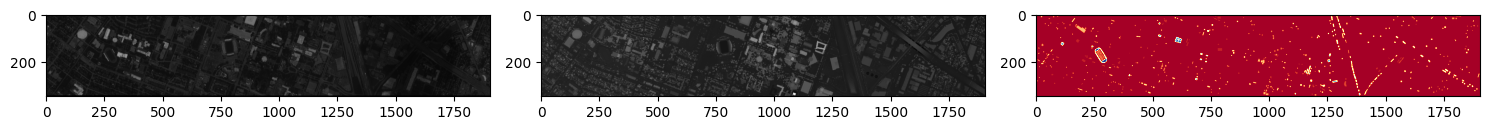

In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# path
hsi_data=hsi_2013_data
lidar_data=lidar_2013_data
gt_data=gt_2013_data
print('hsi_data shap:', hsi_data.shape)
print('lidar_data shap:', lidar_data.shape)
print('gt_data shap:', gt_data.shape)

# To plot image data, you can use matplotlib.pyplot's imshow function
# Here I'm showing the first band of the HSI data as an example. You may want to adjust this to suit your needs.

# To plot image data, you can use matplotlib.pyplot's imshow function
# Here I'm showing the first band of the HSI data as an example. You may want to adjust this to suit your needs.

plt.figure(figsize=(15,5))  # Adjust the figure size

plt.subplot(1,3,1)  # Change from 2,2,1 to 1,3,1
plt.imshow(hsi_data[:,:,10], cmap='gray')
#plt.title("HSI Data - First Band")

plt.subplot(1,3,2)  # Change from 2,2,3 to 1,3,2
plt.imshow(lidar_data[:,:,0], cmap='gist_gray')
#plt.title("LiDAR Data - First Band")

plt.subplot(1,3,3)  # Change from 2,2,4 to 1,3,3
plt.imshow(gt_data, cmap='RdYlBu')
#plt.title("Ground Truth")

plt.tight_layout()  # Use tight_layout to ensure that the subplots do not overlap
plt.show()

# 2.0 Data Preprocessing & Dataloader Preparation

In [ ]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 1251),
    (2, "Stressed grass", 1254),
    (3, "Synthetic grass", 697),
    (4, "Trees", 1244),
    (5, "Soil", 1242),
    (6, "Water", 325),
    (7, "Residential", 1268),
    (8, "Commercial", 1244),
    (9, "Road", 1252),
    (10, "Highway", 1227),
    (11, "Railway", 1235),
    (12, "Parking lot 1", 1233),
    (13, "Parking lot 2", 469),
    (14, "Tennis court", 428),
    (15, "Running track", 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name, "samples": samples} for class_number, class_name, samples in class_info}

print(class_dict)

{1: {'class_name': 'Healthy grass', 'samples': 1251}, 2: {'class_name': 'Stressed grass', 'samples': 1254}, 3: {'class_name': 'Synthetic grass', 'samples': 697}, 4: {'class_name': 'Trees', 'samples': 1244}, 5: {'class_name': 'Soil', 'samples': 1242}, 6: {'class_name': 'Water', 'samples': 325}, 7: {'class_name': 'Residential', 'samples': 1268}, 8: {'class_name': 'Commercial', 'samples': 1244}, 9: {'class_name': 'Road', 'samples': 1252}, 10: {'class_name': 'Highway', 'samples': 1227}, 11: {'class_name': 'Railway', 'samples': 1235}, 12: {'class_name': 'Parking lot 1', 'samples': 1233}, 13: {'class_name': 'Parking lot 2', 'samples': 469}, 14: {'class_name': 'Tennis court', 'samples': 428}, 15: {'class_name': 'Running track', 'samples': 660}}


### 2.1  Samples Extraction

In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)


###2.15 Visualisation Different Band Selection Methods Maps

### 2.2 Training samples extraction

In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
#training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]
training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

training_hsi_samples = np.array(training_hsi_samples)
training_lidar_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', training_hsi_samples.shape)
print('training_lidar_samples shape:', training_lidar_samples.shape)
print('training_labels shape:', training_labels.shape)

training_hsi_samples shape: (150, 9, 9, 144)
training_lidar_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)


In [ ]:
# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (150, 9, 9, 144)
lidar_training_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


### 2.3.0 Band Selection based on New Criterion N=50000, Hight Attention+ high dissimilarity

In [ ]:
# p=3, n=50000, sgd, lr=0.0001
top_1_seed42=  [37]
top_5_seed42= [14, 78, 92, 51, 37]
top_10_seed42= [110, 76, 37, 109, 128, 90, 21, 78, 27, 1]
top_15_seed42=[64, 80, 109, 45, 90, 133, 30, 27, 89, 37, 0, 83, 21, 53, 130]
top_20_seed42= [52, 80, 83, 78, 117, 70, 27, 0, 37, 125, 24, 90, 15, 63, 109, 21, 45, 67, 113, 76]
top_25_seed42= [53, 80, 117, 109, 50, 24, 125, 55, 37, 27, 58, 78, 82, 77, 21, 107, 92, 0, 45, 30, 15, 76, 90, 73, 83]
top_30_seed42= [50, 125, 3, 18, 53, 15, 8, 30, 80, 27, 37, 24, 63, 0, 55, 21, 117, 76, 107, 73, 58, 92, 59, 45, 108, 121, 130, 109, 101, 94]
top_35_seed42= [87, 80, 117, 121, 50, 137, 125, 55, 37, 27, 67, 59, 63, 77, 21, 107, 92, 0, 45, 128, 15, 130, 90, 73, 3, 101, 24, 108, 25, 109, 103, 76, 8, 30, 18]
top_40_seed42= [59, 101, 76, 83, 58, 27, 117, 37, 73, 108, 90, 125, 40, 137, 109, 30, 107, 45, 14, 15, 92, 110, 80, 8, 77, 2, 21, 31, 130, 28, 18, 87, 3, 24, 55, 121, 67, 10, 51, 82]
top_45_seed42= [14, 107, 30, 35, 109, 125, 50, 16, 45, 89, 27, 37, 15, 103, 108, 130, 18, 121, 90, 73, 92, 117, 101, 21, 76, 137, 59, 80, 135, 55, 39, 67, 71, 124, 128, 8, 83, 87, 28, 0, 139, 141, 10, 24, 102]
top_50_seed42= [92, 40, 87, 117, 121, 125, 137, 58, 37, 27, 90, 107, 108, 59, 63, 3, 45, 80, 15, 128, 73, 76, 8, 0, 35, 113, 18, 21, 130, 101, 51, 109, 55, 50, 77, 1, 67, 84, 83, 141, 30, 103, 24, 10, 133, 14, 124, 39, 78, 5]

In [ ]:
# p=3, n=50000, adm lr=0.0001
top_1_seed42=  [50]
top_5_seed42= [34, 53, 137, 110, 50]
top_10_seed42= [59, 109, 63, 50, 28, 81, 139, 51, 15, 46]
top_15_seed42=[139, 69, 124, 51, 50, 87, 28, 59, 46, 6, 80, 78, 92, 109, 34]
top_20_seed42= [15, 141, 52, 4, 34, 69, 50, 139, 27, 124, 46, 28, 84, 81, 123, 128, 74, 67, 108, 59]
top_25_seed42= [46, 126, 51, 92, 139, 9, 33, 52, 123, 40, 58, 63, 57, 69, 15, 53, 28, 59, 27, 128, 67, 56, 50, 29, 39]
top_30_seed42= [30, 56, 34, 97, 124, 45, 81, 67, 108, 46, 52, 40, 41, 33, 51, 59, 69, 126, 27, 86, 50, 15, 123, 134, 138, 48, 115, 139, 128, 96]
top_35_seed42= [126, 14, 28, 123, 34, 40, 96, 90, 46, 142, 44, 43, 27, 15, 50, 128, 92, 30, 78, 63, 23, 69, 59, 82, 134, 143, 33, 108, 32, 41, 22, 97, 139, 56, 113]
top_40_seed42= [90, 45, 139, 117, 69, 93, 5, 51, 111, 44, 127, 59, 27, 87, 92, 141, 143, 40, 22, 123, 28, 30, 80, 33, 58, 84, 126, 46, 29, 82, 124, 119, 17, 96, 78, 23, 74, 50, 97, 63]
top_45_seed42= [46, 141, 138, 80, 88, 123, 126, 50, 27, 62, 111, 28, 96, 134, 33, 52, 40, 129, 69, 139, 84, 92, 59, 105, 85, 113, 45, 63, 41, 79, 30, 97, 44, 42, 39, 51, 107, 43, 48, 9, 93, 78, 143, 87, 15]
top_50_seed42= [116, 123, 86, 28, 114, 96, 140, 51, 127, 27, 44, 90, 117, 59, 30, 50, 108, 33, 113, 80, 69, 89, 6, 100, 124, 34, 4, 9, 97, 129, 139, 46, 107, 92, 45, 128, 143, 126, 111, 87, 40, 78, 105, 47, 93, 17, 15, 119, 104, 82]

In [ ]:
# p=5, n=50000, sgd, lr=0.0001
top_1_seed42=  [83]
top_5_seed42=  [67, 136, 34, 83, 143]
top_10_seed42=  [38, 8, 143, 136, 112, 83, 25, 131, 42, 16]
top_15_seed42= [20, 30, 138, 131, 140, 143, 16, 129, 35, 92, 83, 42, 33, 71, 8]
top_20_seed42= [8, 96, 71, 34, 20, 100, 36, 32, 83, 58, 67, 136, 91, 143, 16, 25, 7, 131, 42, 112]
top_25_seed42= [133, 139, 143, 98, 48, 32, 34, 20, 96, 108, 83, 91, 93, 44, 16, 42, 56, 136, 33, 92, 132, 131, 71, 100, 23]
top_30_seed42=  [32, 138, 71, 130, 100, 134, 50, 42, 16, 83, 132, 72, 143, 136, 91, 38, 20, 34, 48, 33, 131, 112, 39, 56, 23, 139, 44, 98, 109, 141]
top_35_seed42=  [38, 8, 20, 141, 36, 44, 131, 33, 108, 129, 16, 42, 83, 143, 138, 58, 136, 30, 100, 99, 71, 98, 56, 39, 23, 4, 32, 34, 96, 120, 48, 93, 90, 109, 110]
top_40_seed42= [23, 30, 20, 44, 29, 42, 100, 97, 56, 16, 115, 133, 132, 114, 33, 27, 143, 38, 136, 131, 91, 130, 83, 134, 98, 21, 141, 71, 39, 96, 90, 89, 109, 108, 99, 95, 40, 142, 135, 32]
top_45_seed42= [93, 108, 20, 4, 136, 143, 115, 72, 56, 16, 32, 114, 44, 100, 8, 138, 112, 58, 140, 92, 84, 83, 33, 98, 141, 39, 71, 29, 23, 49, 42, 90, 89, 91, 131, 133, 96, 109, 14, 30, 24, 135, 34, 134, 40]
top_50_seed42=[18, 30, 39, 135, 89, 91, 48, 133, 83, 98, 71, 132, 58, 104, 14, 131, 136, 20, 38, 33, 9, 56, 138, 143, 32, 44, 139, 4, 109, 27, 36, 35, 29, 96, 114, 108, 90, 23, 93, 87, 137, 16, 134, 42, 22, 49, 99, 120, 34, 100]

In [ ]:
# p=5, n=50000, adm, lr=0.0001
top_1_seed42=  [136]
top_5_seed42=  [111, 80, 17, 136, 110]
top_10_seed42=  [66, 74, 80, 60, 30, 83, 106, 8, 111, 136]
top_15_seed42=[81, 10, 74, 123, 30, 111, 83, 137, 134, 136, 60, 35, 141, 45, 66]

top_20_seed42= [137, 74, 60, 128, 81, 66, 136, 101, 100, 111, 30, 134, 105, 56, 104, 8, 35, 98, 64, 129]
top_25_seed42=  [45, 31, 124, 129, 3, 63, 76, 136, 27, 80, 60, 92, 111, 83, 30, 141, 74, 10, 132, 17, 61, 23, 86, 59, 87]
top_30_seed42=  [112, 81, 74, 3, 66, 134, 136, 45, 10, 83, 37, 100, 27, 108, 110, 128, 105, 141, 111, 35, 30, 46, 60, 17, 129, 20, 41, 64, 59, 62]
top_35_seed42= [10, 100, 111, 108, 37, 63, 66, 141, 129, 134, 3, 45, 64, 136, 9, 17, 83, 132, 46, 60, 41, 74, 105, 110, 35, 59, 30, 89, 103, 62, 125, 27, 56, 80, 51]
top_40_seed42= [78, 108, 64, 10, 132, 111, 110, 112, 37, 26, 45, 70, 141, 129, 35, 136, 118, 74, 51, 105, 17, 30, 61, 41, 60, 89, 59, 93, 3, 66, 56, 86, 80, 36, 116, 134, 62, 27, 83, 92]
top_45_seed42= [105, 59, 27, 83, 136, 116, 106, 64, 90, 35, 63, 142, 66, 108, 37, 110, 53, 129, 36, 8, 79, 74, 45, 51, 41, 92, 52, 56, 107, 3, 132, 30, 112, 61, 23, 80, 10, 60, 17, 121, 111, 104, 141, 100, 62]
top_50_seed42=[125, 107, 45, 74, 30, 110, 143, 112, 3, 118, 127, 17, 53, 56, 136, 37, 105, 38, 111, 62, 60, 27, 129, 134, 41, 9, 59, 35, 71, 29, 8, 26, 34, 10, 80, 106, 31, 64, 116, 108, 20, 101, 61, 2, 89, 124, 82, 52, 90, 66]

In [ ]:
# p=7, n=50000, sgd, lr=0.0001 HSI, LIDAR
top_1_seed42=  [51]
top_5_seed42= [65, 56, 51, 121, 113]
top_10_seed42= [6, 121, 119, 56, 71, 51, 73, 65, 108, 33]
top_15_seed42=[5, 72, 6, 128, 33, 40, 51, 35, 121, 113, 56, 3, 14, 67, 106]
top_20_seed42= [65, 108, 14, 6, 31, 33, 51, 92, 121, 35, 56, 5, 72, 17, 3, 106, 57, 133, 143, 123]
top_25_seed42= [117, 72, 129, 14, 106, 104, 122, 128, 33, 18, 121, 141, 6, 51, 15, 57, 49, 87, 108, 9, 5, 3, 56, 113, 17]
top_30_seed42=[62, 132, 128, 33, 5, 57, 9, 14, 56, 6, 51, 40, 3, 113, 117, 106, 141, 31, 122, 79, 108, 15, 103, 104, 65, 121, 111, 17, 49, 72]
top_35_seed42= [6, 128, 72, 141, 78, 121, 106, 139, 14, 31, 104, 122, 50, 131, 51, 15, 132, 57, 62, 108, 49, 9, 5, 103, 127, 56, 113, 3, 111, 40, 105, 33, 65, 53, 32]
top_40_seed42= [143, 33, 35, 3, 141, 106, 111, 104, 113, 72, 62, 138, 121, 57, 51, 18, 14, 132, 117, 6, 100, 56, 9, 15, 122, 108, 52, 31, 103, 93, 40, 5, 65, 13, 78, 71, 21, 49, 30, 10]
top_45_seed42= [125, 132, 29, 51, 104, 60, 14, 57, 122, 33, 49, 32, 121, 106, 10, 70, 108, 40, 98, 103, 56, 79, 9, 53, 31, 17, 5, 3, 72, 131, 35, 6, 113, 65, 38, 111, 78, 2, 13, 15, 141, 143, 63, 138, 89]
top_50_seed42= [97, 132, 52, 78, 106, 138, 79, 121, 14, 18, 56, 122, 6, 51, 108, 141, 57, 49, 9, 98, 125, 31, 103, 3, 104, 127, 1, 93, 111, 5, 40, 65, 143, 124, 72, 113, 63, 110, 13, 96, 117, 35, 123, 29, 70, 33, 10, 15, 60, 38]

In [ ]:
# p=7, n=50000, adm, lr=0.0001 HSI0.5, LIDAR 0.5
top_1_seed42=  [41]
top_5_seed42= [43, 104, 5, 41, 88]
top_10_seed42= [41, 86, 56, 5, 1, 15, 81, 42, 58, 64]
top_15_seed42=[96, 32, 33, 84, 2, 79, 46, 58, 5, 56, 88, 100, 51, 10, 41]
top_20_seed42= [96, 119, 89, 127, 41, 17, 135, 33, 10, 2, 79, 51, 88, 5, 28, 49, 56, 113, 32, 36]
top_25_seed42= [71, 120, 51, 18, 17, 41, 113, 36, 117, 119, 79, 43, 88, 10, 2, 5, 8, 29, 84, 28, 33, 123, 122, 32, 56]
top_30_seed42= [29, 2, 56, 51, 79, 33, 0, 96, 113, 84, 88, 77, 41, 141, 119, 18, 37, 17, 66, 8, 71, 135, 86, 63, 10, 123, 7, 32, 5, 74]

top_35_seed42= [37, 135, 88, 79, 10, 84, 51, 71, 43, 126, 86, 98, 32, 29, 80, 41, 123, 17, 49, 56, 127, 42, 120, 96, 18, 5, 0, 63, 50, 8, 110, 7, 62, 36, 33]
top_40_seed42= [33, 123, 42, 2, 84, 77, 17, 98, 41, 86, 10, 58, 5, 1, 71, 56, 18, 51, 43, 37, 96, 29, 64, 79, 0, 113, 126, 6, 110, 132, 63, 88, 8, 15, 141, 7, 62, 32, 135, 101]
top_45_seed42=  [86, 126, 42, 84, 71, 81, 1, 135, 60, 41, 93, 77, 29, 0, 66, 113, 5, 56, 37, 32, 96, 79, 17, 10, 36, 33, 51, 6, 15, 8, 49, 9, 18, 62, 58, 12, 88, 63, 110, 7, 141, 43, 101, 129, 122]
top_50_seed42=  [18, 66, 135, 79, 1, 43, 9, 132, 113, 104, 71, 84, 45, 96, 62, 63, 58, 10, 81, 29, 51, 37, 5, 0, 2, 88, 42, 56, 17, 6, 32, 75, 110, 15, 41, 33, 134, 8, 54, 86, 120, 141, 49, 119, 93, 101, 143, 7, 122, 127]

In [ ]:
# p=9, n=50000, sgd, lr=0.0001
top_1_seed42=  [48]
top_5_seed42= [71, 95, 48, 19, 63]
top_10_seed42= [85, 30, 92, 37, 20, 2, 77, 49, 109, 108]
top_15_seed42=[77, 44, 113, 37, 45, 117, 109, 108, 20, 123, 125, 134, 49, 10, 104]
top_20_seed42= [142, 42, 33, 37, 107, 45, 123, 126, 67, 128, 108, 85, 49, 20, 69, 125, 86, 30, 26, 139]
top_25_seed42= [36, 142, 30, 20, 33, 37, 85, 56, 108, 26, 77, 49, 139, 57, 123, 83, 125, 42, 126, 13, 51, 91, 45, 64, 96]
top_30_seed42= [142, 60, 83, 92, 85, 30, 43, 96, 20, 29, 91, 53, 87, 126, 45, 139, 108, 123, 33, 37, 140, 42, 15, 63, 49, 51, 117, 72, 129, 10]
top_35_seed42= [117, 123, 85, 83, 128, 129, 108, 96, 45, 140, 142, 42, 105, 43, 37, 30, 29, 56, 33, 77, 60, 20, 139, 51, 72, 36, 118, 126, 91, 80, 26, 16, 49, 75, 67]
top_40_seed42= [104, 42, 90, 83, 45, 15, 49, 51, 140, 56, 60, 77, 30, 139, 108, 37, 123, 129, 128, 64, 43, 57, 29, 79, 95, 73, 20, 85, 142, 78, 16, 91, 36, 119, 26, 44, 117, 10, 126, 109]
top_45_seed42= [90, 96, 30, 45, 37, 80, 142, 91, 64, 26, 60, 117, 84, 10, 83, 33, 139, 106, 43, 44, 125, 105, 16, 51, 63, 56, 57, 85, 108, 129, 140, 123, 49, 42, 29, 95, 36, 15, 109, 126, 53, 22, 128, 94, 20]
top_50_seed42= [80, 142, 51, 72, 108, 94, 83, 125, 30, 126, 77, 117, 44, 106, 43, 37, 128, 123, 45, 85, 89, 139, 29, 60, 91, 36, 140, 49, 114, 15, 26, 56, 105, 16, 90, 10, 42, 19, 100, 57, 64, 20, 69, 33, 109, 129, 84, 17, 113, 7]

In [ ]:
# p=9, n=50000, adm, lr=0.0001
top_1_seed42=  [107]
top_5_seed42= [73, 117, 107, 89, 34]
top_10_seed42= [85, 10, 137, 107, 34, 59, 47, 140, 117, 108]
top_15_seed42=[94, 119, 107, 17, 57, 117, 59, 47, 3, 34, 10, 140, 85, 58, 137]
top_20_seed42=[3, 5, 17, 33, 85, 59, 117, 140, 94, 57, 108, 71, 41, 136, 107, 34, 58, 24, 51, 123]
top_25_seed42= [10, 117, 30, 140, 107, 34, 15, 85, 41, 119, 95, 35, 96, 137, 58, 1, 60, 136, 108, 143, 57, 59, 5, 123, 3]
top_30_seed42= [1, 108, 141, 51, 95, 49, 60, 47, 80, 10, 132, 12, 119, 137, 106, 15, 41, 34, 3, 107, 57, 58, 136, 140, 59, 5, 131, 94, 85, 117]
top_35_seed42= [10, 129, 30, 140, 107, 34, 15, 85, 41, 119, 95, 13, 51, 137, 58, 1, 60, 136, 108, 143, 31, 59, 141, 123, 3, 131, 57, 47, 132, 70, 2, 49, 5, 117, 124]
top_40_seed42= [10, 129, 30, 140, 107, 34, 15, 85, 56, 119, 42, 13, 51, 137, 58, 1, 60, 136, 108, 143, 12, 59, 141, 123, 3, 131, 57, 47, 132, 70, 2, 49, 5, 117, 124, 31, 77, 95, 22, 41]
top_45_seed42=[123, 129, 3, 141, 34, 30, 70, 2, 59, 26, 85, 17, 77, 108, 137, 47, 95, 107, 31, 58, 51, 57, 36, 13, 10, 136, 12, 131, 143, 60, 124, 5, 140, 1, 117, 132, 119, 91, 41, 49, 42, 135, 22, 74, 9]

top_50_seed42= [113, 141, 95, 34, 46, 85, 129, 74, 137, 63, 83, 26, 107, 106, 12, 1, 13, 51, 58, 108, 10, 70, 136, 57, 91, 36, 60, 5, 143, 30, 131, 117, 41, 140, 59, 115, 27, 47, 119, 31, 3, 130, 17, 42, 132, 49, 2, 142, 124, 54]

In [ ]:
# p=11, n=50000, sgd, lr=0.0001
top_1_seed42=  [69]
top_5_seed42= [69, 76, 65, 84, 127]
top_10_seed42= [75, 83, 68, 27, 76, 69, 65, 84, 86, 46]
top_15_seed42=[132, 52, 85, 76, 83, 84, 69, 92, 28, 86, 7, 12, 1, 126, 27]
top_20_seed42= [16, 52, 28, 6, 76, 25, 39, 83, 41, 84, 74, 69, 60, 7, 122, 12, 27, 114, 1, 126]
top_25_seed42= [86, 4, 60, 27, 68, 76, 87, 131, 12, 69, 74, 28, 39, 16, 119, 52, 123, 135, 120, 126, 99, 84, 139, 1, 83]
top_30_seed42= [69, 122, 131, 16, 74, 76, 119, 54, 132, 1, 126, 8, 27, 139, 99, 86, 52, 84, 87, 4, 79, 96, 101, 39, 105, 83, 65, 7, 28, 123]
top_35_seed42= [75, 99, 65, 27, 60, 51, 76, 131, 7, 114, 79, 139, 134, 68, 39, 10, 120, 4, 132, 85, 52, 111, 84, 69, 8, 86, 12, 83, 1, 74, 123, 43, 28, 41, 101]
top_40_seed42= [10, 7, 131, 111, 11, 27, 85, 76, 54, 121, 4, 26, 52, 69, 86, 84, 1, 39, 48, 120, 74, 79, 65, 60, 8, 99, 122, 114, 83, 92, 87, 123, 104, 12, 51, 25, 28, 139, 106, 37]
top_45_seed42= [120, 143, 131, 139, 10, 76, 95, 54, 52, 86, 74, 42, 8, 103, 27, 25, 63, 26, 84, 39, 99, 22, 7, 28, 83, 132, 11, 4, 79, 65, 105, 1, 47, 109, 114, 104, 12, 122, 41, 51, 134, 69, 123, 48, 29]
top_50_seed42= [48, 99, 119, 76, 8, 79, 30, 51, 105, 27, 11, 121, 84, 65, 87, 131, 10, 47, 67, 52, 122, 83, 71, 39, 31, 108, 7, 69, 1, 132, 74, 12, 123, 72, 16, 25, 28, 139, 60, 120, 134, 4, 38, 54, 104, 103, 86, 107, 5, 143]

In [ ]:
# p=13, n=20000, sgd, lr=0.0001
top_1_seed42=  [34]
top_5_seed42= [9, 34, 97, 1, 3]
top_10_seed42= [141, 50, 97, 113, 1, 119, 34, 9, 6, 133]
top_15_seed42=[90, 34, 79, 0, 119, 98, 123, 1, 72, 139, 30, 133, 97, 96, 75]
top_20_seed42= [89, 137, 9, 123, 53, 131, 34, 133, 88, 75, 119, 121, 113, 29, 20, 97, 30, 54, 1, 111]
top_25_seed42= [88, 54, 30, 123, 20, 111, 67, 72, 119, 97, 133, 1, 113, 89, 137, 34, 121, 0, 6, 107, 81, 50, 57, 14, 42]
top_30_seed42= [1, 64, 30, 123, 67, 42, 72, 121, 54, 79, 119, 97, 14, 74, 113, 27, 138, 6, 81, 0, 34, 107, 50, 137, 85, 9, 40, 111, 133, 129]
top_35_seed42= [67, 138, 97, 85, 81, 121, 119, 27, 42, 50, 1, 6, 123, 79, 113, 89, 0, 72, 60, 111, 54, 107, 66, 133, 76, 10, 14, 9, 40, 34, 86, 137, 30, 94, 82]
top_40_seed42= [35, 138, 40, 123, 0, 107, 121, 72, 119, 97, 139, 42, 79, 94, 27, 1, 67, 60, 90, 6, 133, 30, 66, 64, 54, 9, 29, 34, 111, 137, 85, 36, 14, 131, 82, 113, 95, 89, 33, 8]
top_45_seed42= [72, 97, 137, 64, 23, 119, 30, 133, 68, 139, 20, 123, 60, 113, 67, 40, 6, 96, 1, 9, 88, 36, 66, 42, 95, 27, 121, 76, 34, 107, 89, 75, 54, 79, 33, 0, 90, 74, 12, 14, 85, 131, 29, 140, 111]
top_50_seed42= [132, 89, 20, 119, 99, 67, 123, 3, 40, 111, 42, 12, 97, 137, 121, 9, 98, 36, 23, 34, 139, 133, 113, 1, 76, 66, 62, 54, 75, 27, 74, 129, 79, 85, 82, 131, 72, 0, 6, 78, 13, 14, 30, 94, 140, 107, 81, 41, 86, 37]

In [ ]:
#20000 Samples SSIM
bands_ssim_1=[102]
bands_ssim_5=[92, 126, 0, 76, 117]
bands_ssim_10=[143, 64, 46, 79, 84, 105, 52, 110, 121, 123]
bands_ssim_15=[139, 93, 110, 129, 56, 79, 18, 119, 40, 58, 13, 123, 51, 23, 45]
bands_ssim_20=[19, 8, 87, 12, 104, 143, 5, 128, 56, 79, 61, 64, 67, 137, 38, 35, 81, 133, 63, 31]
bands_ssim_25=[45, 71, 105, 82, 110, 81, 100, 86, 13, 133, 91, 138, 39, 19, 114, 102, 109, 14, 124, 131, 104, 31, 22, 50, 111]
bands_ssim_30=[18, 13, 12, 36, 127, 5, 91, 2, 35, 78, 49, 139, 132, 77, 43, 128, 93, 116, 96, 138, 54, 69, 10, 67, 23, 100, 34, 102, 27, 15]
bands_ssim_35=[86, 78, 25, 35, 10, 136, 139, 133, 81, 38, 54, 124, 0, 76, 48, 39, 132, 18, 95, 126, 4, 116, 14, 100, 109, 120, 115, 73, 108, 70, 3, 140, 36, 135, 110]
bands_ssim_40=[95, 45, 140, 14, 119, 7, 136, 90, 129, 39, 58, 116, 114, 51, 34, 96, 100, 128, 48, 43, 93, 56, 19, 81, 26, 5, 143, 110, 28, 103, 133, 105, 25, 104, 59, 83, 92, 63, 84, 88]
bands_ssim_45=[107, 52, 97, 98, 33, 0, 28, 27, 89, 35, 54, 39, 9, 31, 4, 119, 90, 99, 51, 129, 43, 105, 58, 24, 127, 70, 61, 22, 93, 101, 37, 49, 130, 141, 104, 60, 84, 69, 12, 92, 117, 116, 42, 82, 32]
bands_ssim_50=[118, 61, 41, 47, 19, 23, 8, 73, 131, 72, 99, 81, 121, 36, 143, 78, 135, 139, 13, 108, 141, 113, 2, 90, 48, 74, 71, 57, 86, 9, 109, 11, 112, 137, 34, 136, 20, 45, 115, 24, 100, 14, 7, 26, 128, 52, 134, 21, 114, 56]

In [ ]:
#band_ASPS_22=[2,13,18,26,27,42,44,57,60,68,69,79,88,91,101,105,110,116,126,127,135,137]
bands_asps=[2, 5, 7, 16, 1, 47, 34, 42, 10, 38, 49, 15, 18, 17, 13, 19, 20, 14, 9, 12, 11, 22, 8, 6, 4, 3, 21, 24, 23, 48, 46, 45, 44, 43, 41, 40, 39, 37, 36, 35, 33, 32, 31, 30, 29, 28, 27, 26, 25, 0]

In [ ]:
# opbs band selection obtained on 09232023
#bands_opbs=[ 51,  87,  21, 143,  67,   8,  40,  75, 133 , 84 ,100 ,142, 130,  29,  46,  16,  73, 141,109, 140,  63,  83,  68,  30, 139,  97,   0, 138,  56, 136]
bands_opbs=[51, 87, 21, 143, 67, 8, 40, 75, 133, 84, 100, 142, 130, 29, 46, 16, 73, 141, 109, 140, 63, 83, 68, 30, 139, 97, 0, 138, 56, 136, 79, 14, 137, 117, 28, 131, 17, 69, 47, 33, 92, 135, 134, 3, 72, 127, 50, 128, 11, 132]

In [ ]:
#TRC_OC_FDPC
bands_trc=[47, 27, 16, 40, 35, 5, 31, 18, 15, 21, 26, 7, 9, 36, 3, 17, 48, 11, 69, 4, 33, 32, 75, 68, 70, 142, 72, 73, 74, 143, 76, 77, 78, 79, 80, 81, 82, 66, 67, 55, 65, 64, 49, 50, 51, 52, 53, 54, 84, 56]

In [ ]:
# LRR_BS
#bands_lrr=[67, 143, 45, 51, 50, 49, 48, 47, 46, 44, 53, 43, 42, 41, 39, 38, 37, 52, 54, 35, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 36, 34, 142, 8, 14, 13, 12, 11, 10, 9, 7, 16, 6, 5, 4, 3]

In [ ]:
#UH2013 RRI
band_RRI_50=[3, 11, 4, 14, 15, 9, 12, 0, 16, 5, 6, 13, 17, 18, 19, 126, 20, 68, 69, 125, 119, 10, 21, 26, 24, 124, 22, 27, 123, 122, 23, 30, 8, 70, 67, 28, 25, 29, 66, 61, 62, 65, 31, 60, 64, 1, 63, 32, 59, 121]

In [ ]:
rlffc=[29,93,124,54,14,108,97,6,135,43,130,73,80,118,41,22,111,88,60,35,70,74,83,19,11,102,57,9,47,45,37,100,12,32,25,52,120,17,77,51,95,72,105,79,64,90,76,20,68,50]

In [ ]:
# Generate a list of indices for the 144 bands
full_bands = list(range(144))

# Print the list of band indices
print("Band Indices:", full_bands)

Band Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


#  Method 1 SVM for Singlie output

In [ ]:
# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)


hsi_training_samples shape: (150, 9, 9, 144)
lidar_training_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


In [ ]:
#FullHSIbands
selected_hsi_samples=hsi_samples
print('selected_hsi_samples shape:', selected_hsi_samples.shape)

selected_hsi_training_samples = hsi_training_samples
print('selected_hsi_training_samples shape:', selected_hsi_training_samples.shape)

#Adding LiDAR Data to Reduced bands HSI Data
# Concatenate the data
selected_hsi_samples  = np.concatenate([selected_hsi_samples, lidar_samples], axis=3)
selected_hsi_training_samples  = np.concatenate([selected_hsi_training_samples, lidar_training_samples], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples .shape)
print('selected_hsi_training_samples shape:', selected_hsi_training_samples.shape)


selected_hsi_samples shape: (15029, 9, 9, 144)
selected_hsi_training_samples shape: (150, 9, 9, 144)
selected_hsi_samples shape: (15029, 9, 9, 145)
selected_hsi_training_samples shape: (150, 9, 9, 145)


In [ ]:
# Define the band indices you're interested in
#band_indices = bands_p9[:144]
band_indices= top_10_seed42
#band_indices=bands_asps_50[:35]
#band_indices=bands_opbs[:50]
#band_indices=bands_bsnet[:35]
#band_indices=bands_trc[:1]
# Extract the corresponding bands from the HSI samples
selected_hsi_samples = hsi_samples[:,:,:, band_indices]
print('selected_hsi_samples shape:', selected_hsi_samples.shape)

# Training Samples
selected_hsi_training_samples = hsi_training_samples[:,:,:, band_indices]
print('selected_hsi_training_samples shape:', selected_hsi_training_samples.shape)

#Adding LiDAR Data to Reduced bands HSI Data
# Concatenate the data
selected_hsi_samples  = np.concatenate([selected_hsi_samples, lidar_samples], axis=3)
selected_hsi_training_samples  = np.concatenate([selected_hsi_training_samples, lidar_training_samples], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples .shape)
print('selected_hsi_training_samples shape:', selected_hsi_training_samples.shape)


selected_hsi_samples shape: (15029, 9, 9, 10)
selected_hsi_training_samples shape: (150, 9, 9, 10)
selected_hsi_samples shape: (15029, 9, 9, 11)
selected_hsi_training_samples shape: (150, 9, 9, 11)


In [ ]:
import numpy as np
import scipy.io as sio
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, cohen_kappa_score

# Step 1: Read data
data = selected_hsi_samples
labels = labels
X = data # Input data
y = labels# Ground truth labels
X.shape
print('X.shape:',X.shape)

# Step 2 Resahoe data
X_train=selected_hsi_training_samples
n_samples, n_width, n_height, n_bands = X_train.shape
X_train=selected_hsi_training_samples.reshape((n_samples, n_width*n_height*n_bands))
X_train.shape
print('X_train.shape:',X_train.shape)

n_samples, n_width, n_height, n_bands = X.shape
# Step 3 Resahoe data
X_2d = X.reshape((n_samples, n_width*n_height*n_bands))
X_2d.shape
print('X_2d.shape:',X_2d.shape)

y=y.ravel()
y.shape
print('y.shape:',y.shape)

# Step 4: Split data into training and testing sets
from sklearn.model_selection import train_test_split

# The desired number of samples for each class
training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]

# Get the indices of the samples that are not in the training set
test_indices = np.setdiff1d(np.arange(len(labels)), np.arange(len(training_labels)))

# Extract the testing samples and labels
test_selected_hsi_samples = selected_hsi_samples[test_indices]
test_labels = labels[test_indices]

# Now, let's reshape the data for the SVM classifier
# SVM requires 2D input, so we need to flatten the patch dimensions

nsamples, nx, ny, nz = selected_hsi_training_samples.shape
X_train = selected_hsi_training_samples.reshape((nsamples, nx*ny*nz))
y_train = training_labels

nsamples, nx, ny, nz = test_selected_hsi_samples .shape
X_test = test_selected_hsi_samples .reshape((nsamples, nx*ny*nz))
y_test = test_labels

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X.shape: (15029, 9, 9, 11)
X_train.shape: (150, 891)
X_2d.shape: (15029, 891)
y.shape: (15029,)
X_train shape: (150, 891)
y_train shape: (150,)
X_test shape: (14879, 891)
y_test shape: (14879,)


# Method 1 SVM Verification

In [ ]:
from sklearn.preprocessing import StandardScaler
import re
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
#from tqdm import tqdm

band_indices= top_10_seed42
# Extract the corresponding bands from the HSI training and test samples
selected_hsi_train = hsi_training_samples[:,:,:,band_indices]
selected_hsi_test = hsi_test_samples[:,:,:,band_indices]

#Method 1: HSI+LiDAR
selected_hsi_lidar_train = np.concatenate([selected_hsi_train, lidar_training_samples], axis=3)
selected_hsi_lidar_test = np.concatenate([selected_hsi_test, lidar_test_samples], axis=3)
X_train=selected_hsi_lidar_train
X_test=selected_hsi_lidar_test
y_train = training_labels
y_test = test_labels

#oa, aa, kappa = evaluate_svm_with_bands(selected_hsi_lidar_train, training_labels, selected_hsi_lidar_test, test_labels)
#results_hsi_lidar[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
#print(f"HSI+LiDAR - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")

#def evaluate_svm_with_bands(X_train, y_train, X_test, y_test):
    # Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

# Initialize and train SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale')
svm_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate metrics
oa = accuracy_score(y_test, y_pred)
aa = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print('Overall accuracy:', oa)
print('Average accuracy:', aa)
print('kappa :', kappa)

# Generate classification report
report = classification_report(y_test, y_pred)

# Function to reformat floating-point numbers in the classification report
def reformat_report(report):
    # Find all floating-point numbers in the report and reformat them
    formatted_report = re.sub(r"(\d+\.\d+)", lambda x: f"{float(x.group()):.4f}", report)
    return formatted_report

# Print the reformatted classification report
print(reformat_report(report))

Overall accuracy: 0.6298810403924995
Average accuracy: 0.6531744071769163
kappa : 0.6013823115294468
              precision    recall  f1-score   support

           1       0.7000      0.8300      0.7600      1101
           2       0.5500      0.6700      0.6000      1254
           3       0.3500      0.8100      0.4900       697
           4       0.9000      0.7900      0.8400      1244
           5       0.8400      0.7200      0.7800      1242
           6       0.6000      0.5700      0.5900       325
           7       0.8100      0.7500      0.7800      1268
           8       0.7700      0.6000      0.6700      1244
           9       0.4900      0.6900      0.5800      1252
          10       0.4500      0.1300      0.2000      1227
          11       0.5000      0.5300      0.5100      1235
          12       0.6800      0.2900      0.4100      1233
          13       0.7500      0.7100      0.7300       469
          14       0.4500      0.8600      0.5900       428
    

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from tqdm import tqdm

def evaluate_svm_with_bands(X_train, y_train, X_test, y_test):
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

    # Initialize and train SVM classifier
    svm_classifier = SVC(kernel='rbf', gamma='scale')
    svm_classifier.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = svm_classifier.predict(X_test_scaled)

    # Calculate metrics
    oa = accuracy_score(y_test, y_pred)
    aa = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    return oa, aa, kappa

# Loop over different sets of band indices
band_indices_sets = [top_1_seed42, top_5_seed42, top_10_seed42, top_15_seed42, top_20_seed42, top_25_seed42, top_30_seed42, top_35_seed42, top_40_seed42, top_45_seed42, top_50_seed42]
#band_indices_sets = [top_1_seed0, top_5_seed0, top_10_seed0, top_15_seed0, top_20_seed0, top_25_seed0, top_30_seed0, top_35_seed0, top_40_seed0, top_45_seed0, top_50_seed0]
#band_indices_sets = [top_1_seed123, top_5_seed123, top_10_seed123, top_15_seed123, top_20_seed123, top_25_seed123, top_30_seed123, top_35_seed123, top_40_seed123, top_45_seed123, top_50_seed123]
#band_indices_sets = [bands_ssim_1, bands_ssim_5, bands_ssim_10, bands_ssim_15, bands_ssim_20, bands_ssim_25, bands_ssim_30, bands_ssim_35, bands_ssim_40, bands_ssim_45, bands_ssim_50]
#band_indices_sets= [bands_asps[:1],bands_asps[:5],bands_asps[:10],bands_asps[:15],bands_asps[:20],bands_asps[:25],bands_asps[:30],bands_asps[:35],bands_asps[:40],bands_asps[:45],bands_asps[:50]]
#band_indices_sets= [bands_opbs[:1],bands_opbs[:5],bands_opbs[:10],bands_opbs[:15],bands_opbs[:20],bands_opbs[:25],bands_opbs[:30],bands_opbs[:35],bands_opbs[:40],bands_opbs[:45],bands_opbs[:50]]
#band_indices_sets= [bands_trc[:1],bands_trc[:5],bands_trc[:10],bands_trc[:15],bands_trc[:20],bands_trc[:25],bands_trc[:30],bands_trc[:35],bands_trc[:40],bands_trc[:45],bands_trc[:50]]
#band_indices_sets= [band_RRI_50[:1],band_RRI_50[:5],band_RRI_50[:10],band_RRI_50[:15],band_RRI_50[:20],band_RRI_50[:25],band_RRI_50[:30],band_RRI_50[:35],band_RRI_50[:40],band_RRI_50[:45],band_RRI_50[:50]]
#band_indices_sets= [rlffc[:1],rlffc[:5],rlffc[:10],rlffc[:15],rlffc[:20], rlffc[:25],rlffc[:30],rlffc[:35],rlffc[:40],rlffc[:45],rlffc[:50]]
#band_indices_sets = [full_bands[:10], full_bands[:50],full_bands[:144]]


# Loop over different sets of band indices with a progress bar
results_hsi_lidar = {}
results_hsi_only = {}

for band_indices in tqdm(band_indices_sets, desc="Processing"):
    # Extract the corresponding bands from the HSI training and test samples
    selected_hsi_train = hsi_training_samples[:,:,:,band_indices]
    selected_hsi_test = hsi_test_samples[:,:,:,band_indices]

    #Method 1: HSI+LiDAR
    selected_hsi_lidar_train = np.concatenate([selected_hsi_train, lidar_training_samples], axis=3)
    selected_hsi_lidar_test = np.concatenate([selected_hsi_test, lidar_test_samples], axis=3)
    oa, aa, kappa = evaluate_svm_with_bands(selected_hsi_lidar_train, training_labels, selected_hsi_lidar_test, test_labels)
    results_hsi_lidar[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    print(f"HSI+LiDAR - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")

    # # Method 2: HSI only
    # oa, aa, kappa = evaluate_svm_with_bands(selected_hsi_train, training_labels, selected_hsi_test, test_labels)
    # results_hsi_only[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    # print(f"HSI Only - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")



Processing:   9%|▉         | 1/11 [00:00<00:05,  1.84it/s]

HSI+LiDAR - Band indices [48]: OA=0.4055, AA=0.4123, Kappa=0.3641


Processing:  18%|█▊        | 2/11 [00:01<00:07,  1.17it/s]

HSI+LiDAR - Band indices [71, 95, 48, 19, 63]: OA=0.5857, AA=0.6064, Kappa=0.5543


Processing:  27%|██▋       | 3/11 [00:03<00:10,  1.32s/it]

HSI+LiDAR - Band indices [85, 30, 92, 37, 20, 2, 77, 49, 109, 108]: OA=0.6299, AA=0.6532, Kappa=0.6014


Processing:  36%|███▋      | 4/11 [00:05<00:12,  1.76s/it]

HSI+LiDAR - Band indices [77, 44, 113, 37, 45, 117, 109, 108, 20, 123, 125, 134, 49, 10, 104]: OA=0.6136, AA=0.6324, Kappa=0.5839


Processing:  45%|████▌     | 5/11 [00:09<00:14,  2.44s/it]

HSI+LiDAR - Band indices [142, 42, 33, 37, 107, 45, 123, 126, 67, 128, 108, 85, 49, 20, 69, 125, 86, 30, 26, 139]: OA=0.6180, AA=0.6368, Kappa=0.5885


Processing:  55%|█████▍    | 6/11 [00:13<00:14,  2.94s/it]

HSI+LiDAR - Band indices [36, 142, 30, 20, 33, 37, 85, 56, 108, 26, 77, 49, 139, 57, 123, 83, 125, 42, 126, 13, 51, 91, 45, 64, 96]: OA=0.6202, AA=0.6400, Kappa=0.5910


Processing:  64%|██████▎   | 7/11 [00:19<00:15,  3.83s/it]

HSI+LiDAR - Band indices [142, 60, 83, 92, 85, 30, 43, 96, 20, 29, 91, 53, 87, 126, 45, 139, 108, 123, 33, 37, 140, 42, 15, 63, 49, 51, 117, 72, 129, 10]: OA=0.6151, AA=0.6352, Kappa=0.5855


Processing:  73%|███████▎  | 8/11 [00:25<00:13,  4.54s/it]

HSI+LiDAR - Band indices [117, 123, 85, 83, 128, 129, 108, 96, 45, 140, 142, 42, 105, 43, 37, 30, 29, 56, 33, 77, 60, 20, 139, 51, 72, 36, 118, 126, 91, 80, 26, 16, 49, 75, 67]: OA=0.6066, AA=0.6282, Kappa=0.5764


Processing:  82%|████████▏ | 9/11 [00:32<00:10,  5.48s/it]

HSI+LiDAR - Band indices [104, 42, 90, 83, 45, 15, 49, 51, 140, 56, 60, 77, 30, 139, 108, 37, 123, 129, 128, 64, 43, 57, 29, 79, 95, 73, 20, 85, 142, 78, 16, 91, 36, 119, 26, 44, 117, 10, 126, 109]: OA=0.6021, AA=0.6250, Kappa=0.5718


Processing:  91%|█████████ | 10/11 [00:40<00:06,  6.22s/it]

HSI+LiDAR - Band indices [90, 96, 30, 45, 37, 80, 142, 91, 64, 26, 60, 117, 84, 10, 83, 33, 139, 106, 43, 44, 125, 105, 16, 51, 63, 56, 57, 85, 108, 129, 140, 123, 49, 42, 29, 95, 36, 15, 109, 126, 53, 22, 128, 94, 20]: OA=0.6004, AA=0.6236, Kappa=0.5700


Processing: 100%|██████████| 11/11 [00:49<00:00,  4.54s/it]

HSI+LiDAR - Band indices [80, 142, 51, 72, 108, 94, 83, 125, 30, 126, 77, 117, 44, 106, 43, 37, 128, 123, 45, 85, 89, 139, 29, 60, 91, 36, 140, 49, 114, 15, 26, 56, 105, 16, 90, 10, 42, 19, 100, 57, 64, 20, 69, 33, 109, 129, 84, 17, 113, 7]: OA=0.5985, AA=0.6223, Kappa=0.5680


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from tqdm import tqdm

def evaluate_svm_with_bands(X_train, y_train, X_test, y_test):
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

    # Initialize and train SVM classifier
    svm_classifier = SVC(kernel='rbf', gamma='scale')
    svm_classifier.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = svm_classifier.predict(X_test_scaled)

    # Calculate metrics
    oa = accuracy_score(y_test, y_pred)
    aa = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Return metrics and predictions
    return oa, aa, kappa, y_pred  # Return y_pred for classification report

# Assuming you have defined `top_10_seed42` and other variables correctly
band_indices = top_10_seed42  # Evaluate only for top_10_seed42

# Extract the corresponding bands for the specific set
selected_hsi_train = hsi_training_samples[:,:,:,band_indices]
selected_hsi_test = hsi_test_samples[:,:,:,band_indices]

# Use HSI+LiDAR method or any method you're working with
selected_hsi_lidar_train = np.concatenate([selected_hsi_train, lidar_training_samples], axis=3)
selected_hsi_lidar_test = np.concatenate([selected_hsi_test, lidar_test_samples], axis=3)

# Evaluate
oa, aa, kappa, y_pred = evaluate_svm_with_bands(selected_hsi_lidar_train, training_labels, selected_hsi_lidar_test, test_labels)

# Print classification report for top_10_seed42
print(f"Classification Report for top_10_seed42:\n{classification_report(test_labels, y_pred)}")

# You can still print the OA, AA, and Kappa if needed
print(f"HSI+LiDAR - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")


Classification Report for top_10_seed42:
              precision    recall  f1-score   support

           1       0.70      0.83      0.76      1101
           2       0.55      0.67      0.60      1254
           3       0.35      0.81      0.49       697
           4       0.90      0.79      0.84      1244
           5       0.84      0.72      0.78      1242
           6       0.60      0.57      0.59       325
           7       0.81      0.75      0.78      1268
           8       0.77      0.60      0.67      1244
           9       0.49      0.69      0.58      1252
          10       0.45      0.13      0.20      1227
          11       0.50      0.53      0.51      1235
          12       0.68      0.29      0.41      1233
          13       0.75      0.71      0.73       469
          14       0.45      0.86      0.59       428
          15       0.90      0.85      0.87       660

    accuracy                           0.63     14879
   macro avg       0.65      0.65      

# Method 2 KNN Verification

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
from tqdm import tqdm

def evaluate_knn_with_bands(X_train, y_train, X_test, y_test, n_neighbors=5):
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

    # Initialize and train KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train_scaled, y_train)

    # Predict on the test set
    y_pred = knn_classifier.predict(X_test_scaled)

    # Calculate metrics
    oa = accuracy_score(y_test, y_pred)
    aa = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    return oa, aa, kappa

# Loop over different sets of band indices
#band_indices_sets = [top_1_seed42, top_5_seed42, top_10_seed42, top_15_seed42, top_20_seed42, top_25_seed42, top_30_seed42, top_35_seed42, top_40_seed42, top_45_seed42, top_50_seed42]
#band_indices_sets = [bands_ssim_1, bands_ssim_5, bands_ssim_10, bands_ssim_15, bands_ssim_20, bands_ssim_25, bands_ssim_30, bands_ssim_35, bands_ssim_40, bands_ssim_45, bands_ssim_50]
#band_indices_sets= [bands_asps[:1],bands_asps[:5],bands_asps[:10],bands_asps[:15],bands_asps[:20],bands_asps[:25],bands_asps[:30],bands_asps[:35],bands_asps[:40],bands_asps[:45],bands_asps[:50]]
#band_indices_sets= [bands_opbs[:1],bands_opbs[:5],bands_opbs[:10],bands_opbs[:15],bands_opbs[:20],bands_opbs[:25],bands_opbs[:30],bands_opbs[:35],bands_opbs[:40],bands_opbs[:45],bands_opbs[:50]]
#band_indices_sets= [bands_trc[:1],bands_trc[:5],bands_trc[:10],bands_trc[:15],bands_trc[:20],bands_trc[:25],bands_trc[:30],bands_trc[:35],bands_trc[:40],bands_trc[:45],bands_trc[:50]]
#band_indices_sets= [band_RRI_50[:1],band_RRI_50[:5],band_RRI_50[:10],band_RRI_50[:15],band_RRI_50[:20],band_RRI_50[:25],band_RRI_50[:30],band_RRI_50[:35],band_RRI_50[:40],band_RRI_50[:45],band_RRI_50[:50]]
#band_indices_sets= [rlffc[:1],rlffc[:5],rlffc[:10],rlffc[:15],rlffc[:20],rlffc[:25],rlffc[:30],rlffc[:35],rlffc[:40],rlffc[:45],rlffc[:50]]
#band_indices_sets = [full_bands[:10], full_bands[:50],full_bands[:143]]

# Generate a list of indices for the 144 bands
full_bands = list(range(144))

# Correctly defining the band index sets
band_indices_sets = [tuple(full_bands[:10]), tuple(full_bands[:50]), tuple(full_bands)]


# Loop over different sets of band indices with a progress bar
results_hsi_lidar = {}
results_hsi_only = {}

for band_indices in tqdm(band_indices_sets, desc="Processing"):
    # Extract the corresponding bands from the HSI training and test samples
    selected_hsi_train = hsi_training_samples[:,:,:,band_indices]
    selected_hsi_test = hsi_test_samples[:,:,:,band_indices]

    # Method 1: HSI+LiDAR
    selected_hsi_lidar_train = np.concatenate([selected_hsi_train, lidar_training_samples], axis=3)
    selected_hsi_lidar_test = np.concatenate([selected_hsi_test, lidar_test_samples], axis=3)
    oa, aa, kappa = evaluate_knn_with_bands(selected_hsi_lidar_train, training_labels, selected_hsi_lidar_test, test_labels)
    results_hsi_lidar[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    print(f"HSI+LiDAR - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")

    # # Method 2: HSI only
    # oa, aa, kappa = evaluate_knn_with_bands(selected_hsi_train, training_labels, selected_hsi_test, test_labels)
    # results_hsi_only[str(band_indices)] = {'OA': oa, 'AA': aa, 'Kappa': kappa}
    # print(f"HSI Only - Band indices {band_indices}: OA={oa:.4f}, AA={aa:.4f}, Kappa={kappa:.4f}")


Processing:  33%|███▎      | 1/3 [00:01<00:02,  1.10s/it]

HSI+LiDAR - Band indices (0, 1, 2, 3, 4, 5, 6, 7, 8, 9): OA=0.3807, AA=0.3977, Kappa=0.3361


Processing:  67%|██████▋   | 2/3 [00:03<00:01,  1.83s/it]

HSI+LiDAR - Band indices (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49): OA=0.4309, AA=0.4475, Kappa=0.3896


Processing: 100%|██████████| 3/3 [00:09<00:00,  3.33s/it]

HSI+LiDAR - Band indices (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143): OA=0.5135, AA=0.5033, Kappa=0.4752


# 4. SVM: HSI+LiDAR Fusion Plot Based on AutoEncoder Model (HSI+LIDAR) as Input for autoencoder

### 4.0 SVM: UH2013 HSI  test (3.5.7.9.11.13) 10 models comparison basedon 50K, new High attention+high dissimilarity


In [ ]:
data_values = """0.9048	0.9185	0.8954	0.8996	0.9144	0.8911	0.8965	0.9131	0.8877	0.9012	0.9176	0.8928	0.9119	0.9248	0.9043	0.8907	0.9087	0.8814	0.9092	0.9227	0.9015	0.901	0.9164	0.8926	0.8598	0.8807	0.8479	0.8833	0.9053	0.8789	0.7777	0.8101	0.7596
0.807	0.8338	0.7894	0.798	0.8262	0.7798	0.8061	0.833	0.7886	0.8004	0.8296	0.7826	0.8001	0.8294	0.7822	0.7988	0.8286	0.7809	0.8056	0.8339	0.7883	0.8158	0.8423	0.7992	0.8219	0.8468	0.8059	0.6706	0.6952	0.6427	0.52433	0.5434	0.4885
0.8623	0.8867	0.8491	0.8722	0.8945	0.8598	0.8764	0.8982	0.8645	0.8768	0.8981	0.8648	0.8777	0.8991	0.8658	0.8604	0.8818	0.8469	0.8216	0.8476	0.8053	0.7911	0.8203	0.7724	0.7726	0.8049	0.7526	0.7747	0.808	0.7544	0.5906	0.5957	0.5578
0.9104	0.921	0.9027	0.912	0.9223	0.9045	0.9119	0.915	0.9044	0.9141	0.9242	0.8972	0.9038	0.9179	0.8956	0.9094	0.9202	0.9017	0.9106	0.9212	0.903	0.7732	0.8059	0.7548	0.7635	0.7992	0.7443	0.7086	0.7541	0.6853	0.6664	0.7016	0.6398
0.891	0.9098	0.8818	0.8931	0.9115	0.8841	0.8959	0.9135	0.8871	0.8961	0.9131	0.8873	0.8966	0.9136	0.8877	0.8962	0.9132	0.8874	0.8944	0.9116	0.8855	0.8942	0.9112	0.8852	0.9007	0.9162	0.8923	0.9004	0.9167	0.8918	0.6556	0.7105	0.6294
0.9199	0.9299	0.9131	0.9201	0.9296	0.9132	0.9197	0.9288	0.9129	0.9183	0.928	0.9113	0.9277	0.935	0.9215	0.919	0.9285	0.9121	0.9155	0.926	0.9082	0.9175	0.9267	0.9105	0.9228	0.9308	0.9162	0.9214	0.931	0.9146	0.6586	0.7	0.6318"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9048, 0.9185, 0.8954, 0.8996, 0.9144, 0.8911, 0.8965, 0.9131, 0.8877, 0.9012, 0.9176, 0.8928, 0.9119, 0.9248, 0.9043, 0.8907, 0.9087, 0.8814, 0.9092, 0.9227, 0.9015, 0.901, 0.9164, 0.8926, 0.8598, 0.8807, 0.8479, 0.8833, 0.9053, 0.8789, 0.7777, 0.8101, 0.7596
0.807, 0.8338, 0.7894, 0.798, 0.8262, 0.7798, 0.8061, 0.833, 0.7886, 0.8004, 0.8296, 0.7826, 0.8001, 0.8294, 0.7822, 0.7988, 0.8286, 0.7809, 0.8056, 0.8339, 0.7883, 0.8158, 0.8423, 0.7992, 0.8219, 0.8468, 0.8059, 0.6706, 0.6952, 0.6427, 0.52433, 0.5434, 0.4885
0.8623, 0.8867, 0.8491, 0.8722, 0.8945, 0.8598, 0.8764, 0.8982, 0.8645, 0.8768, 0.8981, 0.8648, 0.8777, 0.8991, 0.8658, 0.8604, 0.8818, 0.8469, 0.8216, 0.8476, 0.8053, 0.7911, 0.8203, 0.7724, 0.7726, 0.8049, 0.7526, 0.7747, 0.808, 0.7544, 0.5906, 0.5957, 0.5578
0.9104, 0.921, 0.9027, 0.912, 0.9223, 0.9045, 0.9119, 0.915, 0.9044, 0.9141, 0.9242, 0.8972, 0.9038, 0.9179, 0.8956, 0.9094, 0.9202, 0.9017, 0.9106, 0.9212, 0.903, 0.7732, 0.8059, 0.7548, 0.7635, 0.7992, 0.7443, 0.7

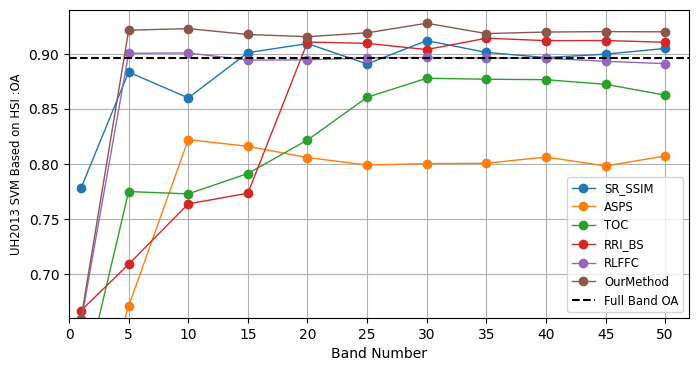

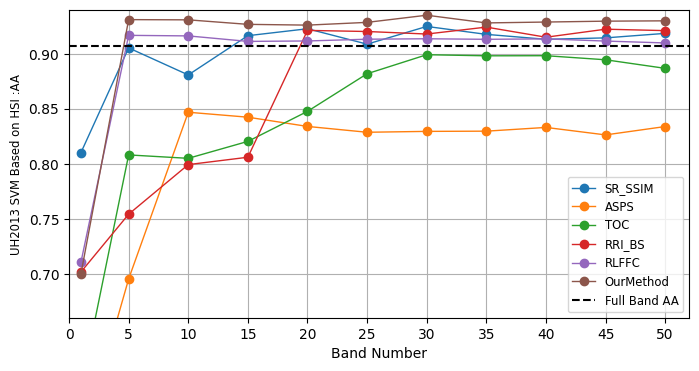

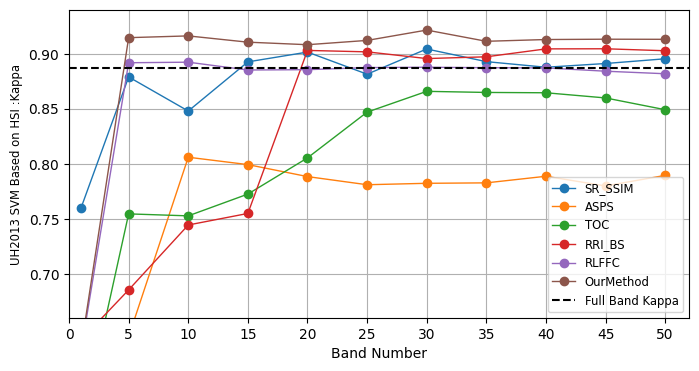

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5,1,1,1],
    "Metrics": ['OA', 'AA', 'Kappa']*11,
'SR_SSIM':[0.9048, 0.9185, 0.8954, 0.8996, 0.9144, 0.8911, 0.8965, 0.9131, 0.8877, 0.9012, 0.9176, 0.8928, 0.9119, 0.9248, 0.9043, 0.8907, 0.9087, 0.8814, 0.9092, 0.9227, 0.9015, 0.901, 0.9164, 0.8926, 0.8598, 0.8807, 0.8479, 0.8833, 0.9053, 0.8789, 0.7777, 0.8101, 0.7596],
'ASPS':[0.8070, 0.8338, 0.7894, 0.798, 0.8262, 0.7798, 0.8061, 0.833, 0.7886, 0.8004, 0.8296, 0.7826, 0.8001, 0.8294, 0.7822, 0.7988, 0.8286, 0.7809, 0.8056, 0.8339, 0.7883, 0.8158, 0.8423, 0.7992, 0.8219, 0.8468, 0.8059, 0.6706, 0.6952, 0.6427, 0.52433, 0.5434, 0.4885],
'TOC': [0.8623, 0.8867, 0.8491, 0.8722, 0.8945, 0.8598, 0.8764, 0.8982, 0.8645, 0.8768, 0.8981, 0.8648, 0.8777, 0.8991, 0.8658, 0.8604, 0.8818, 0.8469, 0.8216, 0.8476, 0.8053, 0.7911, 0.8203, 0.7724, 0.7726, 0.8049, 0.7526, 0.7747, 0.808, 0.7544, 0.5906, 0.5957, 0.5578],
'RRI_BS': [0.9104, 0.921, 0.9027, 0.912, 0.9223, 0.9045, 0.9119, 0.915, 0.9044, 0.9141, 0.9242, 0.8972, 0.9038, 0.9179, 0.8956, 0.9094, 0.9202, 0.9017, 0.9106, 0.9212, 0.903, 0.7732, 0.8059, 0.7548, 0.7635, 0.7992, 0.7443, 0.7086, 0.7541, 0.6853, 0.6664, 0.7016, 0.6398],
'RLFFC': [0.891, 0.9098, 0.8818, 0.8931, 0.9115, 0.8841, 0.8959, 0.9135, 0.8871, 0.8961, 0.9131, 0.8873, 0.8966, 0.9136, 0.8877, 0.8962, 0.9132, 0.8874, 0.8944, 0.9116, 0.8855, 0.8942, 0.9112, 0.8852, 0.9007, 0.9162, 0.8923, 0.9004, 0.9167, 0.8918, 0.6556, 0.7105, 0.6294],
'OurMethod': [0.9199, 0.9299, 0.9131, 0.9201, 0.9296, 0.9132, 0.9197, 0.9288, 0.9129, 0.9183, 0.928, 0.9113, 0.9277, 0.935, 0.9215, 0.9190, 0.9285, 0.9121, 0.9155, 0.9260, 0.9082, 0.9175, 0.9267, 0.9105, 0.9228, 0.9308, 0.9162, 0.9214, 0.931, 0.9146, 0.6586, 0.7, 0.6318]
}
# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TOC','RRI_BS', 'RLFFC','OurMethod']
#methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC','RRI_BS', 'RLFFC','MethodP3','MethodP3.1','MethodP5','MethodP5.1', 'MethodP7','MethodP7.1', 'MethodP9','MethodP9.1', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8960, 'AA': 0.9073, 'Kappa': 0.8872}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 SVM Based on HSI :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6600, 0.9400)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

###4.0.5 KNN Based on New Rule and HSI LiDAR

In [ ]:
data_values = """0.8769	0.8569	0.8663	0.8787	0.8568	0.8682	0.8691	0.8501	0.8579	0.8741	0.8531	0.8632	0.8768	0.8559	0.8661	0.864	0.8445	0.8523	0.8829	0.8595	0.8728	0.8712	0.8506	0.8601	0.854	0.8355	0.8414	0.8512	0.8308	0.8385	0.7546	0.7584	0.7336
0.8471	0.8277	0.8341	0.8474	0.8284	0.8344	0.8471	0.8289	0.8341	0.8459	0.8278	0.9328	0.8437	0.8265	0.8305	0.8441	0.8269	0.8309	0.8484	0.8303	0.8355	0.8524	0.8348	0.8399	0.8475	0.8327	0.8345	0.7764	0.7755	0.7578	0.6991	0.7112	0.6742
0.8813	0.8637	0.871	0.8807	0.8623	0.8704	0.8818	0.864	0.8716	0.88	0.8622	0.8696	0.8774	0.8593	0.8734	0.8533	0.8378	0.8407	0.8258	0.8037	0.8109	0.8148	0.8037	0.7991	0.8083	0.7991	0.7921	0.7857	0.7821	0.7676	0.5972	0.6039	0.5452
0.8888	0.8656	0.8792	0.8886	0.8659	0.8789	0.8866	0.8644	0.8768	0.886	0.8648	0.8779	0.8834	0.8628	0.8757	0.8851	0.864	0.8764	0.884	0.8635	0.8761	0.7994	0.7905	0.7826	0.792	0.7845	0.7746	0.7728	0.7694	0.7538	0.7015	0.7135	0.6772
0.8713	0.8483	0.8602	0.871	0.8476	0.8598	0.8741	0.8514	0.8632	0.8737	0.8506	0.8628	0.8724	0.8488	0.8614	0.8714	0.8485	0.8603	0.8709	0.8476	0.8597	0.8718	0.8486	0.8607	0.8737	0.8495	0.8629	0.8778	0.8549	0.8672	0.7231	0.7309	0.7001
0.8987	0.875	0.89	0.9013	0.8768	0.8927	0.9006	0.8781	0.892	0.899	0.8754	0.8903	0.9029	0.88	0.8945	0.9007	0.8775	0.8921	0.8977	0.8752	0.8889	0.9019	0.8785	0.8935	0.8986	0.8755	0.8898	0.893	0.8712	0.8838	0.7438	0.7514	0.7221"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.8769, 0.8569, 0.8663, 0.8787, 0.8568, 0.8682, 0.8691, 0.8501, 0.8579, 0.8741, 0.8531, 0.8632, 0.8768, 0.8559, 0.8661, 0.864, 0.8445, 0.8523, 0.8829, 0.8595, 0.8728, 0.8712, 0.8506, 0.8601, 0.854, 0.8355, 0.8414, 0.8512, 0.8308, 0.8385, 0.7546, 0.7584, 0.7336
0.8471, 0.8277, 0.8341, 0.8474, 0.8284, 0.8344, 0.8471, 0.8289, 0.8341, 0.8459, 0.8278, 0.9328, 0.8437, 0.8265, 0.8305, 0.8441, 0.8269, 0.8309, 0.8484, 0.8303, 0.8355, 0.8524, 0.8348, 0.8399, 0.8475, 0.8327, 0.8345, 0.7764, 0.7755, 0.7578, 0.6991, 0.7112, 0.6742
0.8813, 0.8637, 0.871, 0.8807, 0.8623, 0.8704, 0.8818, 0.864, 0.8716, 0.88, 0.8622, 0.8696, 0.8774, 0.8593, 0.8734, 0.8533, 0.8378, 0.8407, 0.8258, 0.8037, 0.8109, 0.8148, 0.8037, 0.7991, 0.8083, 0.7991, 0.7921, 0.7857, 0.7821, 0.7676, 0.5972, 0.6039, 0.5452
0.8888, 0.8656, 0.8792, 0.8886, 0.8659, 0.8789, 0.8866, 0.8644, 0.8768, 0.886, 0.8648, 0.8779, 0.8834, 0.8628, 0.8757, 0.8851, 0.864, 0.8764, 0.884, 0.8635, 0.8761, 0.7994, 0.7905, 0.7826, 0.792, 0.7845, 0.7746, 0.772

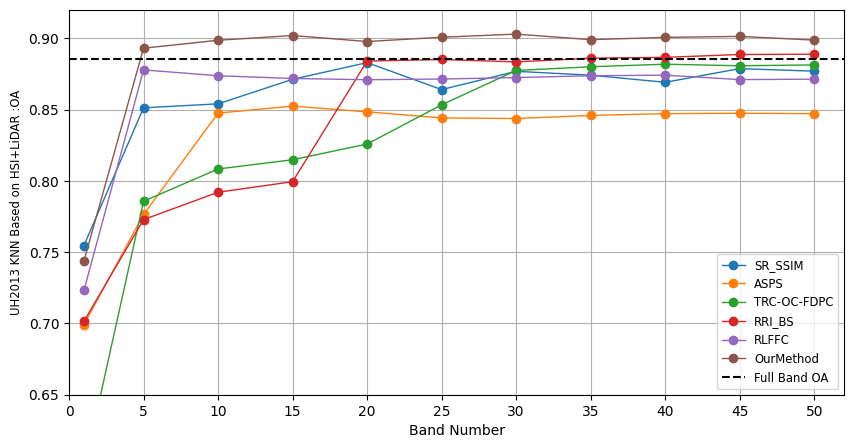

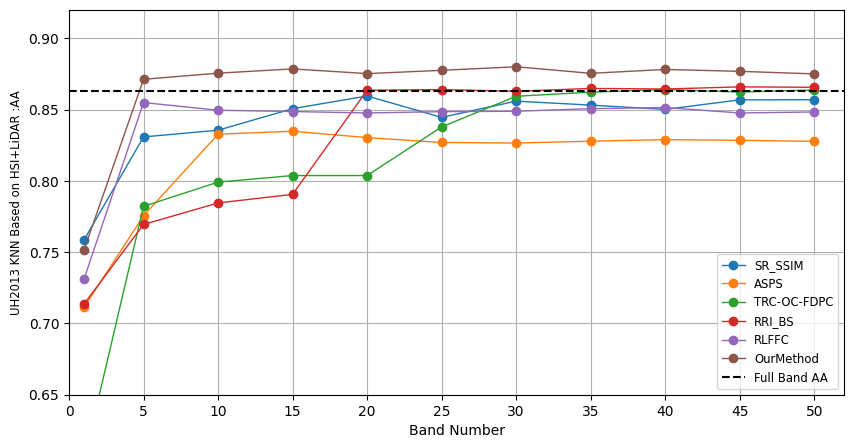

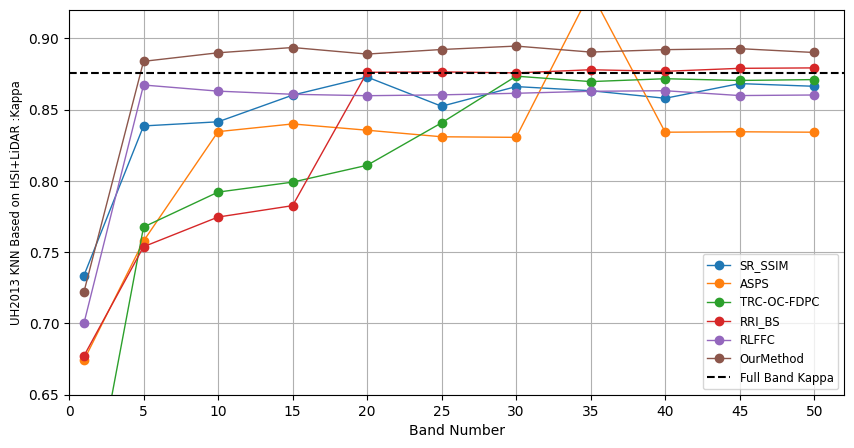

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5,1,1,1],
    "Metrics": ['OA', 'AA', 'Kappa']*11,
    'SR_SSIM':[0.8769, 0.8569, 0.8663, 0.8787, 0.8568, 0.8682, 0.8691, 0.8501, 0.8579, 0.8741, 0.8531, 0.8632, 0.8768, 0.8559, 0.8661, 0.864, 0.8445, 0.8523, 0.8829, 0.8595, 0.8728, 0.8712, 0.8506, 0.8601, 0.854, 0.8355, 0.8414, 0.8512, 0.8308, 0.8385, 0.7546, 0.7584, 0.7336],
'ASPS':[0.8471, 0.8277, 0.8341, 0.8474, 0.8284, 0.8344, 0.8471, 0.8289, 0.8341, 0.8459, 0.8278, 0.9328, 0.8437, 0.8265, 0.8305, 0.8441, 0.8269, 0.8309, 0.8484, 0.8303, 0.8355, 0.8524, 0.8348, 0.8399, 0.8475, 0.8327, 0.8345, 0.7764, 0.7755, 0.7578, 0.6991, 0.7112, 0.6742],
'TRC-OC-FDPC': [0.8813, 0.8637, 0.871, 0.8807, 0.8623, 0.8704, 0.8818, 0.864, 0.8716, 0.88, 0.8622, 0.8696, 0.8774, 0.8593, 0.8734, 0.8533, 0.8378, 0.8407, 0.8258, 0.8037, 0.8109, 0.8148, 0.8037, 0.7991, 0.8083, 0.7991, 0.7921, 0.7857, 0.7821, 0.7676, 0.5972, 0.6039, 0.5452],
'RRI_BS': [0.8888, 0.8656, 0.8792, 0.8886, 0.8659, 0.8789, 0.8866, 0.8644, 0.8768, 0.886, 0.8648, 0.8779, 0.8834, 0.8628, 0.8757, 0.8851, 0.864, 0.8764, 0.884, 0.8635, 0.8761, 0.7994, 0.7905, 0.7826, 0.792, 0.7845, 0.7746, 0.7728, 0.7694, 0.7538, 0.7015, 0.7135, 0.6772],
'RLFFC': [0.8713, 0.8483, 0.8602, 0.871, 0.8476, 0.8598, 0.8741, 0.8514, 0.8632, 0.8737, 0.8506, 0.8628, 0.8724, 0.8488, 0.8614, 0.8714, 0.8485, 0.8603, 0.8709, 0.8476, 0.8597, 0.8718, 0.8486, 0.8607, 0.8737, 0.8495, 0.8629, 0.8778, 0.8549, 0.8672, 0.7231, 0.7309, 0.7001],
'OurMethod': [0.8987, 0.875, 0.89, 0.9013, 0.8768, 0.8927, 0.9006, 0.8781, 0.892, 0.899, 0.8754, 0.8903, 0.9029, 0.88, 0.8945, 0.9007, 0.8775, 0.8921, 0.8977, 0.8752, 0.8889, 0.9019, 0.8785, 0.8935, 0.8986, 0.8755, 0.8898, 0.893, 0.8712, 0.8838, 0.7438, 0.7514, 0.7221]
}
# Creating a DataFrame
df_uh2013_knn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC','RRI_BS', 'RLFFC','OurMethod']
#methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC','RRI_BS', 'RLFFC','MethodP3','MethodP3.1','MethodP5','MethodP5.1', 'MethodP7','MethodP7.1', 'MethodP9','MethodP9.1', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8852, 'AA': 0.8633, 'Kappa': 0.8753}

# Define the band_numbers variable
band_numbers = df_uh2013_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(10, 5))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_knn[df_uh2013_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 KNN Based on HSI+LiDAR :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6500, 0.9200)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 4.1 SVM: UH2013 HSI test (3.5.7.9.11.13) 5 models comparison

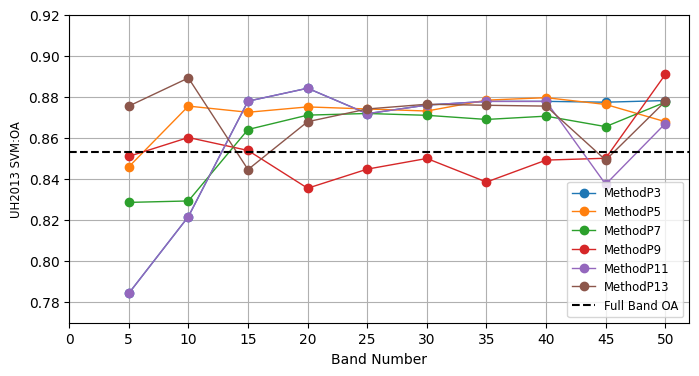

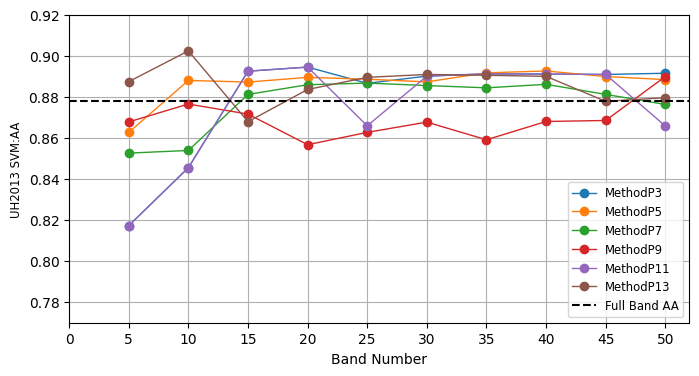

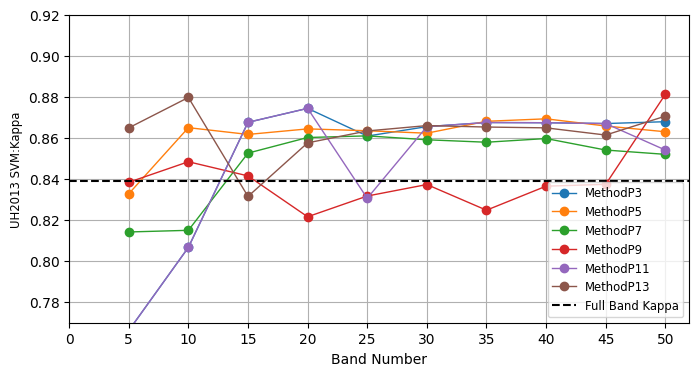

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
   'MethodP3':[0.8782, 0.8915, 0.8679, 0.8774, 0.8909, 0.867, 0.8778, 0.8911, 0.8674, 0.8778, 0.8912, 0.8675, 0.876, 0.8901, 0.8655, 0.8718,
               0.8866, 0.8609, 0.8842, 0.8945, 0.8744, 0.8779, 0.8925, 0.8676, 0.8217, 0.8455, 0.8067, 0.7843, 0.8173, 0.7662],
   'MethodP5': [0.8679, 0.8884, 0.863, 0.8763, 0.8899, 0.8658, 0.8796, 0.8926, 0.8693, 0.8784, 0.8917, 0.8681, 0.8731, 0.8873, 0.8623, 0.8741,
                0.8886, 0.8635, 0.8751, 0.8895, 0.8644, 0.8725, 0.8872, 0.8617, 0.8755, 0.888, 0.865, 0.8459, 0.8627, 0.8328],
  'MethodP7': [0.8774, 0.8763, 0.852, 0.8655, 0.8812, 0.8541, 0.8706, 0.8861, 0.8597, 0.869, 0.8844, 0.8579, 0.87101, 0.8855, 0.8591, 0.8719, 0.8867,
              0.861, 0.8711, 0.8859, 0.8602, 0.8641, 0.8812, 0.8526, 0.8293, 0.8539, 0.815, 0.8286, 0.8526, 0.8142],
  'MethodP9': [0.8909, 0.8899, 0.8812, 0.8501, 0.8685, 0.8374, 0.8492, 0.868, 0.8365, 0.8385, 0.8591, 0.8248, 0.85, 0.8677, 0.8373, 0.8448,
              0.8627, 0.8317, 0.8355, 0.8567, 0.8216, 0.8539, 0.8716, 0.8415, 0.8602, 0.8765, 0.8484, 0.851, 0.8678, 0.8384],
   'MethodP11': [0.867, 0.8658, 0.8541, 0.8374, 0.8909, 0.867, 0.8778, 0.8911, 0.8674, 0.8778, 0.8912, 0.8675, 0.876, 0.8901, 0.8655, 0.8718, 0.8659,
                0.8306, 0.8842, 0.8945, 0.8744, 0.8779, 0.8925, 0.8676, 0.8217, 0.8455, 0.8067, 0.7843, 0.8173, 0.7662],
  'MethodP13': [0.8778, 0.8796, 0.8706, 0.8492, 0.8778, 0.8614, 0.8755, 0.89, 0.8649, 0.8759, 0.8905, 0.8653, 0.8764, 0.8909, 0.8660, 0.8741,
                0.8895, 0.8634, 0.8679, 0.8836, 0.8576, 0.8446, 0.8679, 0.8315, 0.8892, 0.9024, 0.8797, 0.8755, 0.8874, 0.8649]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['MethodP3','MethodP5', 'MethodP7', 'MethodP9', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.8780, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 SVM Based on HSI :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7700, 0.9200)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 4.2 SVM best two comparison model and other 5 models comaprison Methodp5 Methodp13

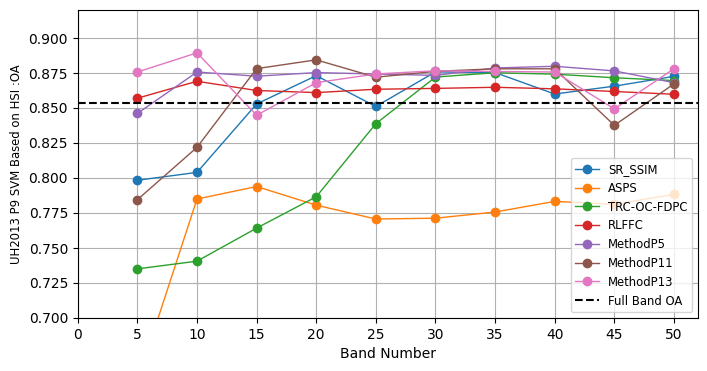

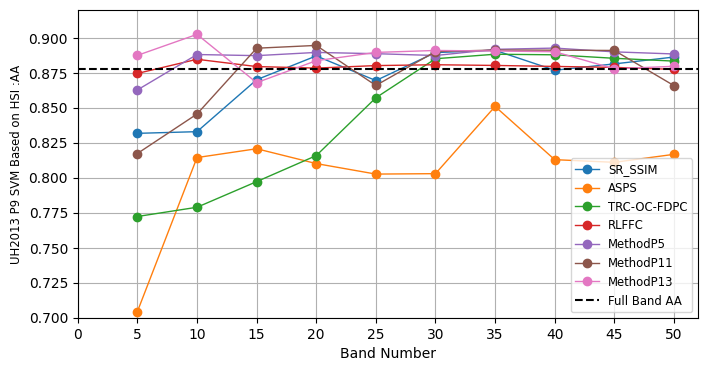

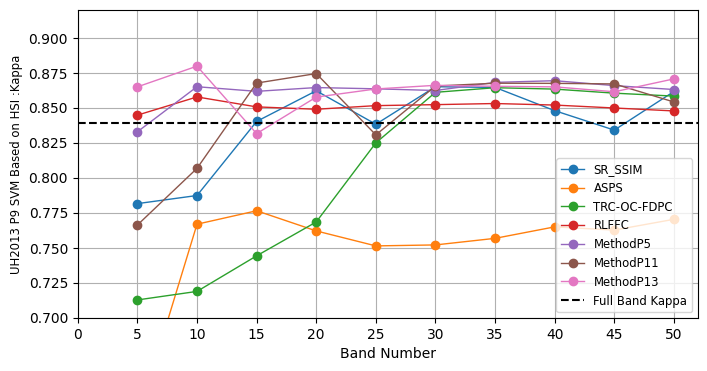

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
 'SR_SSIM': [0.8724, 0.8862, 0.8616, 0.8654, 0.8813, 0.834, 0.8598, 0.8768, 0.8479, 0.8751, 0.891, 0.8645, 0.8756, 0.8894, 0.865, 0.8509,
             0.8694, 0.8382, 0.8729, 0.887, 0.8621, 0.8527, 0.87, 0.8402, 0.8038, 0.8329, 0.7873, 0.7982, 0.8317, 0.7815],
  'ASPS': [0.7881, 0.8167, 0.7703, 0.781, 0.811, 0.7626, 0.7831, 0.8129, 0.7649, 0.7755, 0.8509, 0.7567, 0.7711, 0.8029, 0.752, 0.7705,
           0.8026, 0.7513, 0.7804, 0.8101, 0.762, 0.7937, 0.8207, 0.7764, 0.7848, 0.8144, 0.7668, 0.6544, 0.7044, 0.6272],
'TRC-OC-FDPC': [0.8694, 0.8833, 0.8583, 0.8714, 0.8853, 0.8604, 0.874, 0.8878, 0.8633, 0.875, 0.8882, 0.8643, 0.8719, 0.885, 0.861, 0.8386, 0.8571,
    0.8249, 0.7864, 0.8158, 0.7684, 0.764, 0.7972, 0.7442, 0.7404, 0.7789, 0.7188, 0.7349, 0.7723, 0.7127],
'RRI_BS': [0.8724, 0.886, 0.8616, 0.8713, 0.884, 0.8604, 0.8735, 0.8858, 0.8628, 0.8747, 0.8865, 0.8641, 0.8724, 0.8852, 0.8616, 0.8687, 0.8813,
    0.8575, 0.8675, 0.8799, 0.8562, 0.6849, 0.7064, 0.6367, 0.6639, 0.7064, 0.6367, 0.6113, 0.6644, 0.5805],
'RLFFC': [0.8596, 0.8774, 0.8477, 0.8616, 0.8788, 0.8498, 0.8635, 0.8795, 0.8519, 0.8646, 0.8802, 0.853, 0.8638, 0.8807, 0.8522, 0.8632, 0.8801,
    0.8515, 0.8608, 0.8783, 0.8489, 0.8623, 0.8794, 0.8506, 0.8689, 0.8846, 0.8577, 0.8568, 0.8745, 0.8447],
     'MethodP5': [0.8679, 0.8884, 0.863, 0.8763, 0.8899, 0.8658, 0.8796, 0.8926, 0.8693, 0.8784, 0.8917, 0.8681, 0.8731, 0.8873, 0.8623, 0.8741,
                0.8886, 0.8635, 0.8751, 0.8895, 0.8644, 0.8725, 0.8872, 0.8617, 0.8755, 0.888, 0.865, 0.8459, 0.8627, 0.8328],
    'MethodP11': [0.867, 0.8658, 0.8541, 0.8374, 0.8909, 0.867, 0.8778, 0.8911, 0.8674, 0.8778, 0.8912, 0.8675, 0.876, 0.8901, 0.8655, 0.8718, 0.8659,
                0.8306, 0.8842, 0.8945, 0.8744, 0.8779, 0.8925, 0.8676, 0.8217, 0.8455, 0.8067, 0.7843, 0.8173, 0.7662],

     'MethodP13': [0.8778, 0.8796, 0.8706, 0.8492, 0.8778, 0.8614, 0.8755, 0.89, 0.8649, 0.8759, 0.8905, 0.8653, 0.8764, 0.8909, 0.8660, 0.8741,
                0.8895, 0.8634, 0.8679, 0.8836, 0.8576, 0.8446, 0.8679, 0.8315, 0.8892, 0.9024, 0.8797, 0.8755, 0.8874, 0.8649]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC','RRI_BS', 'RLFFC','MethodP5', 'MethodP11', 'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 SVM Based on HSI :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7000, 0.9200)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 4.3 SVM based HSI+LiDAR Test (3.5.7.9.11.13) 5 models comparison

In [ ]:
data_values = """0.9106	0.9215	0.9029	0.9092	0.9204	0.9014	0.9112	0.9234	0.9036	0.9118	0.9222	0.9043	0.9078	0.9196	0.9	0.9106	0.922	0.903	0.9242	0.9326	0.9178	0.9133	0.9233	0.9059	0.8716	0.8905	0.8607	0.8629	0.8847	0.8513
0.9064	0.9182	0.8984	0.9078	0.9195	0.9	0.9106	0.9218	0.9029	0.9101	0.9215	0.9025	0.9094	0.921	0.9017	0.9132	0.9246	0.9058	0.9145	0.9257	0.9072	0.9172	0.9261	0.9101	0.917	0.9266	0.909	0.8948	0.9052	0.8858
0.8967	0.9121	0.8879	0.895	0.9107	0.886	0.9042	0.9165	0.8961	0.9048	0.9179	0.8967	0.901	0.915	0.8926	0.9067	0.9202	0.8987	0.9054	0.9182	0.8973	0.9074	0.9206	0.8995	0.8913	0.9086	0.8821	0.8803	0.8985	0.8701
0.8924	0.9075	0.8833	0.8826	0.8998	0.8726	0.8827	0.8999	0.8727	0.8655	0.8863	0.854	0.8863	0.9027	0.8766	0.8838	0.9004	0.8739	0.8723	0.8919	0.8615	0.8959	0.9103	0.887	0.907	0.9189	0.8991	0.8971	0.9111	0.8883
0.9106	0.9215	0.9029	0.9092	0.9284	0.9014	0.9112	0.9234	0.9036	0.9118	0.9222	0.9043	0.9078	0.9196	0.9	0.9106	0.922	0.903	0.9242	0.9326	0.9718	0.9133	0.9233	0.9059	0.8716	0.8905	0.8607	0.8629	0.8847	0.8513
0.9045	0.9166	0.8963	0.9035	0.9158	0.8953	0.9037	0.9158	0.8956	0.9072	0.9185	0.8993	0.909	0.9201	0.9012	0.9106	0.9211	0.9029	0.9093	0.9206	0.9016	0.886	0.9024	0.8764	0.9129	0.9229	0.9055	0.9186	0.927	0.9116"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9106, 0.9215, 0.9029, 0.9092, 0.9204, 0.9014, 0.9112, 0.9234, 0.9036, 0.9118, 0.9222, 0.9043, 0.9078, 0.9196, 0.9, 0.9106, 0.922, 0.903, 0.9242, 0.9326, 0.9178, 0.9133, 0.9233, 0.9059, 0.8716, 0.8905, 0.8607, 0.8629, 0.8847, 0.8513
0.9064, 0.9182, 0.8984, 0.9078, 0.9195, 0.9, 0.9106, 0.9218, 0.9029, 0.9101, 0.9215, 0.9025, 0.9094, 0.921, 0.9017, 0.9132, 0.9246, 0.9058, 0.9145, 0.9257, 0.9072, 0.9172, 0.9261, 0.9101, 0.917, 0.9266, 0.909, 0.8948, 0.9052, 0.8858
0.8967, 0.9121, 0.8879, 0.895, 0.9107, 0.886, 0.9042, 0.9165, 0.8961, 0.9048, 0.9179, 0.8967, 0.901, 0.915, 0.8926, 0.9067, 0.9202, 0.8987, 0.9054, 0.9182, 0.8973, 0.9074, 0.9206, 0.8995, 0.8913, 0.9086, 0.8821, 0.8803, 0.8985, 0.8701
0.8924, 0.9075, 0.8833, 0.8826, 0.8998, 0.8726, 0.8827, 0.8999, 0.8727, 0.8655, 0.8863, 0.854, 0.8863, 0.9027, 0.8766, 0.8838, 0.9004, 0.8739, 0.8723, 0.8919, 0.8615, 0.8959, 0.9103, 0.887, 0.907, 0.9189, 0.8991, 0.8971, 0.9111, 0.8883
0.9106, 0.9215, 0.9029, 0.9092, 0.9284, 0.9014, 0.9112, 0.9234

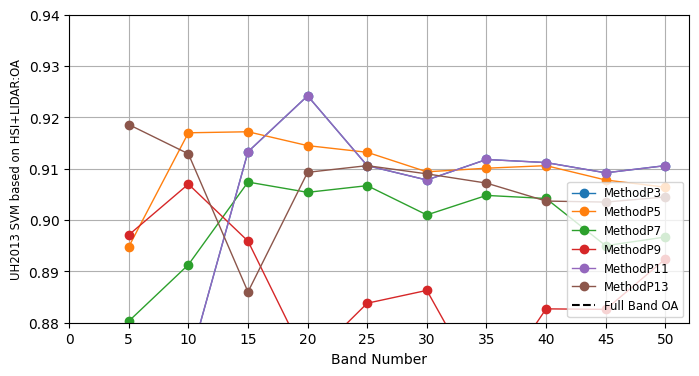

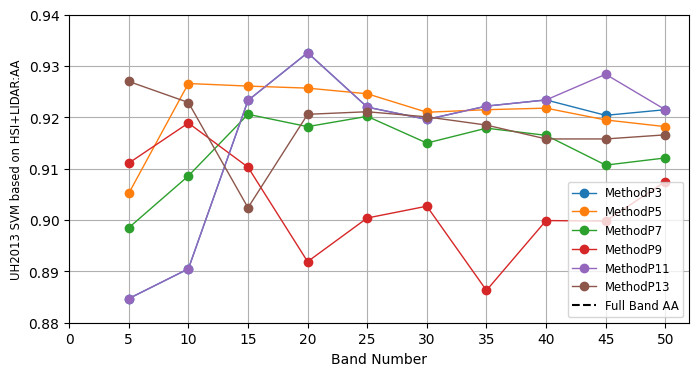

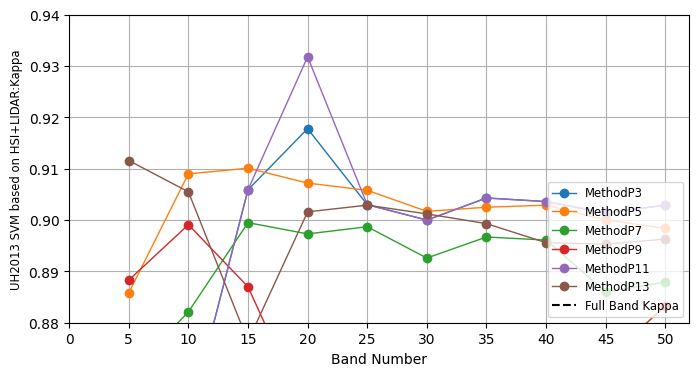

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test on (HSI+LIDAR)
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
   'MethodP3':[0.9106, 0.9215, 0.9029, 0.9092, 0.9204, 0.9014, 0.9112, 0.9234, 0.9036, 0.9118, 0.9222, 0.9043, 0.9078, 0.9196, 0.9, 0.9106,
               0.922, 0.903, 0.9242, 0.9326, 0.9178, 0.9133, 0.9233, 0.9059, 0.8716, 0.8905, 0.8607, 0.8629, 0.8847, 0.8513],
   'MethodP5': [0.9064, 0.9182, 0.8984, 0.9078, 0.9195, 0.9, 0.9106, 0.9218, 0.9029, 0.9101, 0.9215, 0.9025, 0.9094, 0.921, 0.9017, 0.9132,
                0.9246, 0.9058, 0.9145, 0.9257, 0.9072, 0.9172, 0.9261, 0.9101, 0.917, 0.9266, 0.909, 0.8948, 0.9052, 0.8858],
  'MethodP7': [0.8967, 0.9121, 0.8879, 0.895, 0.9107, 0.886, 0.9042, 0.9165, 0.8961, 0.9048, 0.9179, 0.8967, 0.901, 0.915, 0.8926, 0.9067,
               0.9202, 0.8987, 0.9054, 0.9182, 0.8973, 0.9074, 0.9206, 0.8995, 0.8913, 0.9086, 0.8821, 0.8803, 0.8985, 0.8701],
  'MethodP9': [0.8924, 0.9075, 0.8833, 0.8826, 0.8998, 0.8726, 0.8827, 0.8999, 0.8727, 0.8655, 0.8863, 0.854, 0.8863, 0.9027, 0.8766, 0.8838,
               0.9004, 0.8739, 0.8723, 0.8919, 0.8615, 0.8959, 0.9103, 0.887, 0.907, 0.9189, 0.8991, 0.8971, 0.9111, 0.8883],
   'MethodP11': [0.9106, 0.9215, 0.9029, 0.9092, 0.9284, 0.9014, 0.9112, 0.9234, 0.9036, 0.9118, 0.9222, 0.9043, 0.9078, 0.9196, 0.9, 0.9106,
                 0.922, 0.903, 0.9242, 0.9326, 0.9318, 0.9133, 0.9233, 0.9059, 0.8716, 0.8905, 0.8607, 0.8629, 0.8847, 0.8513],
  'MethodP13': [0.9045, 0.9166, 0.8963, 0.9035, 0.9158, 0.8953, 0.9037, 0.9158, 0.8956, 0.9072, 0.9185, 0.8993, 0.909, 0.9201, 0.9012, 0.9106,
                0.9211, 0.9029, 0.9093, 0.9206, 0.9016, 0.886, 0.9024, 0.8764, 0.9129, 0.9229, 0.9055, 0.9186, 0.927, 0.9116]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['MethodP3','MethodP5', 'MethodP7', 'MethodP9', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.8780, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 SVM based on HSI+LIDAR:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.8800, 0.9400)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 4.4 SVM based HSI+LiDAR Test (3.5.7.9.11.13) Selected models and the other mthos comparison

In [ ]:
data_values = """0.9036	0.9192	0.8954	0.8992	0.9141	0.8907	0.8994	0.915	0.8908	0.9053	0.9188	0.8972	0.9072	0.9206	0.8993	0.8828	0.9001	0.8705	0.9153	0.9248	0.9081	0.9009	0.9138	0.8924	0.8641	0.883	0.8526	0.8853	0.9009	0.8756
0.807	0.8338	0.7894	0.798	0.8262	0.7798	0.8061	0.833	0.7886	0.8004	0.8296	0.7826	0.8001	0.8294	0.7822	0.7988	0.8286	0.7809	0.8056	0.8339	0.7883	0.8158	0.8423	0.7992	0.8219	0.8468	0.8059	0.6706	0.6952	0.6427
0.8623	0.8867	0.8491	0.8722	0.8945	0.8598	0.8764	0.8982	0.8645	0.8768	0.8981	0.8648	0.8777	0.8991	0.8658	0.8604	0.8818	0.8469	0.8216	0.8476	0.8053	0.7911	0.8203	0.7724	0.7726	0.8049	0.7526	0.7747	0.808	0.7544
0.9104	0.921	0.9027	0.912	0.9223	0.9045	0.9119	0.9224	0.9044	0.9141	0.9242	0.9067	0.9038	0.9179	0.8956	0.9094	0.9202	0.9017	0.9106	0.9212	0.903	0.7756	0.8104	0.7574	0.7686	0.8063	0.7499	0.7106	0.758	0.6873
0.891	0.9098	0.8818	0.8931	0.9115	0.8841	0.8959	0.9135	0.8871	0.8961	0.9131	0.8873	0.8966	0.9136	0.8877	0.8962	0.9132	0.8874	0.8944	0.9116	0.8855	0.8942	0.9112	0.8852	0.9007	0.9162	0.8923	0.9004	0.9167	0.8918"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9036, 0.9192, 0.8954, 0.8992, 0.9141, 0.8907, 0.8994, 0.915, 0.8908, 0.9053, 0.9188, 0.8972, 0.9072, 0.9206, 0.8993, 0.8828, 0.9001, 0.8705, 0.9153, 0.9248, 0.9081, 0.9009, 0.9138, 0.8924, 0.8641, 0.883, 0.8526, 0.8853, 0.9009, 0.8756
0.807, 0.8338, 0.7894, 0.798, 0.8262, 0.7798, 0.8061, 0.833, 0.7886, 0.8004, 0.8296, 0.7826, 0.8001, 0.8294, 0.7822, 0.7988, 0.8286, 0.7809, 0.8056, 0.8339, 0.7883, 0.8158, 0.8423, 0.7992, 0.8219, 0.8468, 0.8059, 0.6706, 0.6952, 0.6427
0.8623, 0.8867, 0.8491, 0.8722, 0.8945, 0.8598, 0.8764, 0.8982, 0.8645, 0.8768, 0.8981, 0.8648, 0.8777, 0.8991, 0.8658, 0.8604, 0.8818, 0.8469, 0.8216, 0.8476, 0.8053, 0.7911, 0.8203, 0.7724, 0.7726, 0.8049, 0.7526, 0.7747, 0.808, 0.7544
0.9104, 0.921, 0.9027, 0.912, 0.9223, 0.9045, 0.9119, 0.9224, 0.9044, 0.9141, 0.9242, 0.9067, 0.9038, 0.9179, 0.8956, 0.9094, 0.9202, 0.9017, 0.9106, 0.9212, 0.903, 0.7756, 0.8104, 0.7574, 0.7686, 0.8063, 0.7499, 0.7106, 0.758, 0.6873
0.891, 0.9098, 0.8818, 0.8931, 0.9115, 0.8841, 0.8959,

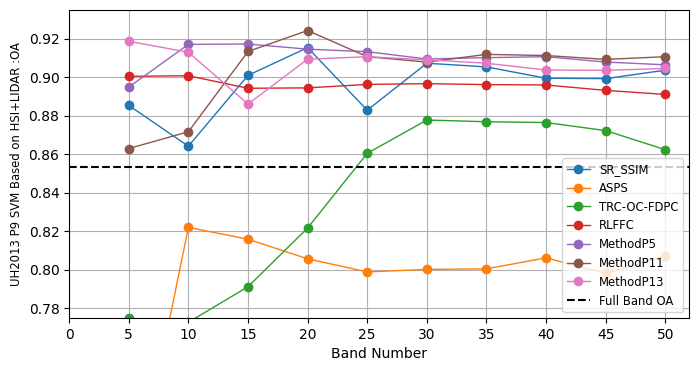

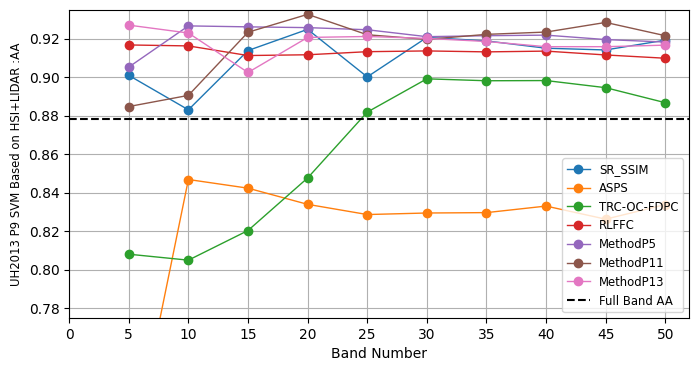

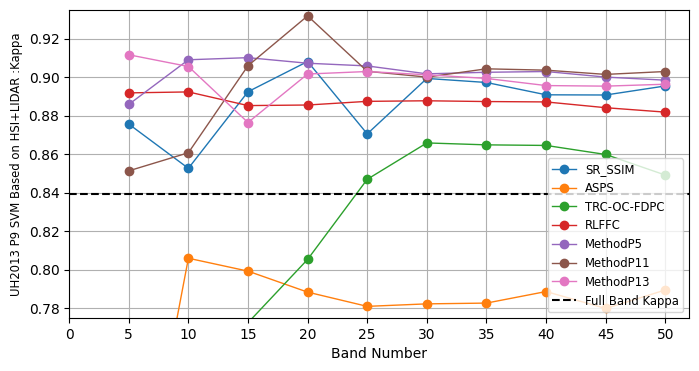

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
 'SR_SSIM': [0.9036, 0.9192, 0.8954, 0.8992, 0.9141, 0.8907, 0.8994, 0.915, 0.8908, 0.9053, 0.9188, 0.8972, 0.9072, 0.9206, 0.8993,
             0.8828, 0.9001, 0.8705, 0.9153, 0.9248, 0.9081, 0.9009, 0.9138, 0.8924, 0.8641, 0.883, 0.8526, 0.8853, 0.9009, 0.8756],
  'ASPS': [0.8070, 0.8338, 0.7894, 0.798, 0.8262, 0.7798, 0.8061, 0.833, 0.7886, 0.8004, 0.8296, 0.7826, 0.8001, 0.8294, 0.7822,
           0.7988, 0.8286, 0.78090, 0.8056, 0.8339, 0.7883, 0.8158, 0.8423, 0.7992, 0.8219, 0.8468, 0.8059, 0.6706, 0.6952, 0.6427],
  'TRC-OC-FDPC': [0.8623, 0.8867, 0.8491, 0.8722, 0.8945, 0.8598, 0.8764, 0.8982, 0.8645, 0.8768, 0.8981, 0.8648, 0.8777, 0.8991,
                0.8658, 0.8604, 0.8818, 0.8469, 0.8216, 0.8476, 0.8053, 0.7911, 0.8203, 0.7724, 0.7726, 0.8049, 0.7526, 0.7747, 0.808, 0.7544],
  'RRI_BS': [0.9104, 0.921, 0.9027, 0.912, 0.9223, 0.9045, 0.9119, 0.9224, 0.9044, 0.9141, 0.9242, 0.9067, 0.9038, 0.9179, 0.8956, 0.9094,
           0.9202, 0.9017, 0.9106, 0.9212, 0.903, 0.7756, 0.8104, 0.7574, 0.7686, 0.8063, 0.7499, 0.7106, 0.758, 0.6873],
  'RLFFC': [0.891, 0.9098, 0.8818, 0.8931, 0.9115, 0.8841, 0.8959, 0.9135, 0.8871, 0.8961, 0.9131, 0.8873, 0.8966, 0.9136, 0.8877, 0.8962,
          0.9132, 0.8874, 0.8944, 0.9116, 0.8855, 0.8942, 0.9112, 0.8852, 0.9007, 0.9162, 0.8923, 0.9004, 0.9167, 0.8918],
  'MethodP5':[0.9064, 0.9182, 0.8984, 0.9078, 0.9195, 0.9, 0.9106, 0.9218, 0.9029, 0.9101, 0.9215, 0.9025, 0.9094, 0.921, 0.9017, 0.9132,
                0.9246, 0.9058, 0.9145, 0.9257, 0.9072, 0.9172, 0.9261, 0.9101, 0.917, 0.9266, 0.909, 0.8948, 0.9052, 0.8858],
  'MethodP11': [0.9106, 0.9215, 0.9029, 0.9092, 0.9284, 0.9014, 0.9112, 0.9234, 0.9036, 0.9118, 0.9222, 0.9043, 0.9078, 0.9196, 0.9, 0.9106,
                 0.922, 0.903, 0.9242, 0.9326, 0.9318, 0.9133, 0.9233, 0.9059, 0.8716, 0.8905, 0.8607, 0.8629, 0.8847, 0.8513],
  'MethodP13': [0.9045, 0.9166, 0.8963, 0.9035, 0.9158, 0.8953, 0.9037, 0.9158, 0.8956, 0.9072, 0.9185, 0.8993, 0.909, 0.9201, 0.9012, 0.9106,
                0.9211, 0.9029, 0.9093, 0.9206, 0.9016, 0.886, 0.9024, 0.8764, 0.9129, 0.9229, 0.9055, 0.9186, 0.927, 0.9116]
}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC', 'RLFFC','MethodP5', 'MethodP11', 'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 SVM Based on HSI+LIDAR :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.77500, 0.9350)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

#5.0  KNN: based on  : UH2013 Test  (3.5.7.9.11.13) 5 + other 5 methods models comparison

###5.1 KNN based on HSI Only  ablation study

In [ ]:
data_values = """0.8635	0.8449	0.8517	0.8625	0.8445	0.8506	0.865	0.8464	0.8534	0.8645	0.8457	0.8527	0.8519	0.8357	0.8391	0.8519	0.8357	0.8394	0.8428	0.8281	0.8292	0.8728	0.8548	0.8618	0.8556	0.8408	0.8431	0.8216	0.8114	0.8062
0.8546	0.8376	0.842	0.8538	0.8368	0.8412	0.854	0.8367	0.8413	0.8579	0.8401	0.8456	0.855	0.8377	0.8425	0.8612	0.8419	0.8492	0.8764	0.8555	0.8658	0.8644	0.846	0.8527	0.8336	0.8198	0.8192	0.8254	0.8145	0.8104
0.8573	0.8419	0.845	0.8438	0.8295	0.8303	0.8555	0.8392	0.8429	0.8468	0.8322	0.8335	0.8506	0.8349	0.8377	0.8476	0.8326	0.8344	0.8482	0.8333	0.8351	0.8451	0.8309	0.8318	0.8484	0.8339	0.8353	0.8215	0.8124	0.8061
0.8673	0.8505	0.8559	0.8678	0.8508	0.8564	0.8643	0.846	0.8526	0.8647	0.8469	0.853	0.8677	0.8502	0.8562	0.8736	0.854	0.8626	0.8664	0.8507	0.8548	0.856	0.8405	0.8436	0.8539	0.8383	0.8413	0.852	0.8389	0.8392
0.8651	0.8485	0.8535	0.8614	0.8442	0.8495	0.8605	0.8444	0.8485	0.8545	0.8385	0.8419	0.8609	0.8446	0.8489	0.8552	0.8406	0.8427	0.8539	0.8395	0.8413	0.8539	0.837	0.8413	0.8546	0.8378	0.8421	0.7789	0.774	0.7599
0.8581	0.8423	0.8458	0.8592	0.8434	0.8471	0.8602	0.8439	0.8482	0.8692	0.8514	0.8579	0.8638	0.847	0.8521	0.8669	0.8492	0.8555	0.8475	0.8318	0.8344	0.8599	0.844	0.8478	0.8249	0.8148	0.8099	0.829	0.8211	0.8142"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.8635, 0.8449, 0.8517, 0.8625, 0.8445, 0.8506, 0.865, 0.8464, 0.8534, 0.8645, 0.8457, 0.8527, 0.8519, 0.8357, 0.8391, 0.8519, 0.8357, 0.8394, 0.8428, 0.8281, 0.8292, 0.8728, 0.8548, 0.8618, 0.8556, 0.8408, 0.8431, 0.8216, 0.8114, 0.8062
0.8546, 0.8376, 0.842, 0.8538, 0.8368, 0.8412, 0.854, 0.8367, 0.8413, 0.8579, 0.8401, 0.8456, 0.855, 0.8377, 0.8425, 0.8612, 0.8419, 0.8492, 0.8764, 0.8555, 0.8658, 0.8644, 0.846, 0.8527, 0.8336, 0.8198, 0.8192, 0.8254, 0.8145, 0.8104
0.8573, 0.8419, 0.845, 0.8438, 0.8295, 0.8303, 0.8555, 0.8392, 0.8429, 0.8468, 0.8322, 0.8335, 0.8506, 0.8349, 0.8377, 0.8476, 0.8326, 0.8344, 0.8482, 0.8333, 0.8351, 0.8451, 0.8309, 0.8318, 0.8484, 0.8339, 0.8353, 0.8215, 0.8124, 0.8061
0.8673, 0.8505, 0.8559, 0.8678, 0.8508, 0.8564, 0.8643, 0.846, 0.8526, 0.8647, 0.8469, 0.853, 0.8677, 0.8502, 0.8562, 0.8736, 0.854, 0.8626, 0.8664, 0.8507, 0.8548, 0.856, 0.8405, 0.8436, 0.8539, 0.8383, 0.8413, 0.852, 0.8389, 0.8392
0.8651, 0.8485, 0.8535, 0.8614, 0.8442, 0.8495, 0.8605,

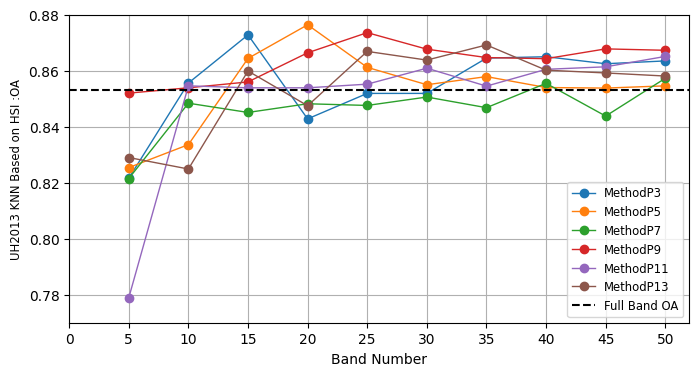

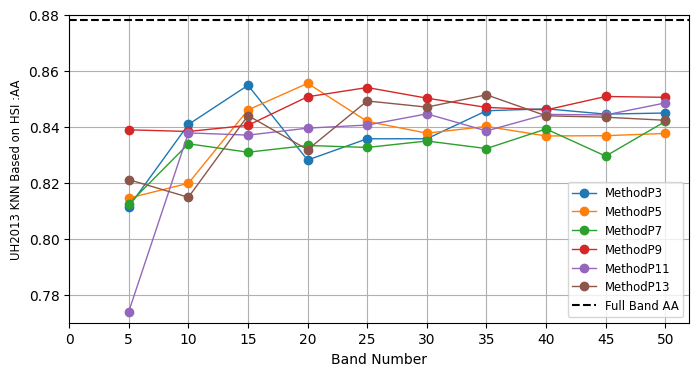

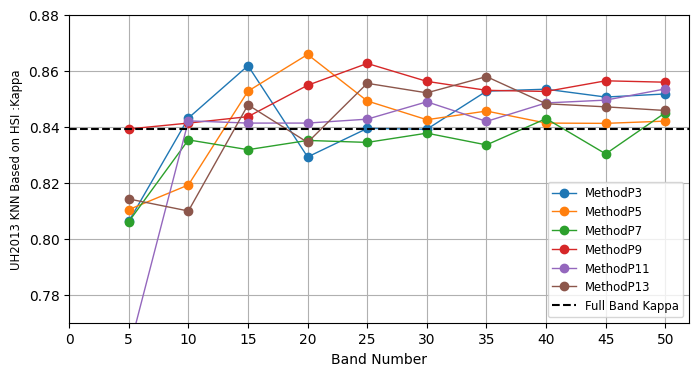

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
   'MethodP3':[0.8635, 0.8449, 0.8517, 0.8625, 0.8445, 0.8506, 0.865, 0.8464, 0.8534, 0.8645, 0.8457, 0.8527, 0.8519, 0.8357, 0.8391, 0.8519, 0.8357, 0.8394, 0.8428, 0.8281, 0.8292, 0.8728, 0.8548, 0.8618, 0.8556, 0.8408, 0.8431, 0.8216, 0.8114, 0.8062],
   'MethodP5': [0.8546, 0.8376, 0.842, 0.8538, 0.8368, 0.8412, 0.854, 0.8367, 0.8413, 0.8579, 0.8401, 0.8456, 0.855, 0.8377, 0.8425, 0.8612, 0.8419, 0.8492, 0.8764, 0.8555, 0.8658, 0.8644, 0.846, 0.8527, 0.8336, 0.8198, 0.8192, 0.8254, 0.8145, 0.8104],
  'MethodP7': [0.8573, 0.8419, 0.845, 0.8438, 0.8295, 0.8303, 0.8555, 0.8392, 0.8429, 0.8468, 0.8322, 0.8335, 0.8506, 0.8349, 0.8377, 0.8476, 0.8326, 0.8344, 0.8482, 0.8333, 0.8351, 0.8451, 0.8309, 0.8318, 0.8484, 0.8339, 0.8353, 0.8215, 0.8124, 0.8061],
  'MethodP9': [0.8673, 0.8505, 0.8559, 0.8678, 0.8508, 0.8564, 0.8643, 0.846, 0.8526, 0.8647, 0.8469, 0.853, 0.8677, 0.8502, 0.8562, 0.8736, 0.854, 0.8626, 0.8664, 0.8507, 0.8548, 0.856, 0.8405, 0.8436, 0.8539, 0.8383, 0.8413, 0.852, 0.8389, 0.8392],
   'MethodP11': [0.8651, 0.8485, 0.8535, 0.8614, 0.8442, 0.8495, 0.8605, 0.8444, 0.8485, 0.8545, 0.8385, 0.8419, 0.8609, 0.8446, 0.8489, 0.8552, 0.8406, 0.8427, 0.8539, 0.8395, 0.8413, 0.8539, 0.837, 0.8413, 0.8546, 0.8378, 0.8421, 0.7789, 0.774, 0.7599],
  'MethodP13': [0.8581, 0.8423, 0.8458, 0.8592, 0.8434, 0.8471, 0.8602, 0.8439, 0.8482, 0.8692, 0.8514, 0.8579, 0.8638, 0.847, 0.8521, 0.8669, 0.8492, 0.8555, 0.8475, 0.8318, 0.8344, 0.8599, 0.844, 0.8478, 0.8249, 0.8148, 0.8099, 0.829, 0.8211, 0.8142]
}

# Creating a DataFrame
df_uh2013_knn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['MethodP3','MethodP5', 'MethodP7', 'MethodP9', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.8780, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_knn[df_uh2013_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 KNN Based on HSI :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7700, 0.8800)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 5.2  KNN best two comparison model and other 5 models comaprison

In [ ]:
data_values = """0.8539	0.8397	0.8413	0.8548	0.8388	0.8423	0.837	0.8265	0.823	0.8504	0.8375	0.8375	0.8559	0.8408	0.8434	0.8179	0.8106	0.8023	0.86	0.8461	0.8479	0.8431	0.8303	0.8296	0.8055	0.797	0.7889	0.7824	0.7702	0.7638
0.8215	0.8072	0.8063	0.8236	0.8088	0.8085	0.8214	0.8082	0.8063	0.8177	0.8053	0.8022	0.8095	0.7992	0.7934	0.8109	0.8009	0.7949	0.8182	0.8056	0.8027	0.8208	0.8091	0.8056	0.8182	0.8055	0.8027	0.7039	0.7096	0.6793
0.8716	0.852	0.8605	0.8707	0.8515	0.8596	0.8689	0.8494	0.8576	0.8682	0.8494	0.8568	0.8718	0.8532	0.8607	0.8441	0.8313	0.8307	0.8191	0.8086	0.8038	0.8067	0.7947	0.7904	0.7985	0.7884	0.7815	0.7813	0.7736	0.7629
0.8539	0.8524	0.8583	0.8685	0.8506	0.8572	0.8669	0.8501	0.8555	0.8632	0.8465	0.8514	0.8548	0.8401	0.8423	0.8598	0.845	0.8477	0.8605	0.8438	0.8484	0.7299	0.7313	0.7073	0.7084	0.7134	0.6774	0.7022	0.7084	0.6774
0.8507	0.8333	0.8378	0.8492	0.832	0.8362	0.8526	0.8348	0.8399	0.8492	0.832	0.8362	0.8511	0.8339	0.8383	0.8492	0.8321	0.8362	0.8459	0.8287	0.8327	0.835	0.8203	0.8247	0.8351	0.8208	0.821	0.8412	0.8265	0.8276"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.8539, 0.8397, 0.8413, 0.8548, 0.8388, 0.8423, 0.837, 0.8265, 0.823, 0.8504, 0.8375, 0.8375, 0.8559, 0.8408, 0.8434, 0.8179, 0.8106, 0.8023, 0.86, 0.8461, 0.8479, 0.8431, 0.8303, 0.8296, 0.8055, 0.797, 0.7889, 0.7824, 0.7702, 0.7638
0.8215, 0.8072, 0.8063, 0.8236, 0.8088, 0.8085, 0.8214, 0.8082, 0.8063, 0.8177, 0.8053, 0.8022, 0.8095, 0.7992, 0.7934, 0.8109, 0.8009, 0.7949, 0.8182, 0.8056, 0.8027, 0.8208, 0.8091, 0.8056, 0.8182, 0.8055, 0.8027, 0.7039, 0.7096, 0.6793
0.8716, 0.852, 0.8605, 0.8707, 0.8515, 0.8596, 0.8689, 0.8494, 0.8576, 0.8682, 0.8494, 0.8568, 0.8718, 0.8532, 0.8607, 0.8441, 0.8313, 0.8307, 0.8191, 0.8086, 0.8038, 0.8067, 0.7947, 0.7904, 0.7985, 0.7884, 0.7815, 0.7813, 0.7736, 0.7629
0.8539, 0.8524, 0.8583, 0.8685, 0.8506, 0.8572, 0.8669, 0.8501, 0.8555, 0.8632, 0.8465, 0.8514, 0.8548, 0.8401, 0.8423, 0.8598, 0.845, 0.8477, 0.8605, 0.8438, 0.8484, 0.7299, 0.7313, 0.7073, 0.7084, 0.7134, 0.6774, 0.7022, 0.7084, 0.6774
0.8507, 0.8333, 0.8378, 0.8492, 0.832, 0.8362, 0.85

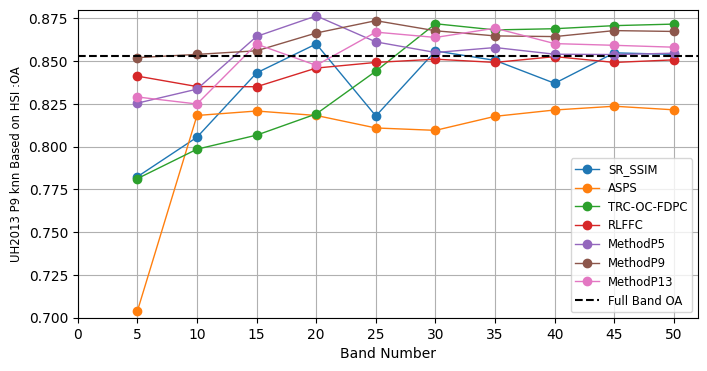

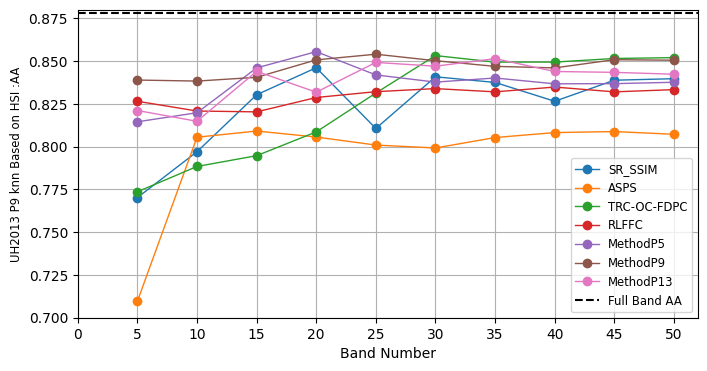

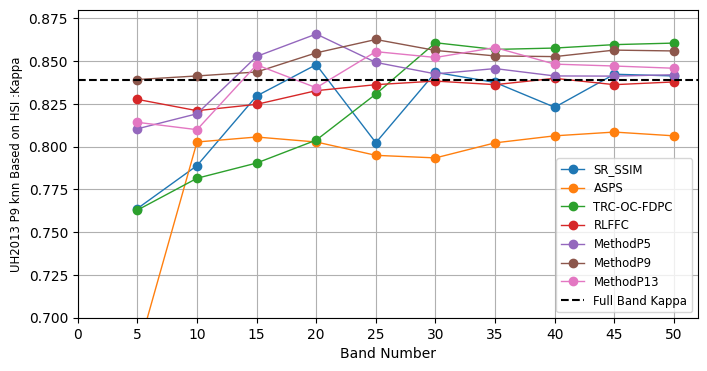

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
 'SR_SSIM': [0.8539, 0.8397, 0.8413, 0.8548, 0.8388, 0.8423, 0.837, 0.8265, 0.823, 0.8504, 0.8375, 0.8375, 0.8559, 0.8408, 0.8434, 0.8179, 0.8106, 0.8023, 0.86, 0.8461, 0.8479, 0.8431, 0.8303, 0.8296, 0.8055, 0.797, 0.7889, 0.7824, 0.7702, 0.7638],
  'ASPS': [0.8215, 0.8072, 0.8063, 0.8236, 0.8088, 0.8085, 0.8214, 0.8082, 0.8063, 0.8177, 0.8053, 0.8022, 0.8095, 0.7992, 0.7934, 0.8109, 0.8009, 0.7949, 0.8182, 0.8056, 0.8027, 0.8208, 0.8091, 0.8056, 0.8182, 0.8055, 0.8027, 0.7039, 0.7096, 0.6793],
  'TRC-OC-FDPC': [0.8716, 0.852, 0.8605, 0.8707, 0.8515, 0.8596, 0.8689, 0.8494, 0.8576, 0.8682, 0.8494, 0.8568, 0.8718, 0.8532, 0.8607, 0.8441, 0.8313, 0.8307, 0.8191, 0.8086, 0.8038, 0.8067, 0.7947, 0.7904, 0.7985, 0.7884, 0.7815, 0.7813, 0.7736, 0.7629],
  'RRI_BS': [0.8539, 0.8524, 0.8583, 0.8685, 0.8506, 0.8572, 0.8669, 0.8501, 0.8555, 0.8632, 0.8465, 0.8514, 0.8548, 0.8401, 0.8423, 0.8598, 0.845, 0.8477, 0.8605, 0.8438, 0.8484, 0.7299, 0.7313, 0.7073, 0.7084, 0.7134, 0.6774, 0.7022, 0.7084, 0.6774],
  'RLFFC': [0.8507, 0.8333, 0.8378, 0.8492, 0.832, 0.8362, 0.8526, 0.8348, 0.8399, 0.8492, 0.832, 0.8362, 0.8511, 0.8339, 0.8383, 0.8492, 0.8321, 0.8362, 0.8459, 0.8287, 0.8327, 0.835, 0.8203, 0.8247, 0.8351, 0.8208, 0.821, 0.8412, 0.8265, 0.8276],
  'MethodP5': [0.8546, 0.8376, 0.842, 0.8538, 0.8368, 0.8412, 0.854, 0.8367, 0.8413, 0.8579, 0.8401, 0.8456, 0.855, 0.8377, 0.8425, 0.8612, 0.8419, 0.8492, 0.8764, 0.8555, 0.8658, 0.8644, 0.846, 0.8527, 0.8336, 0.8198, 0.8192, 0.8254, 0.8145, 0.8104],
  'MethodP9': [0.8673, 0.8505, 0.8559, 0.8678, 0.8508, 0.8564, 0.8643, 0.846, 0.8526, 0.8647, 0.8469, 0.853, 0.8677, 0.8502, 0.8562, 0.8736, 0.854, 0.8626, 0.8664, 0.8507, 0.8548, 0.856, 0.8405, 0.8436, 0.8539, 0.8383, 0.8413, 0.852, 0.8389, 0.8392],
  'MethodP13': [0.8581, 0.8423, 0.8458, 0.8592, 0.8434, 0.8471, 0.8602, 0.8439, 0.8482, 0.8692, 0.8514, 0.8579, 0.8638, 0.847, 0.8521, 0.8669, 0.8492, 0.8555, 0.8475, 0.8318, 0.8344, 0.8599, 0.844, 0.8478, 0.8249, 0.8148, 0.8099, 0.829, 0.8211, 0.8142]
}

# Creating a DataFrame
df_uh2013_knn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC', 'RLFFC','MethodP5', 'MethodP9', 'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_knn[df_uh2013_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 knn Based on HSI :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7000, 0.8800)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 5.3 KNN based on HSI+LiDAT Test  (3.5.7.9.11.13) 5 models comparison

In [ ]:
data_values = """0.882	0.8594	0.8718	0.8825	0.86	0.8723	0.8836	0.8606	0.8735	0.8841	0.8615	0.874	0.8825	0.8598	0.8723	0.8825	0.8598	0.8723	0.876	0.8544	0.8653	0.8955	0.8729	0.8865	0.8863	0.8649	0.8764	0.881	0.8568	0.8707	0.7245	0.734	0.7016
0.8821	0.8597	0.8719	0.8828	0.8598	0.8726	0.8828	0.8597	0.8727	0.8857	0.8623	0.8758	0.8841	0.8606	0.874	0.8865	0.8626	0.8767	0.8984	0.8729	0.8896	0.8905	0.8663	0.8811	0.8781	0.8553	0.8675	0.8787	0.8559	0.8682	0.7234	0.7363	0.7004
0.8823	0.8611	0.8721	0.8731	0.8532	0.8621	0.8781	0.8569	0.8675	0.8726	0.8521	0.8616	0.8747	0.8541	0.8639	0.8744	0.854	0.8635	0.8788	0.8571	0.8683	0.8788	0.8571	0.8683	0.8851	0.862	0.8752	0.8777	0.8585	0.8671	0.7301	0.7395	0.7072
0.8896	0.868	0.8801	0.8903	0.8696	0.8808	0.8891	0.8662	0.8795	0.8902	0.8672	0.8807	0.8898	0.868	0.8803	0.894	0.8705	0.8848	0.8896	0.8683	0.8801	0.8869	0.8648	0.8772	0.8891	0.8664	0.8795	0.8788	0.8596	0.8683	0.7393	0.7411	0.7178
0.8875	0.8655	0.8778	0.8866	0.8632	0.8768	0.8841	0.8621	0.8741	0.8806	0.8583	0.8703	0.8835	0.8615	0.8734	0.8822	0.8613	0.872	0.881	0.8592	0.8708	0.8864	0.8627	0.8766	0.8901	0.865	0.8806	0.8514	0.8358	0.8387	0.7322	0.7367	0.7098
0.881	0.8598	0.8708	0.8826	0.8609	0.8725	0.8834	0.8812	0.8734	0.8902	0.8672	0.8807	0.888	0.8648	0.8783	0.8863	0.8645	0.8765	0.8831	0.8589	0.873	0.8864	0.8637	0.8766	0.8778	0.8554	0.8674	0.8668	0.8508	0.8553	0.7497	0.7533	0.7283"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.882, 0.8594, 0.8718, 0.8825, 0.86, 0.8723, 0.8836, 0.8606, 0.8735, 0.8841, 0.8615, 0.874, 0.8825, 0.8598, 0.8723, 0.8825, 0.8598, 0.8723, 0.876, 0.8544, 0.8653, 0.8955, 0.8729, 0.8865, 0.8863, 0.8649, 0.8764, 0.881, 0.8568, 0.8707, 0.7245, 0.734, 0.7016
0.8821, 0.8597, 0.8719, 0.8828, 0.8598, 0.8726, 0.8828, 0.8597, 0.8727, 0.8857, 0.8623, 0.8758, 0.8841, 0.8606, 0.874, 0.8865, 0.8626, 0.8767, 0.8984, 0.8729, 0.8896, 0.8905, 0.8663, 0.8811, 0.8781, 0.8553, 0.8675, 0.8787, 0.8559, 0.8682, 0.7234, 0.7363, 0.7004
0.8823, 0.8611, 0.8721, 0.8731, 0.8532, 0.8621, 0.8781, 0.8569, 0.8675, 0.8726, 0.8521, 0.8616, 0.8747, 0.8541, 0.8639, 0.8744, 0.854, 0.8635, 0.8788, 0.8571, 0.8683, 0.8788, 0.8571, 0.8683, 0.8851, 0.862, 0.8752, 0.8777, 0.8585, 0.8671, 0.7301, 0.7395, 0.7072
0.8896, 0.868, 0.8801, 0.8903, 0.8696, 0.8808, 0.8891, 0.8662, 0.8795, 0.8902, 0.8672, 0.8807, 0.8898, 0.868, 0.8803, 0.894, 0.8705, 0.8848, 0.8896, 0.8683, 0.8801, 0.8869, 0.8648, 0.8772, 0.8891, 0.8664, 0.8795, 0.8788, 

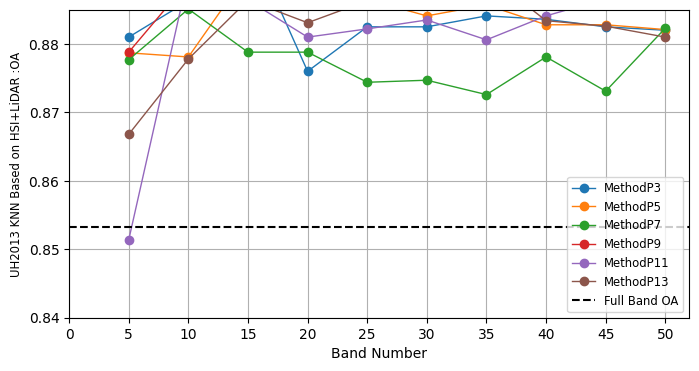

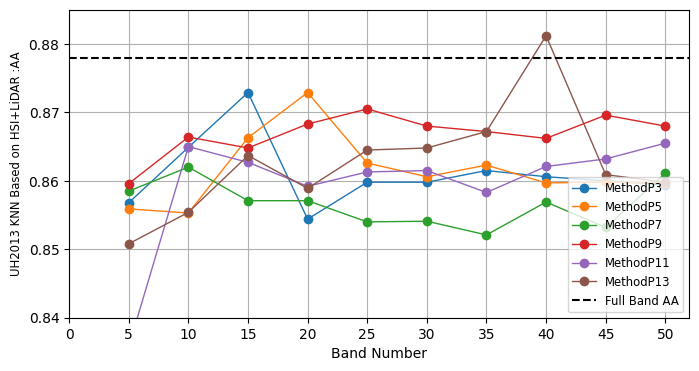

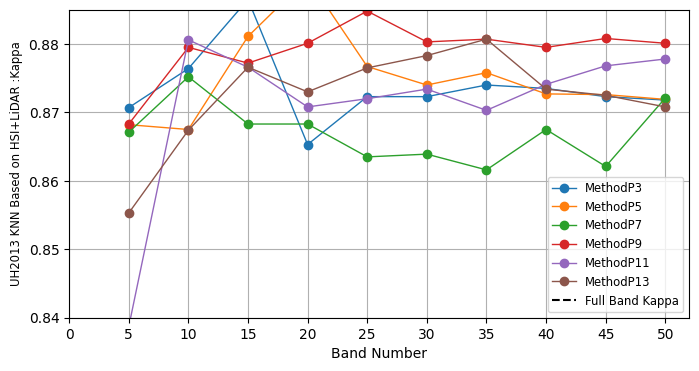

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
   'MethodP3':[ 0.882, 0.8594, 0.8718, 0.8825, 0.86, 0.8723, 0.8836, 0.8606, 0.8735, 0.8841, 0.8615, 0.874, 0.8825, 0.8598, 0.8723, 0.8825, 0.8598, 0.8723, 0.876, 0.8544, 0.8653, 0.8955, 0.8729, 0.8865, 0.8863, 0.8649, 0.8764, 0.881, 0.8568, 0.8707],
'MethodP5':[0.8821, 0.8597, 0.8719, 0.8828, 0.8598, 0.8726, 0.8828, 0.8597, 0.8727, 0.8857, 0.8623, 0.8758, 0.8841, 0.8606, 0.874, 0.8865, 0.8626, 0.8767, 0.8984, 0.8729, 0.8896, 0.8905, 0.8663, 0.8811, 0.8781, 0.8553, 0.8675, 0.8787, 0.8559, 0.8682],
'MethodP7': [0.8823, 0.8611, 0.8721, 0.8731, 0.8532, 0.8621, 0.8781, 0.8569, 0.8675, 0.8726, 0.8521, 0.8616, 0.8747, 0.8541, 0.8639, 0.8744, 0.854, 0.8635, 0.8788, 0.8571, 0.8683, 0.8788, 0.8571, 0.8683, 0.8851, 0.862, 0.8752, 0.8777, 0.8585, 0.8671],
'MethodP9': [0.8896, 0.868, 0.8801, 0.8903, 0.8696, 0.8808, 0.8891, 0.8662, 0.8795, 0.8902, 0.8672, 0.8807, 0.8898, 0.868, 0.8803, 0.894, 0.8705, 0.8848, 0.8896, 0.8683, 0.8801, 0.8869, 0.8648, 0.8772, 0.8891, 0.8664, 0.8795, 0.8788, 0.8596, 0.8683],
'MethodP11': [0.8875, 0.8655, 0.8778, 0.8866, 0.8632, 0.8768, 0.8841, 0.8621, 0.8741, 0.8806, 0.8583, 0.8703, 0.8835, 0.8615, 0.8734, 0.8822, 0.8613, 0.872, 0.881, 0.8592, 0.8708, 0.8864, 0.8627, 0.8766, 0.8901, 0.865, 0.8806, 0.8514, 0.8358, 0.8387],
'MethodP13': [0.881, 0.8598, 0.8708, 0.8826, 0.8609, 0.8725, 0.8834, 0.8812, 0.8734, 0.8902, 0.8672, 0.8807, 0.888, 0.8648, 0.8783, 0.8863, 0.8645, 0.8765, 0.8831, 0.8589, 0.873, 0.8864, 0.8637, 0.8766, 0.8778, 0.8554, 0.8674, 0.8668, 0.8508, 0.8553]
}

# Creating a DataFrame
df_uh2013_knn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['MethodP3','MethodP5', 'MethodP7', 'MethodP9', 'MethodP11',  'MethodP13']

full_bands = {'OA': 0.8532, 'AA': 0.8780, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_knn[df_uh2013_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')
    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 KNN Based on HSI+LiDAR :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.8400, 0.8850)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 5.4 KNN based based on HSI+LiDAR (3.5.7.9.11.13)  selected models and the other mthos comparison

In [ ]:
data_values = """0.8769	0.8569	0.8663	0.8787	0.8568	0.8682	0.8691	0.8501	0.8579	0.8741	0.8531	0.8632	0.8768	0.8559	0.8661	0.864	0.8445	0.8523	0.8829	0.8595	0.8728	0.8712	0.8506	0.8601	0.854	0.8355	0.8414	0.8512	0.8308	0.8385
0.8471	0.8277	0.8341	0.8474	0.8284	0.8344	0.8471	0.8289	0.8341	0.8459	0.8278	0.9328	0.8437	0.8265	0.8305	0.8441	0.8269	0.8309	0.8484	0.8303	0.8355	0.8524	0.8348	0.8399	0.8475	0.8327	0.8345	0.7764	0.7755	0.7578
0.8863	0.8648	0.8764	0.8869	0.8654	0.877	0.8844	0.8626	0.8744	0.8858	0.8639	0.8759	0.8834	0.8631	0.8734	0.8851	0.8651	0.8752	0.884	0.8636	0.874	0.8005	0.79	0.7838	0.7936	0.7843	0.7763	0.781	0.7786	0.7627
0.8888	0.8656	0.8792	0.8886	0.8659	0.8789	0.8866	0.8644	0.8768	0.886	0.8648	0.8779	0.8834	0.8628	0.8757	0.8851	0.864	0.8764	0.884	0.8635	0.8761	0.7994	0.7905	0.7826	0.792	0.7845	0.7746	0.7728	0.7694	0.7538
0.8713	0.8483	0.8602	0.871	0.8476	0.8598	0.8741	0.8514	0.8632	0.8737	0.8506	0.8628	0.8724	0.8488	0.8614	0.8714	0.8485	0.8603	0.8709	0.8476	0.8597	0.8718	0.8486	0.8607	0.8737	0.8495	0.8629	0.8778	0.8549	0.8672"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.8769, 0.8569, 0.8663, 0.8787, 0.8568, 0.8682, 0.8691, 0.8501, 0.8579, 0.8741, 0.8531, 0.8632, 0.8768, 0.8559, 0.8661, 0.864, 0.8445, 0.8523, 0.8829, 0.8595, 0.8728, 0.8712, 0.8506, 0.8601, 0.854, 0.8355, 0.8414, 0.8512, 0.8308, 0.8385
0.8471, 0.8277, 0.8341, 0.8474, 0.8284, 0.8344, 0.8471, 0.8289, 0.8341, 0.8459, 0.8278, 0.9328, 0.8437, 0.8265, 0.8305, 0.8441, 0.8269, 0.8309, 0.8484, 0.8303, 0.8355, 0.8524, 0.8348, 0.8399, 0.8475, 0.8327, 0.8345, 0.7764, 0.7755, 0.7578
0.8863, 0.8648, 0.8764, 0.8869, 0.8654, 0.877, 0.8844, 0.8626, 0.8744, 0.8858, 0.8639, 0.8759, 0.8834, 0.8631, 0.8734, 0.8851, 0.8651, 0.8752, 0.884, 0.8636, 0.874, 0.8005, 0.79, 0.7838, 0.7936, 0.7843, 0.7763, 0.781, 0.7786, 0.7627
0.8888, 0.8656, 0.8792, 0.8886, 0.8659, 0.8789, 0.8866, 0.8644, 0.8768, 0.886, 0.8648, 0.8779, 0.8834, 0.8628, 0.8757, 0.8851, 0.864, 0.8764, 0.884, 0.8635, 0.8761, 0.7994, 0.7905, 0.7826, 0.792, 0.7845, 0.7746, 0.7728, 0.7694, 0.7538
0.8713, 0.8483, 0.8602, 0.871, 0.8476, 0.8598, 0.8741, 0

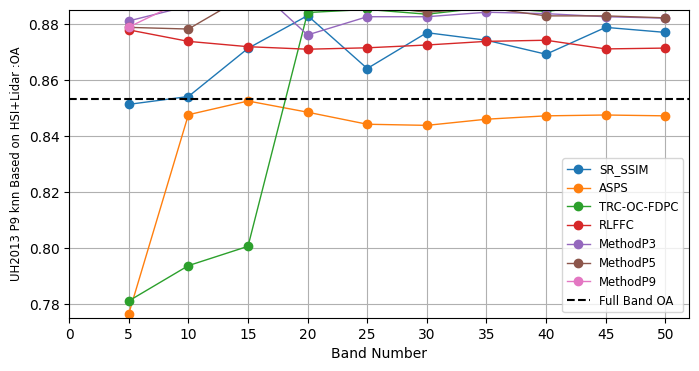

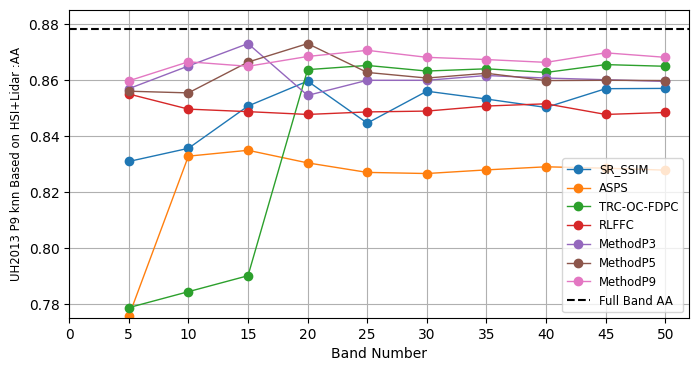

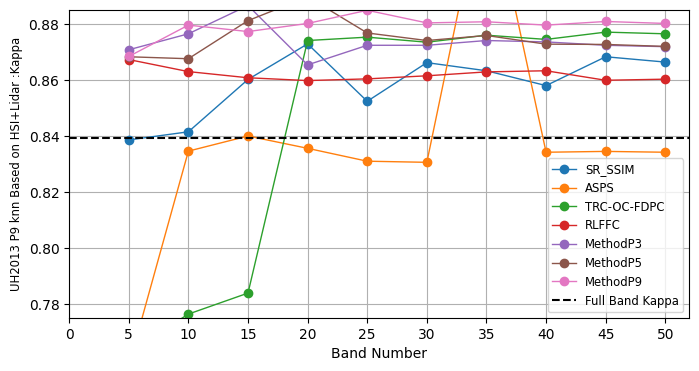

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5],
    "Metrics": ['OA', 'AA', 'Kappa']*10,
    'SR_SSIM': [0.8769, 0.8569, 0.8663, 0.8787, 0.8568, 0.8682, 0.8691, 0.8501, 0.8579, 0.8741, 0.8531, 0.8632, 0.8768, 0.8559, 0.8661, 0.864, 0.8445, 0.8523, 0.8829, 0.8595, 0.8728, 0.8712, 0.8506, 0.8601, 0.854, 0.8355, 0.8414, 0.8512, 0.8308, 0.8385],
'ASPS': [0.8471, 0.8277, 0.8341, 0.8474, 0.8284, 0.8344, 0.8471, 0.8289, 0.8341, 0.8459, 0.8278, 0.9328, 0.8437, 0.8265, 0.8305, 0.8441, 0.8269, 0.8309, 0.8484, 0.8303, 0.8355, 0.8524, 0.8348, 0.8399, 0.8475, 0.8327, 0.8345, 0.7764, 0.7755, 0.7578],
'TRC-OC-FDPC': [0.8863, 0.8648, 0.8764, 0.8869, 0.8654, 0.877, 0.8844, 0.8626, 0.8744, 0.8858, 0.8639, 0.8759, 0.8834, 0.8631, 0.8734, 0.8851, 0.8651, 0.8752, 0.884, 0.8636, 0.874, 0.8005, 0.79, 0.7838, 0.7936, 0.7843, 0.7763, 0.781, 0.7786, 0.7627],
'RRI_BS': [0.8888, 0.8656, 0.8792, 0.8886, 0.8659, 0.8789, 0.8866, 0.8644, 0.8768, 0.886, 0.8648, 0.8779, 0.8834, 0.8628, 0.8757, 0.8851, 0.864, 0.8764, 0.884, 0.8635, 0.8761, 0.7994, 0.7905, 0.7826, 0.792, 0.7845, 0.7746, 0.7728, 0.7694, 0.7538],
'RLFFC': [0.8713, 0.8483, 0.8602, 0.871, 0.8476, 0.8598, 0.8741, 0.8514, 0.8632, 0.8737, 0.8506, 0.8628, 0.8724, 0.8488, 0.8614, 0.8714, 0.8485, 0.8603, 0.8709, 0.8476, 0.8597, 0.8718, 0.8486, 0.8607, 0.8737, 0.8495, 0.8629, 0.8778, 0.8549, 0.8672],
 'MethodP3':[ 0.882, 0.8594, 0.8718, 0.8825, 0.86, 0.8723, 0.8836, 0.8606, 0.8735, 0.8841, 0.8615, 0.874, 0.8825, 0.8598, 0.8723, 0.8825, 0.8598, 0.8723, 0.876, 0.8544, 0.8653, 0.8955, 0.8729, 0.8865, 0.8863, 0.8649, 0.8764, 0.881, 0.8568, 0.8707],
'MethodP5':[0.8821, 0.8597, 0.8719, 0.8828, 0.8598, 0.8726, 0.8828, 0.8597, 0.8727, 0.8857, 0.8623, 0.8758, 0.8841, 0.8606, 0.874, 0.8865, 0.8626, 0.8767, 0.8984, 0.8729, 0.8896, 0.8905, 0.8663, 0.8811, 0.8781, 0.8553, 0.8675, 0.8787, 0.8559, 0.8682],
'MethodP9': [0.8896, 0.868, 0.8801, 0.8903, 0.8696, 0.8808, 0.8891, 0.8662, 0.8795, 0.8902, 0.8672, 0.8807, 0.8898, 0.868, 0.8803, 0.894, 0.8705, 0.8848, 0.8896, 0.8683, 0.8801, 0.8869, 0.8648, 0.8772, 0.8891, 0.8664, 0.8795, 0.8788, 0.8596, 0.8683]
}

# Creating a DataFrame
df_uh2013_knn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC', 'RLFFC','MethodP3', 'MethodP5', 'MethodP9']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_knn[df_uh2013_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 knn Based on HSI+Lidar :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.77500, 0.8850)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

# 7, Test Data based HSI as input at AUtoencoder module
7.0. Plot Based on SVM Test (HSI Comparison Only )

## 7.1 Ablation Study (HSI)

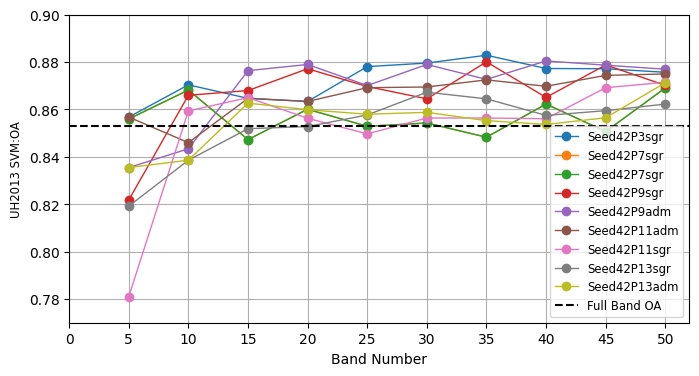

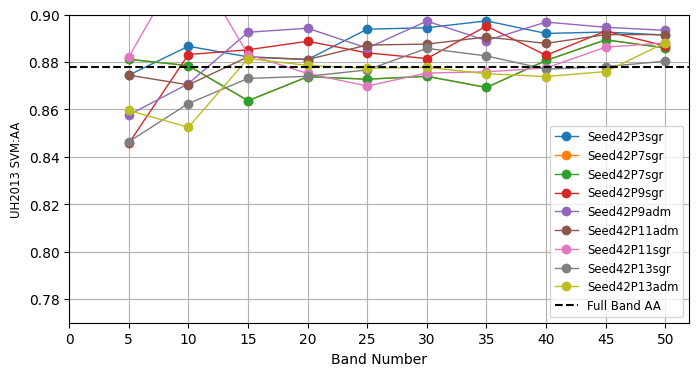

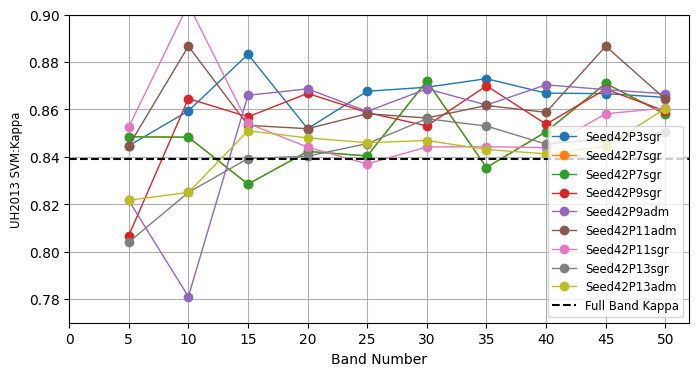

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study)# Remove 1
data = {
 'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5,] * 3,
    'Metrics': ['OA'] * 10 + ['AA'] * 10 + ['Kappa'] * 10,
      'Seed42P3sgr': [0.8757, 0.8772, 0.8773, 0.8829, 0.8796, 0.8781, 0.8634, 0.8647, 0.8704, 0.8568,
                    0.8914, 0.8927, 0.8921, 0.8974, 0.8945, 0.8939, 0.8811, 0.8822, 0.8867, 0.8745,
                    0.8651, 0.8667, 0.8669, 0.8730, 0.8694, 0.8677, 0.8519, 0.8833, 0.8594, 0.8447],
    'Seed42P5sgr': [0.8794, 0.8804, 0.8796, 0.8805, 0.8774, 0.8799, 0.8859, 0.8687, 0.8419, 0.8474,
                    0.8950, 0.8963, 0.8958, 0.8966, 0.8938, 0.8953, 0.8986, 0.8868, 0.8668, 0.8705,
                    0.8692, 0.8702, 0.8693, 0.8704, 0.8670, 0.8697, 0.8762, 0.8677, 0.8287, 0.8347],
     'Seed42P7sgr': [0.8691, 0.8507, 0.8623, 0.8483, 0.8543, 0.8529, 0.8601, 0.8473, 0.8682, 0.8560,
                     0.8860, 0.8894, 0.8807, 0.8693, 0.8740, 0.8728, 0.8738, 0.8637, 0.8785, 0.8812,
                    0.8580, 0.8710, 0.8506, 0.8355, 0.8720, 0.8404, 0.8423, 0.8285, 0.8483, 0.8485],
     'Seed42P9sgr': [0.8702, 0.8788, 0.8651, 0.8801, 0.8645, 0.8697, 0.8772, 0.8680, 0.8660, 0.8218,
                    0.8868, 0.8931, 0.8829, 0.8952, 0.8815, 0.8839, 0.8888, 0.8852, 0.8832, 0.8457,
                    0.8593, 0.8686, 0.8538, 0.8700, 0.8531, 0.8587, 0.8668, 0.8569, 0.8646, 0.8068],
     'Seed42P9adm': [0.8770, 0.8787, 0.8805, 0.8727, 0.8790, 0.8701, 0.8790, 0.8764, 0.8434, 0.8355,
                    0.8934, 0.8947, 0.8969, 0.8891, 0.8973, 0.8859, 0.8943, 0.8926, 0.8709, 0.8577,
                    0.8666, 0.8684, 0.8704, 0.8619, 0.8687,0.8592, 0.8687, 0.8660, 0.7810, 0.8216],
      'Seed42P11adm': [0.8750, 0.8744, 0.8698, 0.8725, 0.8695, 0.8692, 0.8634, 0.8647, 0.8460, 0.8568,
                      0.8916, 0.8916, 0.8879, 0.8906, 0.8876, 0.8872, 0.8811, 0.8822, 0.8704, 0.8745,
                      0.8644, 0.8867, 0.8588, 0.8617, 0.8564, 0.8582, 0.8519, 0.8533, 0.8867, 0.8447],
      'Seed42P11sgr': [0.8715, 0.8692, 0.8561, 0.8564, 0.8564, 0.8497, 0.8563, 0.8650, 0.8594, 0.7810,
                    0.8881, 0.8863, 0.87752, 0.8759, 0.8754, 0.8699, 0.8752, 0.8832, 0.9259, 0.8822,
                    0.8606, 0.8582, 0.8439, 0.8443, 0.8442, 0.8370, 0.8441, 0.8541, 0.9044, 0.8526],
     'Seed42P13sgr': [0.8623, 0.8595, 0.8575, 0.8645, 0.8673, 0.8577, 0.8528, 0.8519, 0.8386, 0.8192,
                     0.8804, 0.8781, 0.8770, 0.8826, 0.8858, 0.8767, 0.8740, 0.8731, 0.8625, 0.8464,
                     0.8506, 0.8476, 0.8454, 0.8530, 0.8561, 0.8456, 0.8403, 0.8393, 0.8250, 0.8040],
     'Seed42P13adm': [0.8713, 0.8565, 0.8537, 0.8553, 0.8588, 0.8580, 0.8599, 0.8627, 0.8386, 0.8355,
                     0.8882, 0.8760, 0.8739, 0.8751, 0.8778, 0.8774, 0.8786, 0.8815, 0.8525, 0.8596,
                     0.8604, 0.8444, 0.8413, 0.8431, 0.8469, 0.8460, 0.8480, 0.8510, 0.8250, 0.8217]

}

# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = [ 'Seed42P3sgr','Seed42P7sgr', 'Seed42P7sgr', 'Seed42P9sgr',  'Seed42P9adm', 'Seed42P11adm','Seed42P11sgr',  'Seed42P13sgr','Seed42P13adm']

full_bands = {'OA': 0.8532, 'AA': 0.8780, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7700, 0.9000)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

###7.2  The best Personal MEthod sgrp7 and other mehtod comparison

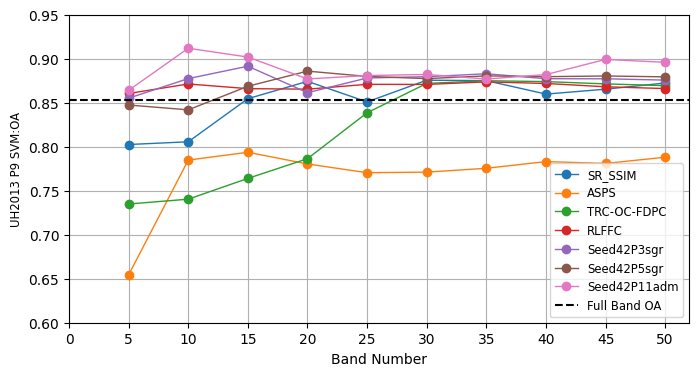

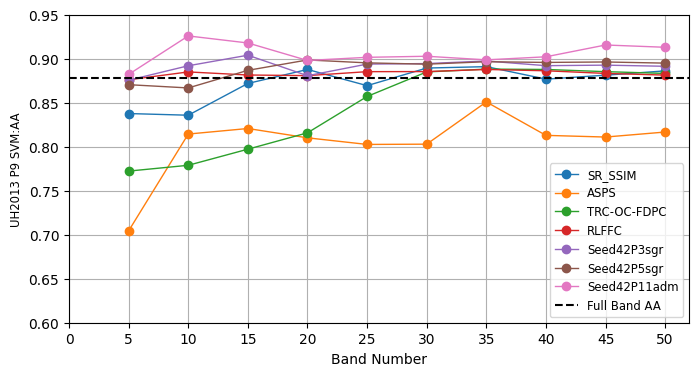

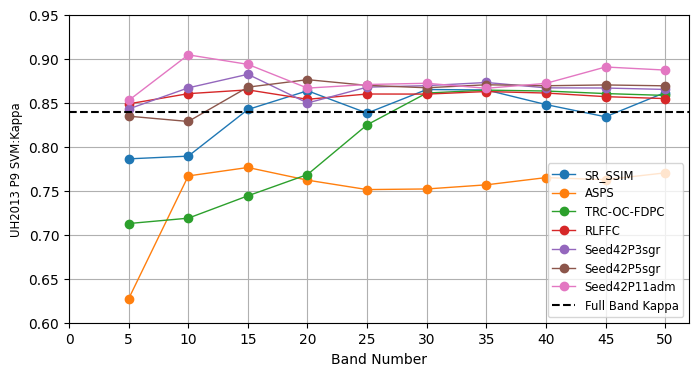

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data (HSI only) Remove 1
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5] * 3,
    'Metrics': ['OA'] * 10 + ['AA'] * 10 + ['Kappa'] * 10,
    'SR_SSIM': [0.8724, 0.8654, 0.8598, 0.8751, 0.8756, 0.8509, 0.8743, 0.8546, 0.8056, 0.8025,
                0.8862, 0.8813, 0.8768, 0.8910, 0.8894, 0.8694, 0.8878, 0.8719, 0.8358, 0.8377,
                0.8616, 0.834, 0.8479, 0.8645, 0.8650, 0.8382, 0.8636, 0.8423, 0.7893, 0.7862],
    'ASPS': [0.7881, 0.7810, 0.7831, 0.7755, 0.7711, 0.7705, 0.7804, 0.7937, 0.7848, 0.6544,
             0.8167, 0.8110, 0.8129, 0.8509, 0.8029, 0.8026, 0.8101, 0.8207, 0.8144, 0.7044,
             0.7703, 0.7626, 0.7649, 0.7567, 0.7520, 0.7513, 0.7620, 0.7764, 0.7668, 0.6272],
      'TRC-OC-FDPC': [0.8694, 0.8714, 0.8740, 0.8750, 0.8719, 0.8386, 0.7864, 0.7640, 0.7404, 0.7349,
                     0.8833, 0.8853, 0.8878, 0.8882, 0.8850, 0.8571, 0.8158, 0.7972, 0.7789, 0.7723,
                     0.8583, 0.8604, 0.8633, 0.8643, 0.8610, 0.8249, 0.7684, 0.7442, 0.7188, 0.7127],
      'RRI_BS': [0.8724, 0.8713, 0.8735, 0.8747, 0.8724, 0.8695, 0.8714, 0.6807, 0.6684, 0.6107,
                0.8860, 0.8840, 0.8858, 0.8865, 0.8852, 0.8809, 0.8833, 0.7261, 0.7141, 0.6658,
                0.8616, 0.8604, 0.8628, 0.8641, 0.8616, 0.8584, 0.8605, 0.6548, 0.6420, 0.5801],
      'RLFFC': [0.8661, 0.8681, 0.8719, 0.8737, 0.8708, 0.8709, 0.8654, 0.8660, 0.8713, 0.8605,
                  0.8814, 0.8833, 0.8863, 0.8878, 0.8854, 0.8853, 0.8808, 0.8815, 0.8850, 0.8761,
                  0.8547,0.8569, 0.8610, 0.8627, 0.8598, 0.8599, 0.8539, 0.8646, 0.8603, 0.8487],
      "Seed42P3sgr": [0.8757, 0.8772, 0.8773, 0.8829, 0.8796, 0.8781, 0.8614, 0.8915, 0.8774, 0.8552,
                    0.8914, 0.8927, 0.8921, 0.8974, 0.8945, 0.8939, 0.8807, 0.9040, 0.8920, 0.8756,
                    0.8651, 0.8667, 0.8669, 0.8730, 0.8694, 0.8677, 0.8497, 0.8823, 0.8669, 0.8429],
    "Seed42P5sgr": [0.8794, 0.8804, 0.8796, 0.8805, 0.8774, 0.8799, 0.8859, 0.8687, 0.8419, 0.8474,
                    0.8950, 0.8963, 0.8958, 0.8966, 0.8938, 0.8953, 0.8986, 0.8868, 0.8668, 0.8705,
                    0.8692, 0.8702, 0.8693, 0.8704, 0.8670, 0.8697, 0.8762, 0.8677, 0.8287, 0.8347],
      'Seed42P11adm': [0.8959, 0.8992, 0.8820, 0.8769, 0.8821, 0.8809, 0.8770, 0.9019, 0.9119, 0.8641,
                    0.9130, 0.9156, 0.9022, 0.8987, 0.9028, 0.9016, 0.8980, 0.9179, 0.9259, 0.8822,
                    0.8871, 0.8906, 0.8720, 0.8664, 0.8721, 0.8707, 0.8666, 0.8936, 0.9044, 0.8526]
}

# # UH2013 SVM test data (HSI only)
# data = {
#     'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
#     'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
#     'SR_SSIM': [0.8724, 0.8654, 0.8598, 0.8751, 0.8756, 0.8509, 0.8743, 0.8546, 0.8056, 0.8025, 0.5784,
#                 0.8862, 0.8813, 0.8768, 0.8910, 0.8894, 0.8694, 0.8878, 0.8719, 0.8358, 0.8377, 0.6396,
#                 0.8616, 0.834, 0.8479, 0.8645, 0.8650, 0.8382, 0.8636, 0.8423, 0.7893, 0.7862, 0.5459],
#     'ASPS': [0.7881, 0.7810, 0.7831, 0.7755, 0.7711, 0.7705, 0.7804, 0.7937, 0.7848, 0.6544, 0.4165,
#              0.8167, 0.8110, 0.8129, 0.8509, 0.8029, 0.8026, 0.8101, 0.8207, 0.8144, 0.7044, 0.4993,
#              0.7703, 0.7626, 0.7649, 0.7567, 0.7520, 0.7513, 0.7620, 0.7764, 0.7668, 0.6272, 0.4565],
#      'OPBS': [0.8690, 0.8689, 0.8623, 0.8615, 0.8623, 0.8569, 0.8590, 0.8604, 0.8669, 0.8446, 0.4886,
#               0.8847, 0.8850, 0.8789, 0.8785, 0.8796, 0.8743, 0.8760, 0.8774, 0.8827, 0.8638, 0.5231,
#               0.8579, 0.8578, 0.8507, 0.8498, 0.8506, 0.8447, 0.8470, 0.8485, 0.8556, 0.8314, 0.4485],
#       'TRC-OC-FDPC': [0.8694, 0.8714, 0.8740, 0.8750, 0.8719, 0.8386, 0.7864, 0.7640, 0.7404, 0.7349, 0.4590,
#                      0.8833, 0.8853, 0.8878, 0.8882, 0.8850, 0.8571, 0.8158, 0.7972, 0.7789, 0.7723, 0.5138,
#                      0.8583, 0.8604, 0.8633, 0.8643, 0.8610, 0.8249, 0.7684, 0.7442, 0.7188, 0.7127, 0.4203],
#       'RRI_BS': [0.8724, 0.8713, 0.8735, 0.8747, 0.8724, 0.8695, 0.8714, 0.6807, 0.6684, 0.6107, 0.4786,
#                 0.8860, 0.8840, 0.8858, 0.8865, 0.8852, 0.8809, 0.8833, 0.7261, 0.7141, 0.6658, 0.5271,
#                 0.8616, 0.8604, 0.8628, 0.8641, 0.8616, 0.8584, 0.8605, 0.6548, 0.6420, 0.5801, 0.4406],
#       'RLFFC': [0.8661, 0.8681, 0.8719, 0.8737, 0.8708, 0.8709, 0.8654, 0.8660, 0.8713, 0.8605, 0.5183,
#                   0.8814, 0.8833, 0.8863, 0.8878, 0.8854, 0.8853, 0.8808, 0.8815, 0.8850, 0.8761, 0.5778,
#                   0.8547,0.8569, 0.8610, 0.8627, 0.8598, 0.8599, 0.8539, 0.8646, 0.8603, 0.8487, 0.4827],

#        'Seed42P7sgr': [0.9044, 0.8811, 0.9032, 0.8822, 0.8919, 0.8946, 0.9064, 0.8890, 0.9107, 0.9160, 0.7365,
#                     0.9177, 0.8894, 0.9166, 0.9003, 0.9073, 0.9093, 0.9191, 0.9056, 0.9212, 0.9258, 0.7824,
#                     0.8962, 0.8710, 0.8949, 0.8721, 0.8826, 0.8856, 0.8984, 0.8795, 0.9031, 0.9088, 0.7159],
# }
# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TRC-OC-FDPC', 'RLFFC','Seed42P3sgr','Seed42P5sgr', 'Seed42P11adm']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 P9 SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6000, 0.9500)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

# 8 Plot based on SVM HSI+LiDAR  Test Only

###8.1 UH2013 HSI+LiDAR Ablation study SVM

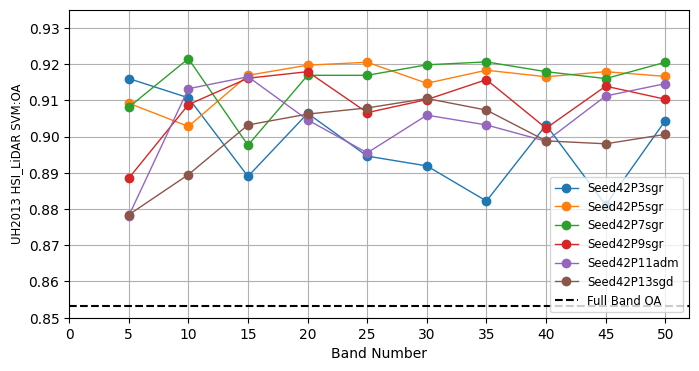

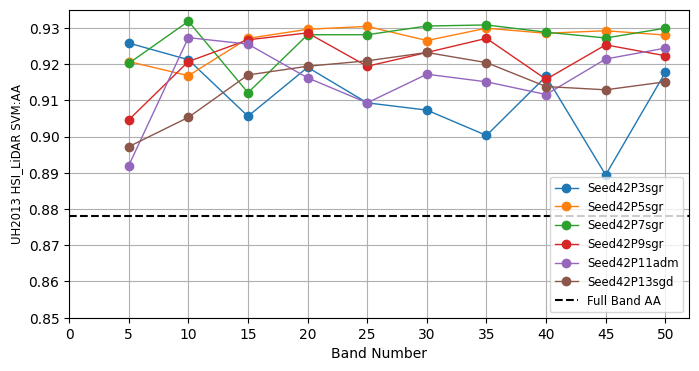

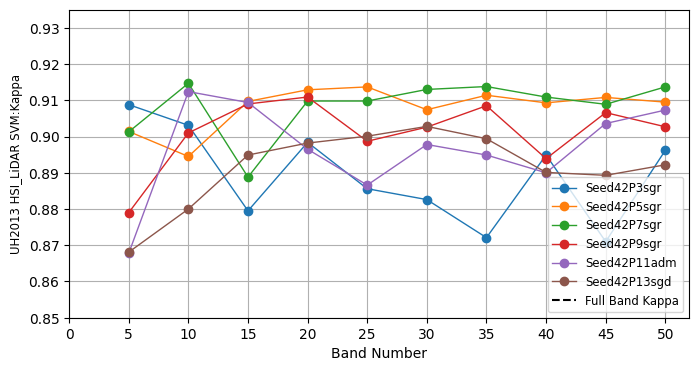

In [ ]:
# Test Result on Jan. 15.2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study) for HSI+LiDAR
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5] * 3,
    'Metrics': ['OA'] * 10 + ['AA'] * 10 + ['Kappa'] * 10,
    'Seed42P7sgr': [0.9205, 0.9160, 0.9179, 0.9206, 0.9198, 0.9169, 0.9169, 0.8976, 0.9215, 0.9081,
                    0.9299, 0.9272, 0.9288, 0.9308, 0.9305, 0.9281, 0.9281, 0.9121, 0.9318, 0.9202,
                    0.9137, 0.9089, 0.9109, 0.9138, 0.9130, 0.9098, 0.9098, 0.8888, 0.9147, 0.9013],
    'Seed42P5sgr': [0.9166, 0.9179, 0.9165, 0.9183, 0.9147, 0.9205, 0.9197, 0.9169, 0.9028, 0.9092,
                    0.9280, 0.9292, 0.9285, 0.9299, 0.9265, 0.9304, 0.9296, 0.9271, 0.9168, 0.9207,
                    0.9095, 0.9108, 0.9093, 0.9114, 0.9074, 0.9137, 0.9129, 0.9097, 0.8945, 0.9014],
    'Seed42P3sgr': [0.9044, 0.8811, 0.9032, 0.8822, 0.8919, 0.8946, 0.9064, 0.8890, 0.9107, 0.9160,
                    0.9177, 0.8894, 0.9166, 0.9003, 0.9073, 0.9093, 0.9191, 0.9056, 0.9212, 0.9258,
                    0.8962, 0.8710, 0.8949, 0.8721, 0.8826, 0.8856, 0.8984, 0.8795, 0.9031, 0.9088],
    'Seed42P9sgr': [0.9103, 0.9139, 0.9023, 0.9157, 0.9102, 0.9066, 0.9179, 0.9161, 0.9088, 0.8885,
                    0.9223, 0.9253, 0.9158, 0.9271, 0.9232, 0.9194, 0.9286, 0.9267, 0.9207, 0.9046,
                    0.9027, 0.9066, 0.8939, 0.9085, 0.9026, 0.8987, 0.9109, 0.9090, 0.9010, 0.8790],
    #'Seed42P11sgd': [0.9105, 0.9061, 0.8866, 0.8897, 0.8935, 0.8870, 0.8919, 0.9123, 0.9156, 0.8659,
       #             0.9234, 0.9192, 0.9042, 0.9074, 0.9096, 0.9042, 0.9075, 0.9231, 0.9254, 0.8836,
       #             0.9028, 0.8981, 0.8769, 0.8803, 0.8844, 0.8774, 0.8827, 0.9048, 0.9083, 0.8545],
    'Seed42P11adm':[0.9146,0.9112,0.8987,0.9032,0.9059,0.8955,0.9046,0.9165,0.9132,0.8781,
                    0.9244,0.9214,0.9116,0.9151,0.9172,0.9093,0.9162,0.9255,0.9273,0.8920,
                     0.9073,0.9036,0.8900,0.8949,0.8978,0.8866,0.8965,0.9094,0.9124,0.8678],
    'Seed42P13sgd': [0.9006, 0.8980, 0.8988, 0.9073, 0.9105, 0.9079, 0.9062, 0.9032, 0.8895, 0.8784,
                     0.9151, 0.9129, 0.9138, 0.9204, 0.9232, 0.9209, 0.9194, 0.9170, 0.9053, 0.8972,
                     0.8922, 0.8893, 0.8901, 0.8994, 0.9028, 0.9001, 0.8982, 0.8949, 0.8800, 0.8681],
    }

# # UH2013 SVM test data(Ablation study) for HSI+LiDAR
# data = {
#     'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
#     'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
#     'Seed42P3sgr': [0.9205, 0.9160, 0.9179, 0.9206, 0.9198, 0.9169, 0.9169, 0.8976, 0.9215, 0.9081, 0.6734,
#                     0.9299, 0.9272, 0.9288, 0.9308, 0.9305, 0.9281, 0.9281, 0.9121, 0.9318, 0.9202, 0.7175,
#                     0.9137, 0.9089, 0.9109, 0.9138, 0.9130, 0.9098, 0.9098, 0.8888, 0.9147, 0.9013, 0.6479],
#     'Seed42P5sgr': [0.9166, 0.9179, 0.9165, 0.9183, 0.9147, 0.9205, 0.9197, 0.9169, 0.9028, 0.9092, 0.6671,
#                     0.9280, 0.9292, 0.9285, 0.9299, 0.9265, 0.9304, 0.9296, 0.9271, 0.9168, 0.9207, 0.7179,
#                     0.9095, 0.9108, 0.9093, 0.9114, 0.9074, 0.9137, 0.9129, 0.9097, 0.8945, 0.9014, 0.6412],
#     'Seed42P7sgr': [0.9044, 0.8811, 0.9032, 0.8822, 0.8919, 0.8946, 0.9064, 0.8890, 0.9107, 0.9160, 0.7365,
#                     0.9177, 0.8894, 0.9166, 0.9003, 0.9073, 0.9093, 0.9191, 0.9056, 0.9212, 0.9258, 0.7824,
#                     0.8962, 0.8710, 0.8949, 0.8721, 0.8826, 0.8856, 0.8984, 0.8795, 0.9031, 0.9088, 0.7159],
#     'Seed42P9sgr': [0.9103, 0.9139, 0.9023, 0.9157, 0.9102, 0.9066, 0.9179, 0.9161, 0.9088, 0.8885, 0.6607,
#                     0.9223, 0.9253, 0.9158, 0.9271, 0.9232, 0.9194, 0.9286, 0.9267, 0.9207, 0.9046, 0.7133,
#                     0.9027, 0.9066, 0.8939, 0.9085, 0.9026, 0.8987, 0.9109, 0.9090, 0.9010, 0.8790, 0.6349],
#     'Seed42P9adm': [0.9131, 0.9065, 0.9071, 0.9106, 0.9096, 0.9091, 0.8882, 0.8474, 0.8852, 0.8853, 0.7800,
#                     0.9246, 0.9198, 0.9201, 0.9234, 0.9224, 0.9221, 0.9050, 0.8729, 0.9019, 0.9024, 0.8110,
#                     0.9057, 0.8985, 0.8892, 0.9030, 0.9018, 0.9013, 0.8786, 0.8345, 0.8754, 0.8755, 0.7622],

#       'Seed42P11sgd': [0.9105, 0.9061, 0.8866, 0.8897, 0.8935, 0.8870, 0.8919, 0.9123, 0.9156, 0.8659, 0.6846,
#                       0.9234, 0.9192, 0.9042, 0.9074, 0.9096, 0.9042, 0.9075, 0.9231, 0.9254, 0.8836, 0.7223,
#                       0.9028, 0.8981, 0.8769, 0.8803, 0.8844, 0.8774, 0.8827, 0.9048, 0.9083, 0.8545, 0.6595],
#       'Seed42P11adm': [0.9146, 0.9112, 0.8987, 0.9032, 0.9059, 0.8955, 0.9046, 0.9165, 0.9132, 0.8781, 0.6748,
#                       0.9244, 0.9214, 0.9116, 0.9151, 0.9172, 0.9093, 0.9162, 0.9255, 0.9273, 0.8920, 0.7080,
#                       0.9073, 0.9036, 0.8900, 0.8949, 0.8978, 0.8866, 0.8965, 0.9094, 0.9124, 0.8678, 0.6486],
#      'Seed42P13sgd': [0.9006, 0.8980, 0.8988, 0.9073, 0.9105, 0.9079, 0.9062, 0.9032, 0.8895, 0.8784, 0.7574,
#                       0.9151, 0.9129, 0.9138, 0.9204, 0.9232, 0.9209, 0.9194, 0.9170, 0.9053, 0.8972, 0.7965,
#                       0.8922, 0.8893, 0.8901, 0.8994, 0.9028, 0.9001, 0.8982, 0.8949, 0.8800, 0.8681, 0.7381],
#      'Seed42P13adm': [0.9159, 0.8910, 0.8889, 0.8983, 0.9079, 0.8991, 0.9063, 0.9108, 0.8895, 0.8900, 0.6555,
#                       0.9274, 0.9075, 0.9059, 0.9136, 0.9208, 0.9135, 0.9195, 0.9233, 0.9053, 0.9060, 0.7225,
#                       0.9087, 0.8816, 0.8794, 0.8897, 0.9005, 0.8905, 0.8983, 0.9032, 0.8800, 0.8806, 0.6383]
#     }
# Creating a DataFrame
df_uh2013_hsiLidar_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['Seed42P3sgr','Seed42P5sgr', 'Seed42P7sgr', 'Seed42P9sgr',  'Seed42P11adm', 'Seed42P13sgd']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsiLidar_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsiLidar_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_LiDAR SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.8500, 0.93500)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

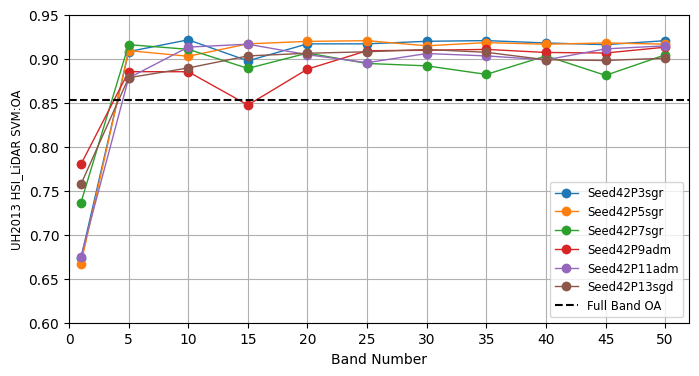

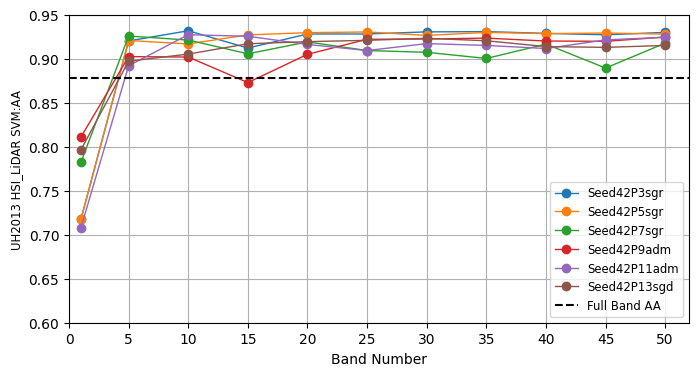

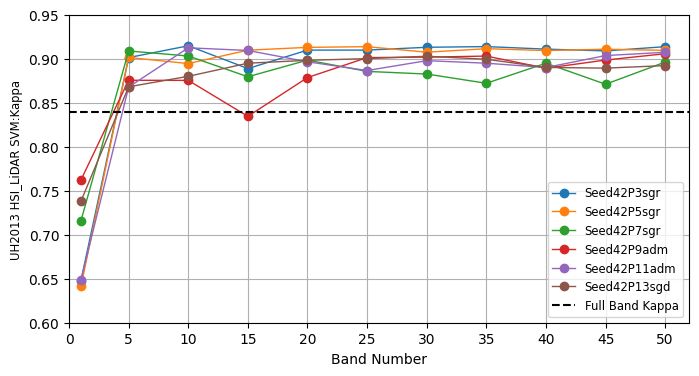

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data(Ablation study) for HSI+Lidar
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'Seed42P3sgr': [0.9205, 0.9160, 0.9179, 0.9206, 0.9198, 0.9169, 0.9169, 0.8976, 0.9215, 0.9081, 0.6734,
                    0.9299, 0.9272, 0.9288, 0.9308, 0.9305, 0.9281, 0.9281, 0.9121, 0.9318, 0.9202, 0.7175,
                    0.9137, 0.9089, 0.9109, 0.9138, 0.9130, 0.9098, 0.9098, 0.8888, 0.9147, 0.9013, 0.6479],
    'Seed42P5sgr': [0.9166, 0.9179, 0.9165, 0.9183, 0.9147, 0.9205, 0.9197, 0.9169, 0.9028, 0.9092, 0.6671,
                    0.9280, 0.9292, 0.9285, 0.9299, 0.9265, 0.9304, 0.9296, 0.9271, 0.9168, 0.9207, 0.7179,
                    0.9095, 0.9108, 0.9093, 0.9114, 0.9074, 0.9137, 0.9129, 0.9097, 0.8945, 0.9014, 0.6412],
    'Seed42P7sgr': [0.9044, 0.8811, 0.9032, 0.8822, 0.8919, 0.8946, 0.9064, 0.8890, 0.9107, 0.9160, 0.7365,
                    0.9177, 0.8894, 0.9166, 0.9003, 0.9073, 0.9093, 0.9191, 0.9056, 0.9212, 0.9258, 0.7824,
                    0.8962, 0.8710, 0.8949, 0.8721, 0.8826, 0.8856, 0.8984, 0.8795, 0.9031, 0.9088, 0.7159],

    'Seed42P9adm': [0.9131, 0.9065, 0.9071, 0.9106, 0.9096, 0.9091, 0.8882, 0.8474, 0.8852, 0.8853, 0.7800,
                    0.9246, 0.9198, 0.9201, 0.9234, 0.9224, 0.9221, 0.9050, 0.8729, 0.9019, 0.9024, 0.8110,
                    0.9057, 0.8985, 0.8892, 0.9030, 0.9018, 0.9013, 0.8786, 0.8345, 0.8754, 0.8755, 0.7622],

      'Seed42P11adm': [0.9146, 0.9112, 0.8987, 0.9032, 0.9059, 0.8955, 0.9046, 0.9165, 0.9132, 0.8781, 0.6748,
                      0.9244, 0.9214, 0.9116, 0.9151, 0.9172, 0.9093, 0.9162, 0.9255, 0.9273, 0.8920, 0.7080,
                      0.9073, 0.9036, 0.8900, 0.8949, 0.8978, 0.8866, 0.8965, 0.9094, 0.9124, 0.8678, 0.6486],
     'Seed42P13sgd': [0.9006, 0.8980, 0.8988, 0.9073, 0.9105, 0.9079, 0.9062, 0.9032, 0.8895, 0.8784, 0.7574,
                      0.9151, 0.9129, 0.9138, 0.9204, 0.9232, 0.9209, 0.9194, 0.9170, 0.9053, 0.8972, 0.7965,
                      0.8922, 0.8893, 0.8901, 0.8994, 0.9028, 0.9001, 0.8982, 0.8949, 0.8800, 0.8681, 0.7381],

    }
# Creating a DataFrame
df_uh2013_hsiLidar_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['Seed42P3sgr','Seed42P5sgr', 'Seed42P7sgr', 'Seed42P9adm',  'Seed42P11adm', 'Seed42P13sgd']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsiLidar_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsiLidar_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_LiDAR SVM:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6000, 0.9500)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 8.2 SGR P7 and other methods comparison

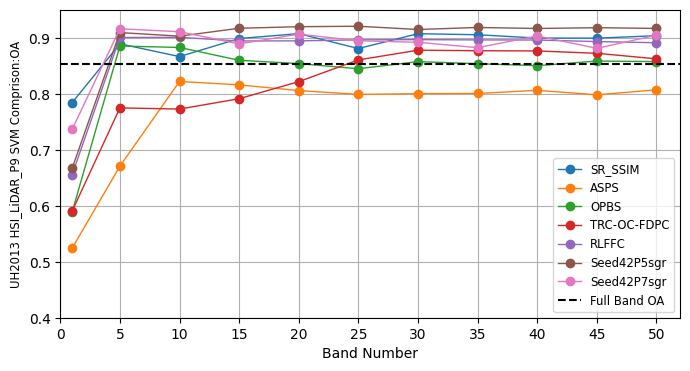

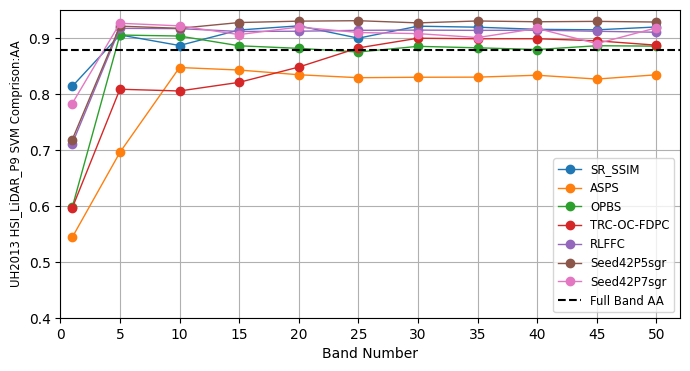

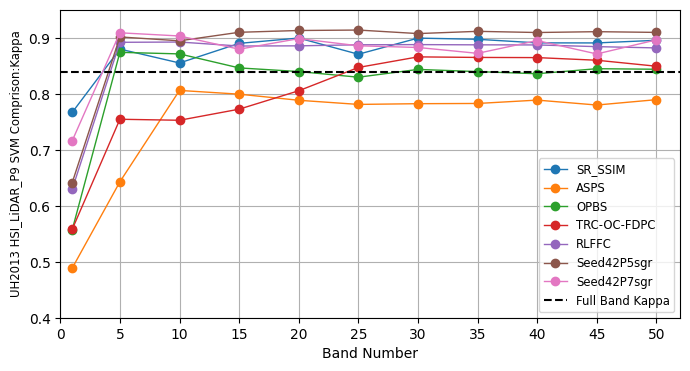

In [ ]:
# Test Result on Sep. 25.2023
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 SVM test data (HSI only)
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
   'SR_SSIM': [0.9036, 0.8992, 0.8994, 0.9053, 0.9072, 0.8807, 0.9073, 0.8985, 0.8663, 0.8891, 0.7842,
                0.9192, 0.9141, 0.9150, 0.9188, 0.9206, 0.8992, 0.9212, 0.9138, 0.8861, 0.9050, 0.8131,
                0.8954, 0.8907, 0.8908, 0.8972, 0.8993, 0.8705, 0.8994, 0.8899, 0.8549, 0.8797, 0.7666],
    'ASPS': [0.8070, 0.7980, 0.8061, 0.8004, 0.8001, 0.7988, 0.8056, 0.8158, 0.8219, 0.6706, 0.5243,
             0.8338, 0.8262, 0.8330, 0.8296, 0.8294, 0.8286, 0.8339, 0.8423, 0.8468, 0.6952, 0.5434,
             0.7894, 0.7798, 0.7886, 0.7826, 0.7822, 0.7809, 0.7883, 0.7992, 0.8059, 0.6427, 0.4885],
    'OPBS': [0.8574, 0.8583, 0.8501, 0.8536, 0.8573, 0.8446, 0.8538, 0.8597, 0.8826, 0.8852, 0.5891,
            0.8850, 0.8857, 0.8789, 0.8820, 0.8846, 0.8745, 0.8810, 0.8856, 0.9030, 0.9048, 0.5970,
            0.8437, 0.8447, 0.8357, 0.8395, 0.8434, 0.8295, 0.8396, 0.8461, 0.8711, 0.8739, 0.5570],
    'TRC-OC-FDPC': [0.8623, 0.8722, 0.8764, 0.8768, 0.8777, 0.8604, 0.8216, 0.7911, 0.7726, 0.7747, 0.5906,
                   0.8867, 0.8945, 0.8982, 0.8981, 0.8991, 0.8818, 0.8476, 0.8203, 0.8049, 0.8080, 0.5957,
                   0.8491, 0.8598, 0.8645, 0.8648, 0.8658, 0.8469, 0.8053, 0.7724, 0.7526, 0.7544, 0.5578],
    'RRI_BS': [0.9104, 0.9120, 0.9119, 0.9141, 0.9038, 0.9094, 0.9106, 0.7756, 0.7686, 0.7106, 0.6728,
               0.9210, 0.9223, 0.9224, 0.9242, 0.9179, 0.9202, 0.9212, 0.8104, 0.8063, 0.7580, 0.7166,
              0.9027, 0.9045, 0.9044, 0.9067, 0.8956, 0.9017, 0.9030, 0.7574, 0.7499, 0.6873, 0.6471],
    'RLFFC': [0.8910, 0.8931, 0.8959, 0.8961, 0.8966, 0.8962, 0.8944, 0.8942, 0.9007, 0.9004, 0.6556,
             0.9098, 0.9115, 0.9135, 0.9131, 0.9136, 0.9132, 0.9116, 0.9112, 0.9162, 0.9167, 0.7105,
             0.8818, 0.8841, 0.8871, 0.8873, 0.8877, 0.8874, 0.8855, 0.8852, 0.8923, 0.8918, 0.6294],
    'Seed42P5sgr': [0.9166, 0.9179, 0.9165, 0.9183, 0.9147, 0.9205, 0.9197, 0.9169, 0.9028, 0.9092, 0.6671,
                    0.9280, 0.9292, 0.9285, 0.9299, 0.9265, 0.9304, 0.9296, 0.9271, 0.9168, 0.9207, 0.7179,
                    0.9095, 0.9108, 0.9093, 0.9114, 0.9074, 0.9137, 0.9129, 0.9097, 0.8945, 0.9014, 0.6412],

    'Seed42P7sgr': [0.9044, 0.8811, 0.9032, 0.8822, 0.8919, 0.8946, 0.9064, 0.8890, 0.9107, 0.9160, 0.7365,
                    0.9177, 0.8894, 0.9166, 0.9003, 0.9073, 0.9093, 0.9191, 0.9056, 0.9212, 0.9258, 0.7824,
                    0.8962, 0.8710, 0.8949, 0.8721, 0.8826, 0.8856, 0.8984, 0.8795, 0.9031, 0.9088, 0.7159]
}
# Creating a DataFrame
df_uh2013_svm = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS', 'OPBS', 'TRC-OC-FDPC', 'RLFFC', 'Seed42P5sgr','Seed42P7sgr']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_svm['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_svm[df_uh2013_svm['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_LiDAR_P9 SVM Comprison:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.4000, 0.9500)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

#9 Plot Based on KNN (HSI+LIDAR)





### 9.1 KNN HSI only (Our mehtod)

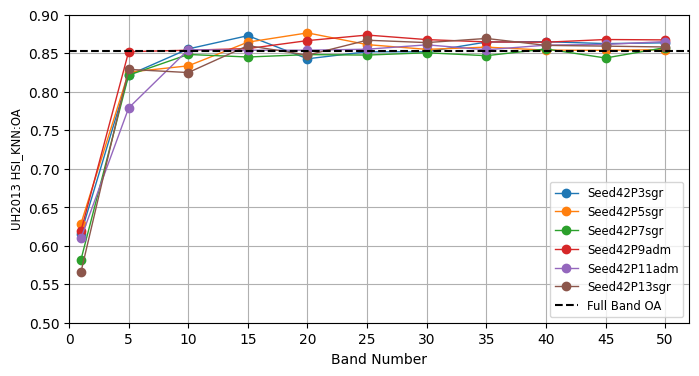

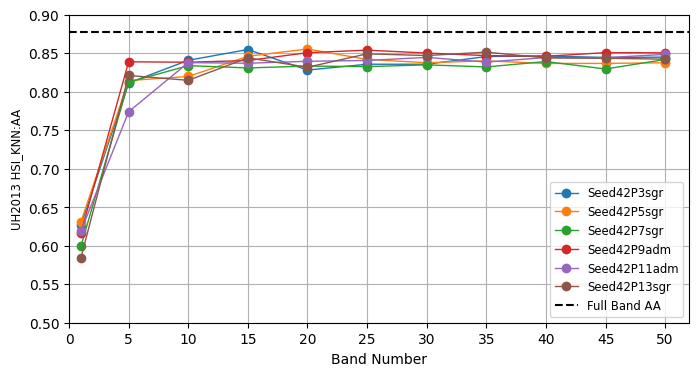

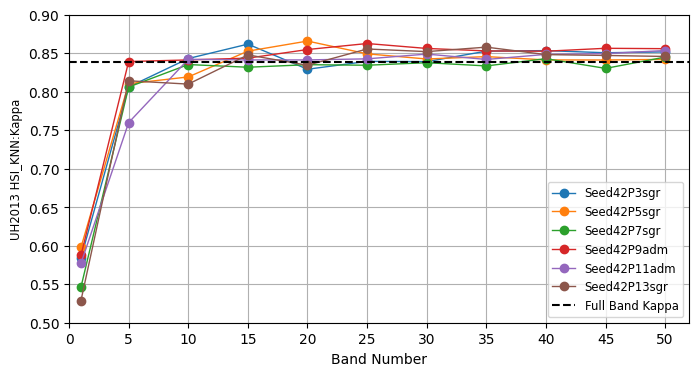

In [ ]:
# Test Result on Jan. 15.2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study) for HSI

data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'Seed42P3sgr': [0.8635, 0.8625, 0.8650, 0.8645, 0.8519, 0.8519, 0.8428, 0.8728, 0.8556, 0.8216, 0.6157,
                  0.8449, 0.8445, 0.8464, 0.8457, 0.8357, 0.8357, 0.8281, 0.8548, 0.8408, 0.8114, 0.6271,
                  0.8517, 0.8506, 0.8534, 0.8527, 0.8391, 0.8394, 0.8292, 0.8618, 0.8431, 0.8062, 0.5841],
    'Seed42P5sgr': [0.8546, 0.8538, 0.8540, 0.8579, 0.8550, 0.8612, 0.8764, 0.8644, 0.8336, 0.8254, 0.6286,
                  0.8376, 0.8368, 0.8367, 0.8401, 0.8377, 0.8419, 0.8555, 0.8460, 0.8198, 0.8145, 0.6311,
                  0.8420, 0.8412, 0.8413, 0.8456, 0.8425, 0.8492, 0.8658, 0.8527, 0.8192, 0.8104, 0.5977],
    'Seed42P7sgr': [0.8573, 0.8438, 0.8555, 0.8468, 0.8506, 0.8476, 0.8482, 0.8451, 0.8484, 0.8215, 0.5818,
                   0.8419, 0.8295, 0.8392, 0.8322, 0.8349, 0.8326, 0.8333, 0.8309, 0.8339, 0.8124, 0.5995,
                   0.8450, 0.8303, 0.8429, 0.8335, 0.8377, 0.8344, 0.8351, 0.8318, 0.8353, 0.8061, 0.5462],
    'Seed42P9adm': [0.8673, 0.8678, 0.8643, 0.8647, 0.8677, 0.8736, 0.8664, 0.8560, 0.8539, 0.8520, 0.6191,
                  0.8505, 0.8508, 0.8460, 0.8469, 0.8502, 0.8540, 0.8507, 0.8405, 0.8383, 0.8389, 0.6168,
                  0.8559, 0.8564, 0.8526, 0.8530, 0.8562, 0.8626, 0.8548, 0.8436, 0.8413, 0.8392, 0.5874],
    'Seed42P11adm': [0.8651, 0.8614, 0.8605, 0.8545, 0.8609, 0.8552, 0.8539, 0.8539, 0.8546, 0.7789, 0.6097,
                  0.8485, 0.8442, 0.8444, 0.8385, 0.8446, 0.8406, 0.8395, 0.8370, 0.8378, 0.7740, 0.6191,
                  0.8535, 0.8495, 0.8485, 0.8419, 0.8489, 0.8427, 0.8413, 0.8413, 0.8421, 0.7599, 0.5771],
    'Seed42P13sgr': [0.8581, 0.8592, 0.8602, 0.8692, 0.8638, 0.8669, 0.8475, 0.8599, 0.8249, 0.8290, 0.5658,
                   0.8423, 0.8434, 0.8439, 0.8514, 0.8470, 0.8492, 0.8318, 0.8440, 0.8148, 0.8211, 0.5844,
                  0.8458, 0.8471, 0.8482, 0.8579, 0.8521, 0.8555, 0.8344, 0.8478, 0.8099, 0.8142, 0.5287]
}

# Creating a DataFrame
df_uh2013_hsi_knn= pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['Seed42P3sgr','Seed42P5sgr', 'Seed42P7sgr', 'Seed42P9adm',  'Seed42P11adm', 'Seed42P13sgr']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsi_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsi_knn[df_uh2013_hsi_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_KNN:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.5000, 0.9000)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

### 9.2 Plot based on KNN HSI Only ( OurMehtod + Other methods)

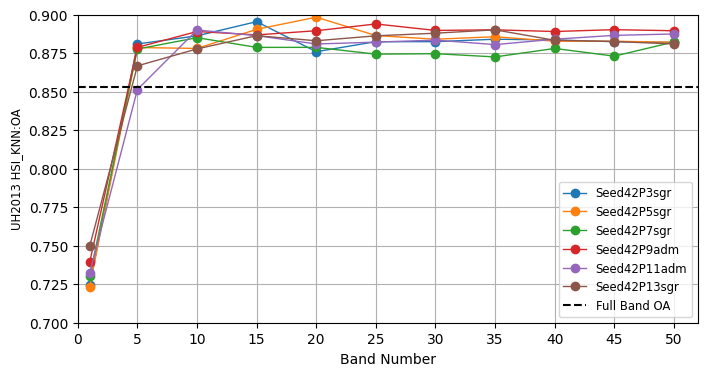

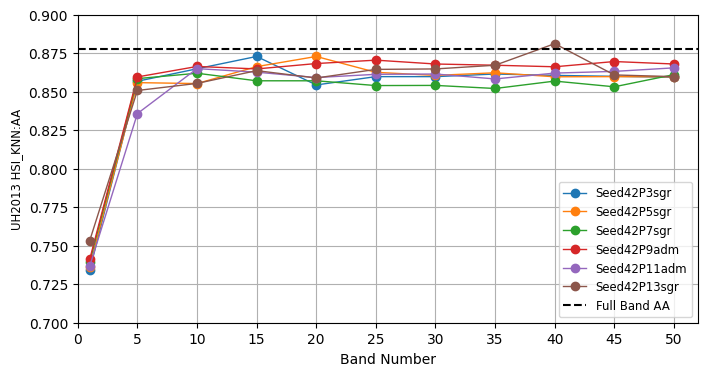

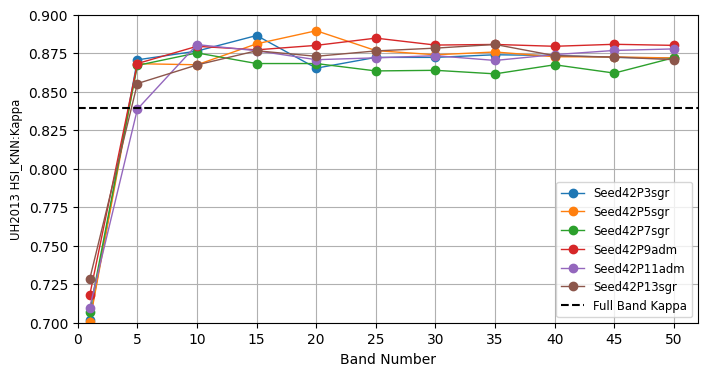

In [ ]:
# Test Result on Jan. 15.2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study) for HSI+LIDAR
data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'Seed42P3sgr': [0.8820, 0.8825, 0.8836, 0.8841, 0.8825, 0.8825, 0.8760, 0.8955, 0.8863, 0.8810, 0.7245,
                    0.8594, 0.8600, 0.8606, 0.8615, 0.8598, 0.8598, 0.8544, 0.8729, 0.8649, 0.8568, 0.7340,
                    0.8718, 0.8723, 0.8735, 0.8740, 0.8723, 0.8723, 0.8653, 0.8865, 0.8764, 0.8707, 0.7016],
    'Seed42P5sgr': [0.8821, 0.8828, 0.8828, 0.8857, 0.8841, 0.8865, 0.8984, 0.8905, 0.8781, 0.8787, 0.7234,
                    0.8597, 0.8598, 0.8597, 0.8623, 0.8606, 0.8626, 0.8729, 0.8663, 0.8553, 0.8559, 0.7363,
                    0.8719, 0.8726, 0.8727, 0.8758, 0.8740, 0.8767, 0.8896, 0.8811, 0.8675, 0.8682, 0.7004],
    'Seed42P7sgr': [0.8823, 0.8731, 0.8781, 0.8726, 0.8747, 0.8744, 0.8788, 0.8788, 0.8851, 0.8777, 0.7301,
                    0.8611, 0.8532, 0.8569, 0.8521, 0.8541, 0.8540, 0.8571, 0.8571, 0.8620, 0.8585, 0.7395,
                    0.8721, 0.8621, 0.8675, 0.8616, 0.8639, 0.8635, 0.8683, 0.8683, 0.8752, 0.8671, 0.7072],
    'Seed42P9adm': [0.8896, 0.8903, 0.8891, 0.8902, 0.8898, 0.8940, 0.8896, 0.8869, 0.8891, 0.8788, 0.7393,
                    0.868, 0.8696, 0.8662, 0.8672, 0.8680, 0.8705, 0.8683, 0.8648, 0.8664, 0.8596, 0.7411,
                    0.8801, 0.8808, 0.8795, 0.8807, 0.8803, 0.8848, 0.8801, 0.8772, 0.8795, 0.8683, 0.7178],
    'Seed42P11adm': [0.8875, 0.8866, 0.8841, 0.8806, 0.8835, 0.8822, 0.8810, 0.8864, 0.8901, 0.8514, 0.7322,
                     0.8655, 0.8632, 0.8621, 0.8583, 0.8615, 0.8613, 0.8592, 0.8627, 0.8650, 0.8358, 0.7367,
                     0.8778, 0.8768, 0.8741, 0.8703, 0.8734, 0.8720, 0.8708, 0.8766, 0.8806, 0.8387, 0.7098],
     'Seed42P13sgr': [0.8810, 0.8826, 0.8834, 0.8902, 0.8880, 0.8863, 0.8831, 0.8864, 0.8778, 0.8668, 0.7497,
                      0.8598, 0.8609, 0.8812, 0.8672, 0.8648, 0.8645, 0.8589, 0.8637, 0.8554, 0.8508, 0.7533,
                      0.8708, 0.8725, 0.8734, 0.8807, 0.8783, 0.8765, 0.8730, 0.8766, 0.8674, 0.8553, 0.7283]
}
# Creating a DataFrame
df_uh2013_hsi_lidar_knn= pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['Seed42P3sgr','Seed42P5sgr', 'Seed42P7sgr', 'Seed42P9adm',  'Seed42P11adm', 'Seed42P13sgr']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsi_lidar_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsi_lidar_knn[df_uh2013_hsi_lidar_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_KNN:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.7000, 0.9000)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

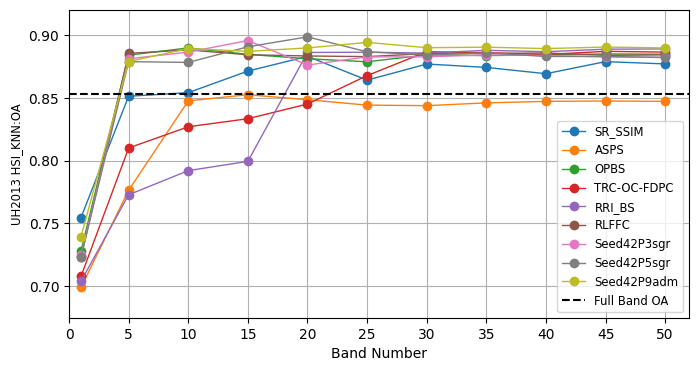

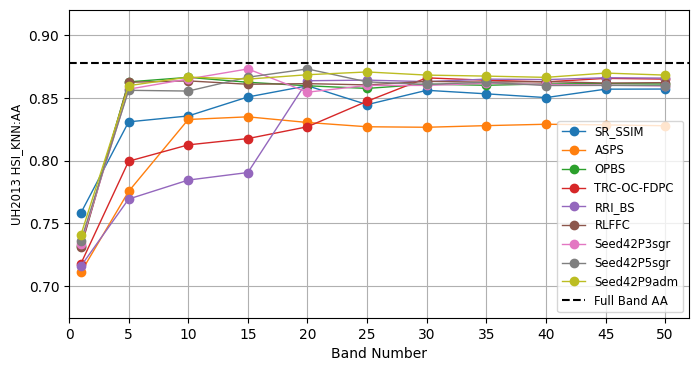

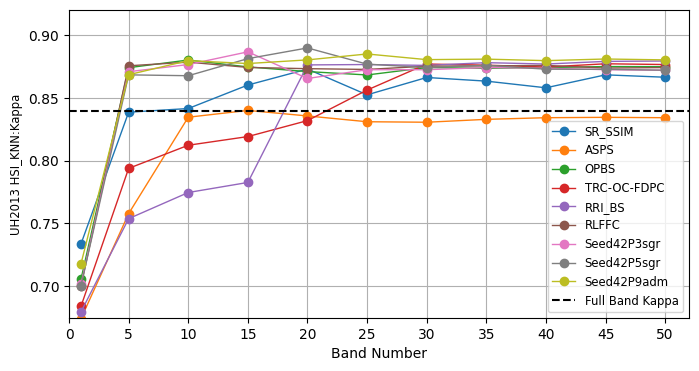

In [ ]:
# Test Result on Jan. 15.2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study) for HSI+LIDAR

data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'SR_SSIM': [0.9743, 0.9741, 0.9735, 0.9738, 0.9742, 0.9724, 0.9726, 0.9724, 0.9703, 0.9724, 0.7990,
                0.9591, 0.9589, 0.9580, 0.9585, 0.9586, 0.9566, 0.9585, 0.9563, 0.9550, 0.9575, 0.7415,
                0.9656, 0.9653, 0.9645, 0.9649, 0.9654, 0.9630, 0.9633, 0.9631, 0.9602, 0.9630, 0.7232],
    'ASPS': [ 0.9748, 0.9746, 0.9743, 0.9744, 0.9741, 0.9733, 0.9736, 0.9748, 0.9757, 0.9761, 0.8201,
              0.9588, 0.9585, 0.9587, 0.9593, 0.9579, 0.9557, 0.9572, 0.9580, 0.9605, 0.9617, 0.7563,
              0.9662, 0.9659, 0.9655, 0.9657, 0.9652, 0.9642, 0.9645, 0.9662, 0.9674, 0.9679, 0.7500],
    'TRC-OC-FDPC': [ 0.9737, 0.9737, 0.9734, 0.9745, 0.9747, 0.9754, 0.9755, 0.9755, 0.9754, 0.9747, 0.8284,
                    0.9587, 0.9592, 0.9587, 0.9606, 0.9596, 0.9595, 0.9603, 0.9607, 0.9607, 0.9591, 0.6791,
                   0.9648, 0.9647, 0.9644, 0.9658, 0.9661, 0.9671, 0.9671, 0.9671, 0.9670, 0.9661, 0.7688],
    'RRI_BS': [0.9748, 0.9753, 0.9743, 0.9719, 0.9683, 0.9693, 0.9695, 0.9523, 0.9467, 0.8398, 0.8441,
               0.9588, 0.9587, 0.9561, 0.9526, 0.9468, 0.9484, 0.9494, 0.9215, 0.9155, 0.7812, 0.8261,
               0.9662, 0.9669, 0.9655, 0.9623, 0.9574, 0.9588, 0.9591, 0.9360, 0.9283, 0.7782, 0.7918],
     'RLFFC': [0.9735, 0.9734, 0.9734, 0.9738, 0.9738, 0.9738, 0.9735, 0.9740, 0.9729, 0.9728, 0.8610,
               0.9583, 0.9583, 0.9585, 0.9591, 0.9590, 0.9587, 0.9584, 0.9595, 0.9592, 0.9574, 0.8551,
               0.9644, 0.9644, 0.9643, 0.9649, 0.9649, 0.9649, 0.9645, 0.9651, 0.9637, 0.9635, 0.8172]
}

    'Seed42P3sgr': [0.8820, 0.8825, 0.8836, 0.8841, 0.8825, 0.8825, 0.8760, 0.8955, 0.8863, 0.8810, 0.7245,
                    0.8594, 0.8600, 0.8606, 0.8615, 0.8598, 0.8598, 0.8544, 0.8729, 0.8649, 0.8568, 0.7340,
                    0.8718, 0.8723, 0.8735, 0.8740, 0.8723, 0.8723, 0.8653, 0.8865, 0.8764, 0.8707, 0.7016],
    'Seed42P5sgr': [0.8821, 0.8828, 0.8828, 0.8857, 0.8841, 0.8865, 0.8984, 0.8905, 0.8781, 0.8787, 0.7234,
                    0.8597, 0.8598, 0.8597, 0.8623, 0.8606, 0.8626, 0.8729, 0.8663, 0.8553, 0.8559, 0.7363,
                    0.8719, 0.8726, 0.8727, 0.8758, 0.8740, 0.8767, 0.8896, 0.8811, 0.8675, 0.8682, 0.7004],
    'Seed42P9adm': [0.8896, 0.8903, 0.8891, 0.8902, 0.8898, 0.8940, 0.8896, 0.8869, 0.8891, 0.8788, 0.7393,
                    0.868, 0.8696, 0.8662, 0.8672, 0.8680, 0.8705, 0.8683, 0.8648, 0.8664, 0.8596, 0.7411,
                    0.8801, 0.8808, 0.8795, 0.8807, 0.8803, 0.8848, 0.8801, 0.8772, 0.8795, 0.8683, 0.7178]
}


# Creating a DataFrame
df_uh2013_hsi_lidar_knn= pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS', 'OPBS', 'TRC-OC-FDPC', 'RRI_BS','RLFFC', 'Seed42P3sgr','Seed42P5sgr','Seed42P9adm']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsi_lidar_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsi_lidar_knn[df_uh2013_hsi_lidar_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_KNN:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.6750, 0.9200)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

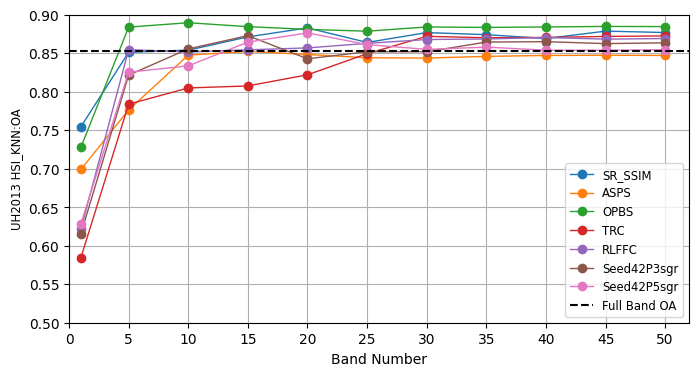

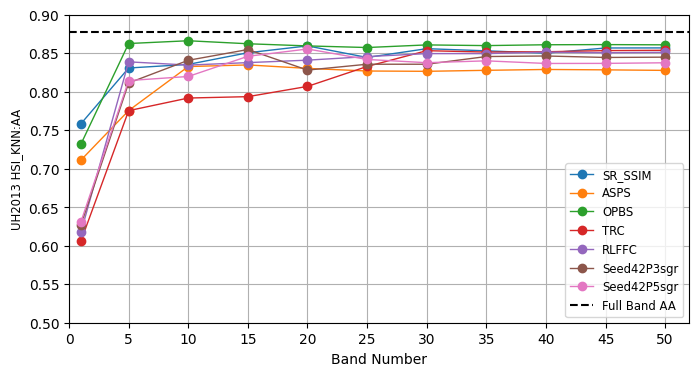

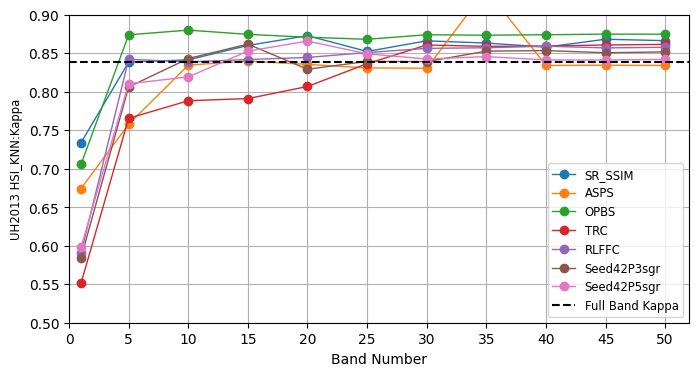

In [ ]:
# Test Result on Jan. 15.2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# UH2013 KNN test data(Ablation study) for HSI+Lidar

data = {
    'Band Number': [50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 1] * 3,
    'Metrics': ['OA'] * 11 + ['AA'] * 11 + ['Kappa'] * 11,
    'SR_SSIM': [0.8769, 0.8787, 0.8691, 0.8741, 0.8768, 0.8640, 0.8829, 0.8712, 0.8540, 0.8512, 0.7546,
                0.8569, 0.8568, 0.8501, 0.8531, 0.8559, 0.8445, 0.8595, 0.8506, 0.8355, 0.8308, 0.7584,
                0.8663, 0.8682, 0.8579, 0.8632, 0.8661, 0.8523, 0.8728, 0.8601, 0.8414, 0.8385, 0.7336],
    'ASPS': [0.8471, 0.8474, 0.8471, 0.8459, 0.8437, 0.8441, 0.8484, 0.8524, 0.8475, 0.7764, 0.6991,
             0.8277, 0.8284, 0.8289, 0.8278, 0.8265, 0.8269, 0.8303, 0.8348, 0.8327, 0.7755, 0.7112,
             0.8341, 0.8344, 0.8341, 0.9328, 0.8305, 0.8309, 0.8355, 0.8399, 0.8345, 0.7578, 0.6742],
    'OPBS': [0.8846, 0.8848, 0.8841, 0.8835, 0.8841, 0.8786, 0.8810, 0.8845, 0.8896, 0.8839, 0.7280,
             0.8609, 0.8612, 0.8610, 0.8599, 0.8608, 0.8574, 0.8595, 0.8623, 0.8662, 0.8626, 0.7320,
             0.8747, 0.8748, 0.8740, 0.8734, 0.8740, 0.8681, 0.8708, 0.8745, 0.8800, 0.8739, 0.7055],

    'TRC': [0.8725, 0.8718, 0.8705, 0.8701, 0.8719, 0.8494, 0.8220, 0.8075, 0.8049, 0.7838, 0.5847,
            0.8538, 0.8534, 0.8519, 0.8515, 0.8533, 0.8328, 0.8069, 0.7936, 0.7918, 0.7754, 0.6061,
            0.8615, 0.8607, 0.8593, 0.8589, 0.8607, 0.8364, 0.8068, 0.7911, 0.7883, 0.7655, 0.5511],
    'RRI': [0.8740, 0.8732, 0.8724, 0.8705, 0.8658, 0.8673, 0.8664, 0.7328, 0.7200, 0.7094, 0.5361,
            0.8542, 0.8539, 0.8536, 0.8520, 0.8476, 0.8495, 0.8481, 0.7356, 0.7224, 0.7127, 0.5645,
            0.9631, 0.8622, 0.8614, 0.8593, 0.8542, 0.8559, 0.8549, 0.7105, 0.6967, 0.6851, 0.4995],
    'RLFFC': [0.8691, 0.8683, 0.8704, 0.8685, 0.8678, 0.8628, 0.8569, 0.8544, 0.8517, 0.8546, 0.6218,
              0.8512, 0.8506, 0.8515, 0.8495, 0.8495, 0.8456, 0.8410, 0.8378, 0.8346, 0.8388, 0.6176,
              0.8577, 0.8569, 0.8591, 0.8571, 0.8563, 0.8509, 0.8445, 0.8418, 0.8389, 0.8421, 0.5903],
    'Seed42P3sgr': [0.8635, 0.8625, 0.8650, 0.8645, 0.8519, 0.8519, 0.8428, 0.8728, 0.8556, 0.8216, 0.6157,
                  0.8449, 0.8445, 0.8464, 0.8457, 0.8357, 0.8357, 0.8281, 0.8548, 0.8408, 0.8114, 0.6271,
                  0.8517, 0.8506, 0.8534, 0.8527, 0.8391, 0.8394, 0.8292, 0.8618, 0.8431, 0.8062, 0.5841],
    'Seed42P5sgr': [0.8546, 0.8538, 0.8540, 0.8579, 0.8550, 0.8612, 0.8764, 0.8644, 0.8336, 0.8254, 0.6286,
                  0.8376, 0.8368, 0.8367, 0.8401, 0.8377, 0.8419, 0.8555, 0.8460, 0.8198, 0.8145, 0.6311,
                  0.8420, 0.8412, 0.8413, 0.8456, 0.8425, 0.8492, 0.8658, 0.8527, 0.8192, 0.8104, 0.5977]
}

# Creating a DataFrame
df_uh2013_hsi_knn= pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS', 'OPBS', 'TRC', 'RLFFC', 'Seed42P3sgr','Seed42P5sgr']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_uh2013_hsi_lidar_knn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_uh2013_hsi_knn[df_uh2013_hsi_knn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 HSI_KNN:{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.5000, 0.9000)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()

# 7.0 CNN Test Based On Selected Best Bands

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from scipy.io import loadmat
import mat73

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time
import time

seed(11)

# Raw Data Extraction

In [ ]:
# 2.1 Define the class information
class_info = [(1, "Healthy grass", 1251),
    (2, "Stressed grass", 1254),
    (3, "Synthetic grass", 697),
    (4, "Trees", 1244),
    (5, "Soil", 1242),
    (6, "Water", 325),
    (7, "Residential", 1268),
    (8, "Commercial", 1244),
    (9, "Road", 1252),
    (10, "Highway", 1227),
    (11, "Railway", 1235),
    (12, "Parking lot 1", 1233),
    (13, "Parking lot 2", 469),
    (14, "Tennis court", 428),
    (15, "Running track", 660)]

# Create a dictionary to store class number, class name, and class samples
class_dict = {class_number: {"class_name": class_name, "samples": samples} for class_number, class_name, samples in class_info}

print(class_dict)

{1: {'class_name': 'Healthy grass', 'samples': 1251}, 2: {'class_name': 'Stressed grass', 'samples': 1254}, 3: {'class_name': 'Synthetic grass', 'samples': 697}, 4: {'class_name': 'Trees', 'samples': 1244}, 5: {'class_name': 'Soil', 'samples': 1242}, 6: {'class_name': 'Water', 'samples': 325}, 7: {'class_name': 'Residential', 'samples': 1268}, 8: {'class_name': 'Commercial', 'samples': 1244}, 9: {'class_name': 'Road', 'samples': 1252}, 10: {'class_name': 'Highway', 'samples': 1227}, 11: {'class_name': 'Railway', 'samples': 1235}, 12: {'class_name': 'Parking lot 1', 'samples': 1233}, 13: {'class_name': 'Parking lot 2', 'samples': 469}, 14: {'class_name': 'Tennis court', 'samples': 428}, 15: {'class_name': 'Running track', 'samples': 660}}


### 2.1  Samples Extraction

In [ ]:
# 2.2 Samples Extraction

# # Create a mask with all class labels
# mask = np.copy(gt_2013_data)

# # Set the background class to 0
# mask[mask == 0] = 0

# Define patch size and stride
patch_size = 9
stride = 1

# Create an empty list to store patches and labels
hsi_samples = []
lidar_samples = []
labels = []

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, class_dict):
    return all(class_count[class_num] == class_dict[class_num]["samples"] for class_num in class_dict.keys())

while not all_classes_completed(class_count, class_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        #coords = np.argwhere((gt_2013_data == label) & (mask > 0))
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < class_dict[label]["samples"]:
                    # Append the patch and its label to the list
                    hsi_samples.append(hsi_patch)
                    lidar_samples.append(lidar_patch)
                    labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, class_dict):
                        break

# Convert the list of patches and labels into arrays
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

hsi_samples shape: (15029, 9, 9, 144)
lidar_samples shape: (15029, 9, 9, 1)
labels shape: (15029,)


In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
#training_samples = [198, 190, 192, 188, 186, 182, 196, 191, 193, 191, 181, 192, 184, 181, 187]
training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

training_hsi_samples = np.array(training_hsi_samples)
training_lidar_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', training_hsi_samples.shape)
print('training_lidar_samples shape:', training_lidar_samples.shape)
print('training_labels shape:', training_labels.shape)

training_hsi_samples shape: (150, 9, 9, 144)
training_lidar_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)


In [ ]:
# Assuming `hsi_samples`, `lidar_samples`, and `labels` have been previously defined

# Convert the list of patches and labels into arrays if they aren't already
hsi_samples = np.array(hsi_samples)
lidar_samples = np.array(lidar_samples)
labels = np.array(labels)

# Create lists to store training and test samples and labels
hsi_training_samples, lidar_training_samples, training_labels = [], [], []
hsi_test_samples, lidar_test_samples, test_labels = [], [], []

# Split samples into training and test sets based on the desired number of training samples
for label, train_samples in training_samples_dict.items():
    # Get indices of the current class
    class_indices = np.where(labels == label)[0]

    # Randomly shuffle the indices
    np.random.shuffle(class_indices)

    # Split the indices into training and test set indices
    train_indices = class_indices[:train_samples]
    test_indices = class_indices[train_samples:]

    # Add training samples and labels for the current class
    hsi_training_samples.extend(hsi_samples[train_indices])
    lidar_training_samples.extend(lidar_samples[train_indices])
    training_labels.extend(labels[train_indices])

    # Add test samples and labels for the current class
    hsi_test_samples.extend(hsi_samples[test_indices])
    lidar_test_samples.extend(lidar_samples[test_indices])
    test_labels.extend(labels[test_indices])

# Convert lists back to numpy arrays
hsi_training_samples = np.array(hsi_training_samples)
lidar_training_samples = np.array(lidar_training_samples)
training_labels = np.array(training_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

hsi_training_samples shape: (150, 9, 9, 144)
lidar_training_samples shape: (150, 9, 9, 1)
training_labels shape: (150,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


In [ ]:
# USing Augmentation training sample to test
# Define the band indices you're interested in
#band_indices = bands_aug[:1]
#band_indices = bands_aug1[:50]
#band_indices = bands_p9[:50]
#band_indices=bands_lrr[:1]
#band_indices=bands_asps[:35]
#band_indices=bands_opbs[:1]
#band_indices=bands_trc[:1]
#band_indices=bands_bsnet[:1]
#band_indices=bands_rlffc[:50]
#band_indices = np.arange(144)
band_indices=top_50_seed42

# Extract the corresponding bands from the HSI samples
selected_hsi_samples = hsi_samples[:,:,:, band_indices]
selected_lidar_samples = lidar_samples
label=labels
selected_training_lables=training_labels
selected_test_labels=test_labels
print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('label shape:', label.shape)
print('selected_training_lables shape:', selected_training_lables.shape)
print('selected_test_labels shape:', selected_test_labels.shape)

selected_hsi_train_samples = hsi_training_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  lidar_training_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data
# # Concatenate the data
# Concatenate the data along axis 3
selected_hsi_lidar_samples = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

# # Concatenate the data
selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

selected_hsi_samples shape: (16079, 9, 9, 50)
selected_lidar_samples shape: (16079, 9, 9, 1)
label shape: (16079,)
selected_training_lables shape: (1200,)
selected_test_labels shape: (14879,)
selected_hsi_train_samples  shape: (1200, 9, 9, 50)
selected_hsi_test_sample shape: (14879, 9, 9, 50)
selected_lidar_train shape: (1200, 9, 9, 1)
selected_lidar_test shape: (14879, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_lidar_samples shape: (16079, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 51)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 51)
selected_hsi_samples shape: (16079, 9, 9, 50)
selected_lidar_samples shape: (16079, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 51)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 51)
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)
y_train shape: (1200,)
y_test 

# 7.05 Different Sample Extraction

In [ ]:
# 2.5 Training samples extraction
# The desired number of samples for each class
training_samples = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
training_samples_dict = {i+1: size for i, size in enumerate(training_samples)}

# Initialize a dictionary to store class count
class_count = {i: 0 for i in class_dict.keys()}

# Function to check if all classes have the required number of samples
def all_classes_completed(class_count, training_samples_dict):
    return all(class_count[class_num] == training_samples_dict[class_num] for class_num in class_dict.keys())

# Create an empty list to store patches and labels
training_hsi_samples = []
training_lidar_samples = []
training_labels = []

while not all_classes_completed(class_count, training_samples_dict):
    # Loop through the ground truth data
    for label in class_dict.keys():
        # Get the coordinates of the ground truth pixels
        coords = np.argwhere(gt_2013_data == label)

        # Shuffle the coordinates to randomize the patch extraction
        np.random.shuffle(coords)

        for coord in coords:
            i, j = coord
            # Calculate the patch indices
            i_start, i_end = i - patch_size // 2, i + patch_size // 2 + 1
            j_start, j_end = j - patch_size // 2, j + patch_size // 2 + 1

            # Check if the indices are within the bounds of the HSI data
            if i_start >= 0 and i_end <= hsi_2013_data.shape[0] and j_start >= 0 and j_end <= hsi_2013_data.shape[1]:
                # Extract the patch
                hsi_patch = hsi_2013_data[i_start:i_end, j_start:j_end, :]

                # Extract the LiDAR patch
                lidar_patch = lidar_2013_data[i_start:i_end, j_start:j_end, :]

                # If the class count is less than the required samples
                if class_count[label] < training_samples_dict[label]:
                    # Append the patch and its label to the list
                    training_hsi_samples.append(hsi_patch)
                    training_lidar_samples.append(lidar_patch)
                    training_labels.append(label)
                    class_count[label] += 1

                    # If all classes have the required number of samples, exit the loop
                    if all_classes_completed(class_count, training_samples_dict):
                        break

hsi_training_samples = np.array(training_hsi_samples)
lidar_training_samples = np.array(training_lidar_samples)
training_labels = np.array(training_labels)
print('training_hsi_samples shape:', hsi_training_samples.shape)
print('training_lidar_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

NameError: name 'class_dict' is not defined

In [ ]:
import numpy as np
from scipy.ndimage import rotate

def augment_training_data(hsi_training_data, lidar_training_data, training_labels, rotations=[15, 45, 90, 120, 135], flip_up_down=True, flip_left_right=True):
    augmented_hsi = []
    augmented_lidar = []
    augmented_labels = []

    for hsi, lidar, label in zip(hsi_training_data, lidar_training_data, training_labels):
        # Original data
        augmented_hsi.append(hsi)
        augmented_lidar.append(lidar)
        augmented_labels.append(label)

        # Rotations
        for angle in rotations:
            hsi_rotated = rotate(hsi, angle, axes=(0, 1), reshape=False, mode='nearest')
            lidar_rotated = rotate(lidar, angle, axes=(0, 1), reshape=False, mode='nearest')

            augmented_hsi.append(hsi_rotated)
            augmented_lidar.append(lidar_rotated)
            augmented_labels.append(label)

        # Flip up-down
        if flip_up_down:
            hsi_flipped_ud = np.flipud(hsi)
            lidar_flipped_ud = np.flipud(lidar)

            augmented_hsi.append(hsi_flipped_ud)
            augmented_lidar.append(lidar_flipped_ud)
            augmented_labels.append(label)

        # Flip left-right
        if flip_left_right:
            hsi_flipped_lr = np.fliplr(hsi)
            lidar_flipped_lr = np.fliplr(lidar)

            augmented_hsi.append(hsi_flipped_lr)
            augmented_lidar.append(lidar_flipped_lr)
            augmented_labels.append(label)

    return np.array(augmented_hsi), np.array(augmented_lidar), np.array(augmented_labels)

# Augmenting the training samples
augmented_hsi_training_samples, augmented_lidar_training_samples, augmented_training_labels = augment_training_data(hsi_training_samples, lidar_training_samples, training_labels)

# Print shapes to verify the augmented training data
print('Augmented HSI training samples shape:', augmented_hsi_training_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_training_samples.shape)
print('Augmented training labels shape:', augmented_training_labels.shape)

Augmented HSI training samples shape: (1200, 9, 9, 144)
Augmented LiDAR training samples shape: (1200, 9, 9, 1)
Augmented training labels shape: (1200,)


In [ ]:
augmented_hsi_train_samples=augmented_hsi_training_samples
augmented_lidar_train_samples=augmented_lidar_training_samples
augmented_train_labels=augmented_training_labels

hsi_test_samples=hsi_test_samples
lidar_test_samples=lidar_test_samples
test_labels=test_labels

# Print out
print('Augmented HSI training samples shape:', augmented_hsi_train_samples.shape)
print('Augmented LiDAR training samples shape:', augmented_lidar_train_samples.shape)
print('Augmented training labels shape:', augmented_train_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

# Concatenating the HSI samples
augmented_hsi_samples = np.concatenate((augmented_hsi_train_samples, hsi_test_samples), axis=0)
# Concatenating the LiDAR samples
augmented_lidar_samples = np.concatenate((augmented_lidar_train_samples, lidar_test_samples), axis=0)
# Concatenating the labels
augmented_labels = np.concatenate((augmented_training_labels, test_labels), axis=0)

# Print out the new shapes
print('Augmented HSI samples shape:', augmented_hsi_samples.shape)
print('Augmented LiDAR samples shape:', augmented_lidar_samples.shape)
print('Augmented labels shape:', augmented_labels.shape)

NameError: name 'augmented_hsi_training_samples' is not defined

In [ ]:
# Convert the list of patches and labels into arrays
hsi_samples = np.array(augmented_hsi_samples)
lidar_samples = np.array(augmented_lidar_samples)
labels = np.array(augmented_labels)
print('hsi_samples shape:', hsi_samples.shape)
print('lidar_samples shape:', lidar_samples.shape)
print('labels shape:', labels.shape)

# Convert lists back to numpy arrays
hsi_training_samples = np.array(augmented_hsi_train_samples)
lidar_training_samples = np.array(augmented_lidar_train_samples)
training_labels = np.array(augmented_train_labels)

hsi_test_samples = np.array(hsi_test_samples)
lidar_test_samples = np.array(lidar_test_samples)
test_labels = np.array(test_labels)

# Print shapes to verify
print('hsi_training_samples shape:', hsi_training_samples.shape)
print('lidar_training_samples shape:', lidar_training_samples.shape)
print('training_labels shape:', training_labels.shape)

print('hsi_test_samples shape:', hsi_test_samples.shape)
print('lidar_test_samples shape:', lidar_test_samples.shape)
print('test_labels shape:', test_labels.shape)

hsi_samples shape: (16079, 9, 9, 144)
lidar_samples shape: (16079, 9, 9, 1)
labels shape: (16079,)
hsi_training_samples shape: (1200, 9, 9, 144)
lidar_training_samples shape: (1200, 9, 9, 1)
training_labels shape: (1200,)
hsi_test_samples shape: (14879, 9, 9, 144)
lidar_test_samples shape: (14879, 9, 9, 1)
test_labels shape: (14879,)


## 7.1 Convert X_train, X_test, y_train, y_tet to suit 1DCNN

In [ ]:
# USing Augmentation training sample to test
# Define the band indices you're interested in
#band_indices = bands_aug[:1]
#band_indices = bands_aug1[:50]
#band_indices = bands_p9[:50]
#band_indices=bands_lrr[:1]
#band_indices=bands_asps[:35]
#band_indices=bands_opbs[:1]
#band_indices=bands_trc[:1]
#band_indices=bands_bsnet[:1]
#band_indices=bands_rlffc[:50]
#band_indices = np.arange(144)
band_indices=top_50_seed42

# Extract the corresponding bands from the HSI samples
selected_hsi_samples = augmented_hsi_samples[:,:,:, band_indices]
selected_lidar_samples = augmented_lidar_samples
label=augmented_labels
selected_training_lables=augmented_train_labels
selected_test_labels=test_labels
print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('label shape:', label.shape)
print('selected_training_lables shape:', selected_training_lables.shape)
print('selected_test_labels shape:', selected_test_labels.shape)

selected_hsi_train_samples = augmented_hsi_train_samples[:,:,:, band_indices]
selected_hsi_test_samples = hsi_test_samples[:,:,:, band_indices]
selected_lidar_train =  augmented_lidar_train_samples
selected_lidar_test = lidar_test_samples
print('selected_hsi_train_samples  shape:', selected_hsi_train_samples .shape)
print('selected_hsi_test_sample shape:', selected_hsi_test_samples.shape)
print('selected_lidar_train shape:', selected_lidar_train.shape)
print('selected_lidar_test shape:', selected_lidar_test.shape)

# #Adding LiDAR Data to Reduced bands HSI Data
# # Concatenate the data
# Concatenate the data along axis 3
selected_hsi_lidar_samples = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

# # Concatenate the data
selected_hsi_lidar_samples  = np.concatenate([selected_hsi_samples, selected_lidar_samples], axis=3)
selected_hsi_lidar_train_samples  = np.concatenate([selected_hsi_train_samples, selected_lidar_train], axis=3)
selected_hsi_lidar_test_samples  = np.concatenate([selected_hsi_test_samples, selected_lidar_test], axis=3)

print('selected_hsi_samples shape:', selected_hsi_samples.shape)
print('selected_lidar_samples shape:', selected_lidar_samples.shape)
print('selected_hsi_lidar_samples shape:', selected_hsi_lidar_samples.shape)
print('selected_hsi_lidar_train_samples shape:', selected_hsi_lidar_train_samples.shape)
print('selected_hsi_lidar_test_samples shape:', selected_hsi_lidar_test_samples.shape)

X_train=selected_hsi_lidar_train_samples
X_test=selected_hsi_lidar_test_samples
y_train=augmented_training_labels
y_test=test_labels

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

selected_hsi_samples shape: (16079, 9, 9, 50)
selected_lidar_samples shape: (16079, 9, 9, 1)
label shape: (16079,)
selected_training_lables shape: (1200,)
selected_test_labels shape: (14879,)
selected_hsi_train_samples  shape: (1200, 9, 9, 50)
selected_hsi_test_sample shape: (14879, 9, 9, 50)
selected_lidar_train shape: (1200, 9, 9, 1)
selected_lidar_test shape: (14879, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_lidar_samples shape: (16079, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 51)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 51)
selected_hsi_samples shape: (16079, 9, 9, 50)
selected_lidar_samples shape: (16079, 9, 9, 1)
selected_hsi_lidar_samples shape: (16079, 9, 9, 51)
selected_hsi_lidar_train_samples shape: (1200, 9, 9, 51)
selected_hsi_lidar_test_samples shape: (14879, 9, 9, 51)
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)
y_train shape: (1200,)
y_test 

# 7.15 Convert to Suit CNN

In [ ]:
from sklearn.preprocessing import StandardScaler

# Store the original shapes
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_test_shape = X_test.shape    # (samples, height, width, channels)

# Reshape for standardization (2D)
X_train_reshaped = X_train.reshape(-1, original_train_shape[1]*original_train_shape[2]*original_train_shape[3])
X_test_reshaped = X_test.reshape(-1, original_test_shape[1]*original_test_shape[2]*original_test_shape[3])

# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_reshaped)
X_test_standardized = scaler.transform(X_test_reshaped)

# Reshape back to original 4D shape
X_train = X_train_standardized.reshape(original_train_shape)
X_test = X_test_standardized.reshape(original_test_shape)

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


After standardization:
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)


In [ ]:
X_train_channels = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2], X_train.shape[3])  # Reshaping to (9900, 81, 3)
X_test_channels = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2], X_test.shape[3])    # Reshaping to (53687, 81, 3)
print('X_train_channels:',X_train_channels.shape)
print('X_test_channels:',X_test_channels.shape)

# For 1D CNN, we need to add an extra dimension
X_train = X_train_channels
X_test = X_test_channels
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
ip_shape = X_train[1].shape
n_outputs = 15

print('ip_shape shape:', ip_shape)
print('n_outputs:', n_outputs)

y_train=training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

y_train=training_labels
y_test=test_labels

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique classes in y_train:", unique_classes_y_train)
print("Unique classes in y_test:", unique_classes_y_test)

y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

y_train_encoded = to_categorical(y_train_adjusted)
y_test_encoded = to_categorical(y_test_adjusted)

print('y_train_encoded shape:',y_train_encoded .shape)
print('y_test_encoded sahpe:',y_test_encoded.shape)

X_train_channels: (1200, 81, 51)
X_test_channels: (14879, 81, 51)
X_train shape: (1200, 81, 51)
X_test shape: (14879, 81, 51)
ip_shape shape: (81, 51)
n_outputs: 15
y_train shape: (1200,)
y_test shape: (14879,)
Unique classes in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Unique classes in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
y_train_encoded shape: (1200, 15)
y_test_encoded sahpe: (14879, 15)
y_train shape: (1200,)
y_test shape: (14879,)
Unique classes in y_train: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Unique classes in y_test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
y_train_encoded shape: (1200, 15)
y_test_encoded sahpe: (14879, 15)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D

model = Sequential(name = 'AutoEncoder_DFTC2013_Fusion')
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =ip_shape, name = 'Layer1'))
#model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

# Use n_outputs as the number of neurons in the output layer
model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))

model.summary()

Model: "AutoEncoder_DFTC2013_Fusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 79, 64)            9856      
                                                                 
 Layer2 (Conv1D)             (None, 77, 64)            12352     
                                                                 
 Layer3 (Conv1D)             (None, 75, 64)            12352     
                                                                 
 MaxPooling_Layer1 (MaxPool  (None, 37, 64)            0         
 ing1D)                                                          
                                                                 
 Dropout1 (Dropout)          (None, 37, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 35, 32)            6176      
                                       

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=50,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard],
    verbose=1
)

Epoch 1/200
38/38 [==============================] - 4s 73ms/step - loss: 0.1278 - accuracy: 0.9592 - val_loss: 0.9733 - val_accuracy: 0.8404
Epoch 2/200
11/38 [=======>......................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9801

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 2s 57ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 1.2623 - val_accuracy: 0.8382
Epoch 3/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0513 - accuracy: 0.9817 - val_loss: 1.2396 - val_accuracy: 0.8086
Epoch 4/200
38/38 [==============================] - 2s 56ms/step - loss: 0.0490 - accuracy: 0.9825 - val_loss: 1.1593 - val_accuracy: 0.8499
Epoch 5/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 1.3176 - val_accuracy: 0.8410
Epoch 6/200
38/38 [==============================] - 2s 59ms/step - loss: 0.0821 - accuracy: 0.9808 - val_loss: 1.2860 - val_accuracy: 0.8034
Epoch 7/200
38/38 [==============================] - 2s 58ms/step - loss: 0.1167 - accuracy: 0.9608 - val_loss: 0.9112 - val_accuracy: 0.8548
Epoch 8/200
38/38 [==============================] - 2s 57ms/step - loss: 0.0445 - accuracy: 0.9858 - val_loss: 1.5959 - val_accuracy: 0.8380
Epoch 9/200
38/38 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import time

# Try different optimizers
#optimizer = Adam(learning_rate=1e-5)  # You can adjust the learning rate
# optimizer = RMSprop(learning_rate=1e-4)
optimizer = SGD(learning_rate=1e-5, momentum=0.8)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=30,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard, reduce_lr],
    verbose=1
)


Epoch 1/100
38/38 [==============================] - 3s 70ms/step - loss: 0.0434 - accuracy: 0.9967 - val_loss: 0.8139 - val_accuracy: 0.8691 - lr: 1.0000e-05
Epoch 2/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0466 - accuracy: 0.9917 - val_loss: 0.8135 - val_accuracy: 0.8693 - lr: 1.0000e-05
Epoch 3/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0383 - accuracy: 0.9958 - val_loss: 0.8137 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 4/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0378 - accuracy: 0.9958 - val_loss: 0.8138 - val_accuracy: 0.8693 - lr: 1.0000e-05
Epoch 5/100
38/38 [==============================] - 2s 57ms/step - loss: 0.0402 - accuracy: 0.9942 - val_loss: 0.8139 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 6/100
38/38 [==============================] - 2s 56ms/step - loss: 0.0363 - accuracy: 0.9975 - val_loss: 0.8141 - val_accuracy: 0.8694 - lr: 1.0000e-05
Epoch 7/100
38/38 [===========================

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, classification_report
import numpy as np

# Load the best model saved by ModelCheckpoint
best_model = load_model('AutoEncoder_DFTC2013_Fusion_Model.h5')

# Get the predictions from the best model
y_pred = best_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred = np.argmax(y_pred, axis=1)+1

# y_test is already in original form
y_test_original = y_test

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_original, y_pred)
#print('confusion_mtx:', confusion_mtx)

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test_original, y_pred)
print("Overall Accuracy: ", overall_accuracy)

# Calculate average accuracy
average_accuracy = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))
print("Average Accuracy: ", average_accuracy)

# Calculate kappa coefficient
kappa = cohen_kappa_score(y_test_original, y_pred)
print("Cohen's Kappa Coefficient: ", kappa)

# Calculate precision, recall, F1-score, and support for each class
class_report = classification_report(y_test_original, y_pred, digits=3)
print("Classification Report: \n", class_report)


465/465 [==============================] - 2s 4ms/step
Overall Accuracy:  0.8689428052960548
Average Accuracy:  0.8820843479784701
Cohen's Kappa Coefficient:  0.858416089557315
Classification Report: 
               precision    recall  f1-score   support

           1      0.779     0.997     0.875      1241
           2      0.984     0.834     0.903      1244
           3      0.980     1.000     0.990       687
           4      0.996     0.891     0.941      1234
           5      0.981     0.998     0.989      1232
           6      0.913     0.870     0.891       315
           7      0.965     0.858     0.908      1258
           8      0.783     0.802     0.793      1234
           9      0.828     0.750     0.787      1242
          10      0.696     0.712     0.703      1217
          11      0.824     0.800     0.812      1225
          12      0.892     0.860     0.876      1223
          13      0.620     0.956     0.752       459
          14      0.982     0.904     0.9

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
import numpy as np

# Load the best model saved by ModelCheckpoint
best_model = load_model('AutoEncoder_DFTC2013_Fusion_Model.h5')

# Get the predictions from the best model
y_pred = best_model.predict(X_test)

# Convert the predictions from categorical back to original
y_pred = np.argmax(y_pred, axis=1) + 1

# y_test is already in original form
y_test_original = y_test

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_test_original, y_pred)
print('confusion_mtx:', confusion_mtx)
# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test_original, y_pred)
print("Overall Accuracy: ", overall_accuracy)

# Calculate average accuracy
average_accuracy = np.mean(np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1))
print("Average Accuracy: ", average_accuracy)

# Calculate kappa coefficient
kappa = cohen_kappa_score(y_test_original, y_pred)
print("Cohen's Kappa Coefficient: ", kappa)

382/382 [==============================] - 3s 7ms/step
confusion_mtx: [[ 957   75    0   21    0    0    0    0    0    0    0    0    0    0
     0]
 [ 782  122    0  154    3    0    0    0    0    0    0    0    0    3
     0]
 [   0    0    0    0    0   10    0    0  123    0    0  352    0   19
     1]
 [   0    0    0 1041    0    0   11    0    0    0    0    4    0    0
     0]
 [   0    0    0    0 1043    0    0    0   11    0    0    0    0    2
     0]
 [   1    2    0    1    0   65   11    0   51    0    0    0    7    5
     0]
 [  19   28    0  137    0   15  786   28   28    0    0   15    3   13
     0]
 [   0    1    0   22   61    0  197  638  103    0    0    1   17    0
    13]
 [   7    3    0    9   53   44   16    0  833    1    0   36   17   40
     0]
 [   0    0    0    0    0  155  159    9  561    0    0   42   60   50
     0]
 [   2   15    0   26    0  166   39   93  314    0    0   30  272   97
     0]
 [   0    0    0    0    1  241    0  324  317    

# To COnvert the data to suit 3DCNN

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Store the original shapes
original_train_shape = X_train.shape  # (samples, height, width, channels)
original_test_shape = X_test.shape    # (samples, height, width, channels)

# Initialize a scaler for each channel
scalers = [StandardScaler() for _ in range(original_train_shape[-1])]

# Standardize each channel independently
for i in range(original_train_shape[-1]):
    X_train_channel = X_train[:, :, :, i].reshape(-1, original_train_shape[1]*original_train_shape[2])
    X_test_channel = X_test[:, :, :, i].reshape(-1, original_test_shape[1]*original_test_shape[2])

    X_train_channel_standardized = scalers[i].fit_transform(X_train_channel)
    X_test_channel_standardized = scalers[i].transform(X_test_channel)

    X_train[:, :, :, i] = X_train_channel_standardized.reshape(original_train_shape[:-1])
    X_test[:, :, :, i] = X_test_channel_standardized.reshape(original_test_shape[:-1])

# Check the reshaped arrays
print("After standardization:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



After standardization:
X_train shape: (1200, 9, 9, 51)
X_test shape: (14879, 9, 9, 51)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time

# Define the input shape (height, width, depth, channels)
ip_shape = (original_train_shape[1], original_train_shape[2], original_train_shape[3], 1)

# Create the model
model = Sequential(name='AutoEncoder_DFTC2013_Fusion')
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', input_shape=ip_shape, name='Layer1'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', name='Layer2'))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', name='Layer3'))

model.add(MaxPooling3D(pool_size=(2, 2, 2), name='MaxPooling_Layer1'))
model.add(Dropout(0.4, name='Dropout1'))

model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer4'))
model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer5'))
model.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', name='Layer6'))

model.add(MaxPooling3D(pool_size=(2, 2, 2), name='MaxPooling_Layer2'))
model.add(Dropout(0.4, name='Dropout2'))

model.add(Flatten(name='Flatten'))

model.add(Dense(25, activation='relu', name='DenseLayer'))

# Use n_outputs as the number of neurons in the output layer
n_outputs = y_train_encoded.shape[1]  # Assuming y_train_encoded is one-hot encoded
model.add(Dense(n_outputs, activation='softmax', name='OutputLayer'))

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=50,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='AutoEncoder_DFTC2013_Fusion_Model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

tensorboard = TensorBoard(log_dir=f'AutoEncoder_DFTC2013_Fusion_logs/{time.time()}')

# Assume y_train_encoded and y_test_encoded are properly one-hot encoded
hist = model.fit(
    X_train,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stop, checkpoint, tensorboard],
    verbose=1
)


ValueError: Exception encountered when calling layer "Layer4" (type Conv3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node Layer4/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, Layer4/Conv3D/ReadVariableOp)' with input shapes: [?,1,1,22,64], [2,2,2,64,32].

Call arguments received by layer "Layer4" (type Conv3D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 22, 64), dtype=float32)

#6.0 CNN Test Result.

In [ ]:
data_values = """0.9866	0.9891	0.9854	0.9807	0.9829	0.9790	0.9834	0.9860	0.9819	0.9750	0.9791	0.9736	0.9836	0.9866	0.9822	0.9841	0.9857	0.9827	0.9819	0.9859	0.9803	0.9842	0.9856	0.9828	0.9777	0.9820	0.9758	0.9654	0.9726	0.9624	0.9098	0.9271	0.9021
0.9770	0.9784	0.9751	0.9768	0.9796	0.9748	0.9746	0.9803	0.9724	0.9693	0.9732	0.9667	0.9741	0.9788	0.9719	0.9752	0.9808	0.9731	0.9746	0.9801	0.9724	0.9772	0.9817	0.9753	0.9788	0.9836	0.9770	0.9504	0.9615	0.9462	0.8801	0.9047	0.8708
0.9766	0.9819	0.9745	0.9803	0.9838	0.9786	0.9769	0.9816	0.9750	0.9816	0.9857	0.9801	0.9843	0.9877	0.9830	0.9810	0.9852	0.9793	0.9755	0.9808	0.9734	0.9765	0.9815	0.9745	0.9702	0.9759	0.9677	0.9737	0.9787	0.9715	0.9116	0.9250	0.9041
0.9779	0.9818	0.9760	0.9849	0.9880	0.9836	0.9853	0.9883	0.9841	0.9821	0.9843	0.9806	0.9797	0.9843	0.9780	0.9816	0.9852	0.9800	0.9825	0.9863	0.9810	0.9542	0.9631	0.9502	0.9490	0.9587	0.9447	0.9562	0.9648	0.9525	0.9010	0.9281	0.9021
0.9788	0.9826	0.9769	0.9845	0.9879	0.9832	0.9845	0.9879	0.9832	0.9866	0.9897	0.9855	0.9843	0.9879	0.9830	0.9884	0.9908	0.9874	0.9855	0.9874	0.9842	0.9861	0.9889	0.9849	0.9775	0.9826	0.9755	0.9856	0.9888	0.9843	0.8992	0.9202	0.8907
0.9900	0.9920	0.9891	0.9916	0.9935	0.9908	0.9913	0.9930	0.9906	0.9850	0.9882	0.9837	0.9825	0.9840	0.9809	0.9894	0.9918	0.9885	0.9917	0.9933	0.9910	0.9902	0.9921	0.9893	0.9887	0.9912	0.9878	0.9834	0.9870	0.9820	0.8902	0.9093	0.8810"""

# Split the data values by line
data_values_lines = data_values.split('\n')

# Iterate through each line and add commas to the values
formatted_data_values = []
for line in data_values_lines:
    values = line.split()
    formatted_line = ', '.join(values)
    formatted_data_values.append(formatted_line)

# Join the lines back together
formatted_data = '\n'.join(formatted_data_values)

print(formatted_data)

0.9866, 0.9891, 0.9854, 0.9807, 0.9829, 0.9790, 0.9834, 0.9860, 0.9819, 0.9750, 0.9791, 0.9736, 0.9836, 0.9866, 0.9822, 0.9841, 0.9857, 0.9827, 0.9819, 0.9859, 0.9803, 0.9842, 0.9856, 0.9828, 0.9777, 0.9820, 0.9758, 0.9654, 0.9726, 0.9624, 0.9098, 0.9271, 0.9021
0.9770, 0.9784, 0.9751, 0.9768, 0.9796, 0.9748, 0.9746, 0.9803, 0.9724, 0.9693, 0.9732, 0.9667, 0.9741, 0.9788, 0.9719, 0.9752, 0.9808, 0.9731, 0.9746, 0.9801, 0.9724, 0.9772, 0.9817, 0.9753, 0.9788, 0.9836, 0.9770, 0.9504, 0.9615, 0.9462, 0.8801, 0.9047, 0.8708
0.9766, 0.9819, 0.9745, 0.9803, 0.9838, 0.9786, 0.9769, 0.9816, 0.9750, 0.9816, 0.9857, 0.9801, 0.9843, 0.9877, 0.9830, 0.9810, 0.9852, 0.9793, 0.9755, 0.9808, 0.9734, 0.9765, 0.9815, 0.9745, 0.9702, 0.9759, 0.9677, 0.9737, 0.9787, 0.9715, 0.9116, 0.9250, 0.9041
0.9779, 0.9818, 0.9760, 0.9849, 0.9880, 0.9836, 0.9853, 0.9883, 0.9841, 0.9821, 0.9843, 0.9806, 0.9797, 0.9843, 0.9780, 0.9816, 0.9852, 0.9800, 0.9825, 0.9863, 0.9810, 0.9542, 0.9631, 0.9502, 0.9490, 0.9587, 0.9

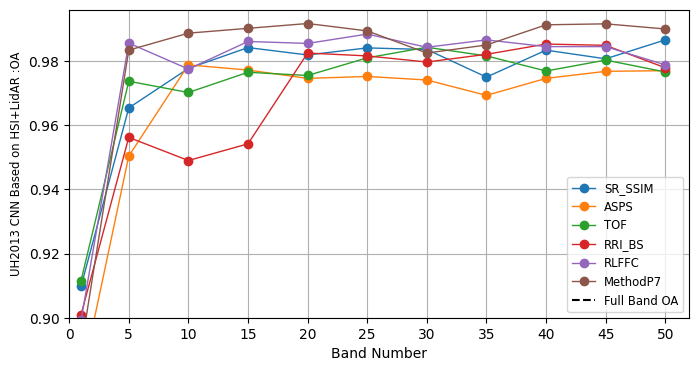

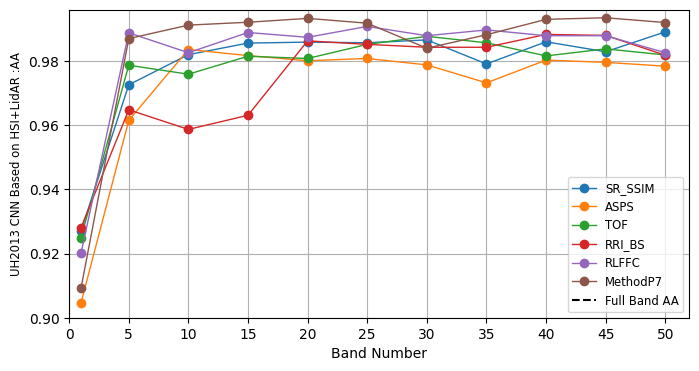

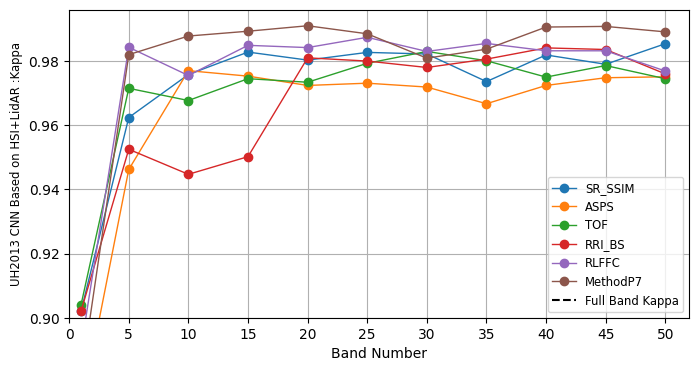

In [ ]:
# Test Result on Jan.26. 2024
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# MUUFL SVM test data(Ablation study)# Remove 1
# Provided data for metrics and seed conditions
data = {
    "Band Number": [50, 50, 50, 45, 45,45, 40,40,40, 35, 35, 35, 30, 30,30,25, 25,25,20, 20,20,15,15,15, 10,10,10, 5,5,5,1,1,1],
    "Metrics": ['OA', 'AA', 'Kappa']*11,
    'SR_SSIM': [0.9866, 0.9891, 0.9854, 0.9807, 0.9829, 0.9790, 0.9834, 0.9860, 0.9819, 0.9750, 0.9791, 0.9736, 0.9836, 0.9866, 0.9822, 0.9841, 0.9857, 0.9827, 0.9819, 0.9859, 0.9803, 0.9842, 0.9856, 0.9828, 0.9777, 0.9820, 0.9758, 0.9654, 0.9726, 0.9624, 0.9098, 0.9271, 0.9021],
'ASPS': [0.9770, 0.9784, 0.9751, 0.9768, 0.9796, 0.9748, 0.9746, 0.9803, 0.9724, 0.9693, 0.9732, 0.9667, 0.9741, 0.9788, 0.9719, 0.9752, 0.9808, 0.9731, 0.9746, 0.9801, 0.9724, 0.9772, 0.9817, 0.9753, 0.9788, 0.9836, 0.9770, 0.9504, 0.9615, 0.9462, 0.8801, 0.9047, 0.8708],
'TOF': [0.9766, 0.9819, 0.9745, 0.9803, 0.9838, 0.9786, 0.9769, 0.9816, 0.9750, 0.9816, 0.9857, 0.9801, 0.9843, 0.9877, 0.9830, 0.9810, 0.9852, 0.9793, 0.9755, 0.9808, 0.9734, 0.9765, 0.9815, 0.9745, 0.9702, 0.9759, 0.9677, 0.9737, 0.9787, 0.9715, 0.9116, 0.9250, 0.9041],
'RRI_BS': [0.9779, 0.9818, 0.9760, 0.9849, 0.9880, 0.9836, 0.9853, 0.9883, 0.9841, 0.9821, 0.9843, 0.9806, 0.9797, 0.9843, 0.9780, 0.9816, 0.9852, 0.9800, 0.9825, 0.9863, 0.9810, 0.9542, 0.9631, 0.9502, 0.9490, 0.9587, 0.9447, 0.9562, 0.9648, 0.9525, 0.9010, 0.9281, 0.9021],
'RLFFC': [0.9788, 0.9826, 0.9769, 0.9845, 0.9879, 0.9832, 0.9845, 0.9879, 0.9832, 0.9866, 0.9897, 0.9855, 0.9843, 0.9879, 0.9830, 0.9884, 0.9908, 0.9874, 0.9855, 0.9874, 0.9842, 0.9861, 0.9889, 0.9849, 0.9775, 0.9826, 0.9755, 0.9856, 0.9888, 0.9843, 0.8992, 0.9202, 0.8907],
'MethodP7': [0.9900, 0.9920, 0.9891, 0.9916, 0.9935, 0.9908, 0.9913, 0.9930, 0.9906, 0.9850, 0.9882, 0.9837, 0.9825, 0.9840, 0.9809, 0.9894, 0.9918, 0.9885, 0.9917, 0.9933, 0.9910, 0.9902, 0.9921, 0.9893, 0.9887, 0.9912, 0.9878, 0.9834, 0.9870, 0.9820, 0.8902, 0.9093, 0.8810]
}

# Creating a DataFrame
df_mf_cnn = pd.DataFrame(data)

metrics = ['OA', 'AA', 'Kappa']
methods = ['SR_SSIM', 'ASPS',  'TOF', 'RRI_BS','RLFFC','MethodP7']

full_bands = {'OA': 0.8532, 'AA': 0.878, 'Kappa': 0.8392}

# Define the band_numbers variable
band_numbers = df_mf_cnn['Band Number'].unique()

# Iterate over metrics to create each plot
for metric in metrics:
    plt.figure(figsize=(8, 4))

    # Extract and plot data for each method
    for method in methods:
        values = df_mf_cnn[df_mf_cnn['Metrics'] == metric][method].values
        plt.plot(band_numbers, values, marker='o', label=method, linewidth=1.5 if method == 'Our method' else 1.0)

    # Add the straight line for the full band benchmark
    plt.axhline(full_bands[metric], color='black', linestyle='--', label=f'Full Band {metric}')

    plt.xlabel('Band Number')
    plt.ylabel(f'UH2013 CNN Based on HSI+LidAR :{metric}', fontsize='small')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.ylim(0.9000, 0.9960)
    plt.xlim(0, 52)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(5))
    plt.show()